In [1]:
# ========================================
# CELL 1: Install Required Packages
# ========================================
!pip install tensorboardX tqdm pytorch-msssim lpips scipy ml-collections


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%%writefile cswin_unet.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from einops.layers.torch import Rearrange
import torch.utils.checkpoint as checkpoint
import numpy as np


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class LePEAttention(nn.Module):
    def __init__(self, dim, resolution, idx, split_size, dim_out=None, num_heads=9, attn_drop=0., proj_drop=0.,
                 qk_scale=None):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out or dim
        self.resolution = resolution
        self.split_size = split_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        if idx == -1:
            H_sp, W_sp = self.resolution, self.resolution
        elif idx == 0:
            H_sp, W_sp = self.resolution, self.split_size
        elif idx == 1:
            W_sp, H_sp = self.resolution, self.split_size
        else:
            print("ERROR MODE", idx)
            exit(0)
        self.H_sp = H_sp
        self.W_sp = W_sp
        stride = 1
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim)

        self.attn_drop = nn.Dropout(attn_drop)

    def im2cswin(self, x):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = img2windows(x, self.H_sp, self.W_sp)
        x = x.reshape(-1, self.H_sp * self.W_sp, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3).contiguous()
        return x

    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.H_sp, self.W_sp
        x = x.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp)  ### B', C, H', W'

        lepe = func(x)  ### B', C, H', W'
        lepe = lepe.reshape(-1, self.num_heads, C // self.num_heads, H_sp * W_sp).permute(0, 1, 3, 2).contiguous()

        x = x.reshape(-1, self.num_heads, C // self.num_heads, self.H_sp * self.W_sp).permute(0, 1, 3, 2).contiguous()
        return x, lepe

    def forward(self, qkv):
        """
        x: B L C
        """
        q, k, v = qkv[0], qkv[1], qkv[2]

        ### Img2Window
        H = W = self.resolution
        B, L, C = q.shape

        assert L == H * W, "flatten img_tokens has wrong size"

        q = self.im2cswin(q)
        k = self.im2cswin(k)
        v, lepe = self.get_lepe(v, self.get_v)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))  # B head N C @ B head C N --> B head N N
        attn = nn.functional.softmax(attn, dim=-1, dtype=attn.dtype)
        attn = self.attn_drop(attn)

        x = (attn @ v) + lepe
        x = x.transpose(1, 2).reshape(-1, self.H_sp * self.W_sp, C)  # B head N N @ B head N C

        ### Window2Img
        x = windows2img(x, self.H_sp, self.W_sp, H, W).view(B, -1, C)  # B H' W' C

        return x


class CSWinBlock(nn.Module):

    def __init__(self, dim, reso, num_heads,
                 split_size, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 last_stage=False):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patches_resolution = reso
        self.split_size = split_size
        self.mlp_ratio = mlp_ratio
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.norm1 = norm_layer(dim)

        if self.patches_resolution == split_size:
            last_stage = True
        if last_stage:
            self.branch_num = 1
        else:
            self.branch_num = 2
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)

        if last_stage:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim, resolution=self.patches_resolution, idx=-1,
                    split_size=split_size, num_heads=num_heads, dim_out=dim,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])

        else:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim // 2, resolution=self.patches_resolution, idx=i,
                    split_size=split_size, num_heads=num_heads // 2, dim_out=dim // 2,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])

        mlp_hidden_dim = int(dim * mlp_ratio)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer,
                       drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """

        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        img = self.norm1(x)
        qkv = self.qkv(img).reshape(B, -1, 3, C).permute(2, 0, 1, 3)

        if self.branch_num == 2:
            x1 = self.attns[0](qkv[:, :, :, :C // 2])
            x2 = self.attns[1](qkv[:, :, :, C // 2:])
            attened_x = torch.cat([x1, x2], dim=2)
        else:
            attened_x = self.attns[0](qkv)
        attened_x = self.proj(attened_x)
        x = x + self.drop_path(attened_x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


def img2windows(img, H_sp, W_sp):
    """
    img: B C H W
    """
    B, C, H, W = img.shape
    img_reshape = img.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
    img_perm = img_reshape.permute(0, 2, 4, 3, 5, 1).contiguous().reshape(-1, H_sp * W_sp, C)
    return img_perm


def windows2img(img_splits_hw, H_sp, W_sp, H, W):
    """
    img_splits_hw: B' H W C
    """
    B = int(img_splits_hw.shape[0] / (H * W / H_sp / W_sp))

    img = img_splits_hw.view(B, H // H_sp, W // W_sp, H_sp, W_sp, -1)
    img = img.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return img


class Merge_Block(nn.Module):
    def __init__(self, dim, dim_out, norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim_out, 3, 2, 1)
        self.norm = norm_layer(dim_out)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = self.conv(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = self.norm(x)

        return x

class CARAFE(nn.Module):
    def __init__(self, dim, dim_out, kernel_size=3, up_factor=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.up_factor = up_factor
        self.down = nn.Conv2d(dim, dim // 4, 1)
        self.encoder = nn.Conv2d(dim // 4, self.up_factor ** 2 * self.kernel_size ** 2,
                                 self.kernel_size, 1, self.kernel_size // 2)
        self.out = nn.Conv2d(dim, dim_out, 1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)


            # N,C,H,W -> N,C,delta*H,delta*W
            # kernel prediction module
        kernel_tensor = self.down(x)  # (N, Cm, H, W)
        kernel_tensor = self.encoder(kernel_tensor)  # (N, S^2 * Kup^2, H, W)
        kernel_tensor = F.pixel_shuffle(kernel_tensor,
                                        self.up_factor)  # (N, S^2 * Kup^2, H, W)->(N, Kup^2, S*H, S*W)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)  # (N, Kup^2, S*H, S*W)
        kernel_tensor = kernel_tensor.unfold(2, self.up_factor, step=self.up_factor)  # (N, Kup^2, H, W*S, S)
        kernel_tensor = kernel_tensor.unfold(3, self.up_factor, step=self.up_factor)  # (N, Kup^2, H, W, S, S)
        kernel_tensor = kernel_tensor.reshape(B, self.kernel_size ** 2, H, W,
                                                  self.up_factor ** 2)  # (N, Kup^2, H, W, S^2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)  # (N, H, W, Kup^2, S^2)

            # content-aware reassembly module
            # tensor.unfold: dim, size, step
        w = F.pad(x, pad=(self.kernel_size // 2, self.kernel_size // 2,
                                              self.kernel_size // 2, self.kernel_size // 2),
                              mode='constant', value=0)  # (N, C, H+Kup//2+Kup//2, W+Kup//2+Kup//2)
        w = w.unfold(2, self.kernel_size, step=1)  # (N, C, H, W+Kup//2+Kup//2, Kup)
        w = w.unfold(3, self.kernel_size, step=1)  # (N, C, H, W, Kup, Kup)
        w = w.reshape(B, C, H, W, -1)  # (N, C, H, W, Kup^2)
        w = w.permute(0, 2, 3, 1, 4)  # (N, H, W, C, Kup^2)

        x = torch.matmul(w, kernel_tensor)  # (N, H, W, C, S^2)
        x = x.reshape(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)
        x = F.pixel_shuffle(x, self.up_factor)
        x = self.out(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()

        return x


class CARAFE4(nn.Module):
    def __init__(self, dim, dim_out, kernel_size=3, up_factor=4):
        super().__init__()
        self.kernel_size = kernel_size
        self.up_factor = up_factor
        self.down = nn.Conv2d(dim, dim // 4, 1)
        self.encoder = nn.Conv2d(dim // 4, self.up_factor ** 2 * self.kernel_size ** 2,
                                 self.kernel_size, 1, self.kernel_size // 2)
        self.out = nn.Conv2d(dim, dim_out, 1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)


            # N,C,H,W -> N,C,delta*H,delta*W
            # kernel prediction module
        kernel_tensor = self.down(x)  # (N, Cm, H, W)
        kernel_tensor = self.encoder(kernel_tensor)  # (N, S^2 * Kup^2, H, W)
        kernel_tensor = F.pixel_shuffle(kernel_tensor,
                                        self.up_factor)  # (N, S^2 * Kup^2, H, W)->(N, Kup^2, S*H, S*W)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)  # (N, Kup^2, S*H, S*W)
        kernel_tensor = kernel_tensor.unfold(2, self.up_factor, step=self.up_factor)  # (N, Kup^2, H, W*S, S)
        kernel_tensor = kernel_tensor.unfold(3, self.up_factor, step=self.up_factor)  # (N, Kup^2, H, W, S, S)
        kernel_tensor = kernel_tensor.reshape(B, self.kernel_size ** 2, H, W,
                                                  self.up_factor ** 2)  # (N, Kup^2, H, W, S^2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)  # (N, H, W, Kup^2, S^2)

            # content-aware reassembly module
            # tensor.unfold: dim, size, step
        w = F.pad(x, pad=(self.kernel_size // 2, self.kernel_size // 2,
                                              self.kernel_size // 2, self.kernel_size // 2),
                              mode='constant', value=0)  # (N, C, H+Kup//2+Kup//2, W+Kup//2+Kup//2)
        w = w.unfold(2, self.kernel_size, step=1)  # (N, C, H, W+Kup//2+Kup//2, Kup)
        w = w.unfold(3, self.kernel_size, step=1)  # (N, C, H, W, Kup, Kup)
        w = w.reshape(B, C, H, W, -1)  # (N, C, H, W, Kup^2)
        w = w.permute(0, 2, 3, 1, 4)  # (N, H, W, C, Kup^2)

        x = torch.matmul(w, kernel_tensor)  # (N, H, W, C, S^2)
        x = x.reshape(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)
        x = F.pixel_shuffle(x, self.up_factor)
        x = self.out(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()

        return x


class CSWinTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=8, embed_dim=64, depth=[1, 2, 9, 1],
                 split_size=[1, 2, 7, 7],
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0, hybrid_backbone=None, norm_layer=nn.LayerNorm, use_chk=False):
        super().__init__()
        self.use_chk = use_chk
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        heads = num_heads

        #encoder

        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, 7, 4, 2),
            Rearrange('b c h w -> b (h w) c', h=img_size // 4, w=img_size // 4),
            nn.LayerNorm(embed_dim)
        )

        curr_dim = embed_dim

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, np.sum(depth))]  # stochastic depth decay rule
        print("depth",depth)
        self.stage1 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size // 4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth[0])])
        self.merge1 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        self.stage2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size // 8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.merge2 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        temp_stage3 = []
        temp_stage3.extend(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size // 16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])])

        self.stage3 = nn.ModuleList(temp_stage3)
        self.merge3 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        self.stage4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size // 32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer, last_stage=True)
                for i in range(depth[-1])])

        self.norm = norm_layer(curr_dim)

        # decoder


        self.stage_up4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size // 32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer, last_stage=True)
                for i in range(depth[-1])])

        self.upsample4 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear4 = nn.Linear(512, 256)
        self.stage_up3 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size // 16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])]
        )

        self.upsample3 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear3 = nn.Linear(256, 128)
        self.stage_up2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size // 8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.upsample2 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear2 = nn.Linear(128, 64)
        self.stage_up1 = nn.ModuleList([
            CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size // 4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth[0])])

        self.upsample1 = CARAFE4(curr_dim, 64)
        self.norm_up = norm_layer(embed_dim)
        self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)
        # Classifier head

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    #Encoder and Bottleneck
    def forward_features(self, x):
        x = self.stage1_conv_embed(x)

        x = self.pos_drop(x)

        for blk in self.stage1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x1 = x
        x = self.merge1(x)

        for blk in self.stage2:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x2 = x
        x = self.merge2(x)

        for blk in self.stage3:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                    x = blk(x)
        self.x3 = x
        x = self.merge3(x)

        for blk in self.stage4:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        x = self.norm(x)

        return x

    #Dencoder and Skip connection
    def forward_up_features(self, x):
        for blk in self.stage_up4:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample4(x)
        x = torch.cat([self.x3, x],-1)
        x = self.concat_linear4(x)
        for blk in self.stage_up3:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        # print("decoder stage3", x.shape)
        x = self.upsample3(x)
        x = torch.cat([self.x2, x],-1)
        x = self.concat_linear3(x)
        for blk in self.stage_up2:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                    x = blk(x)
        x = self.upsample2(x)
        x = torch.cat([self.x1, x],-1)
        x = self.concat_linear2(x)
        for blk in self.stage_up1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.norm_up(x)  # B L C
        return x

    def up_x4(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = self.upsample1(x)
        x = x.view(B, 4 * H, 4 * W, -1)
        x = x.permute(0, 3, 1, 2)  # B,C,H,W
        x = self.output(x)

        return x

    def forward(self, x):
        x = self.forward_features(x)

        x = self.forward_up_features(x)

        x = self.up_x4(x)


        return x

Writing cswin_unet.py


In [3]:
%%writefile vision_transformer.py

import torch
import torch.nn as nn
import copy
from cswin_unet import CSWinTransformer

class CSwinUnet(nn.Module):
    def __init__(
        self,
        img_size=224,
        num_classes=1,
        patch_size=4,
        embed_dim=64,
        # embed_dim=96,
        depth=[1, 2, 9, 1],
        split_size=[1, 2, 7, 7],
        num_heads=[2, 4, 8, 16],
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        drop_path_rate=0.1,
        pretrained_ckpt=None,
    ):
        """
        Initialize the CSWinUnet model for deblurring.

        :param img_size: Size of input images (default is 224).
        :param num_classes: Number of output channels (1 for grayscale).
        :param patch_size: Patch size for the transformer (default is 4).
        :param embed_dim: Embedding dimension (default is 96).
        :param depth: Depth of each stage (list of integers).
        :param split_size: Split size for local attention at each stage.
        :param num_heads: Number of attention heads at each stage.
        :param mlp_ratio: MLP ratio in transformer blocks.
        :param qkv_bias: Whether to use bias in QKV projection.
        :param qk_scale: Scaling factor for QK projection (default is None).
        :param drop_rate: Dropout rate.
        :param drop_path_rate: Stochastic depth rate.
        :param pretrained_ckpt: Path to a pretrained checkpoint file (optional).
        """
        super(CSwinUnet, self).__init__()
        self.num_classes = num_classes

        # Initialize the CSWinTransformer model
        self.cswin_unet = CSWinTransformer(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=1,  # Grayscale images
            num_classes=self.num_classes,
            embed_dim=embed_dim,
            depth=depth,
            split_size=split_size,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
        )

        print("CSWinUnet model initialized.")

        # Load pretrained weights if provided
        if pretrained_ckpt:
            self.load_from(pretrained_ckpt)

    def forward(self, x):
        # if x.size()[1] == 1:
        #     x = x.repeat(1,3,1,1)
        logits = self.cswin_unet(x)
        return logits

    def load_from(self, pretrained_ckpt):
        """
        Load a pretrained model from a checkpoint file.

        :param pretrained_ckpt: Path to the pretrained checkpoint file.
        """
        print(f"Loading pretrained model from {pretrained_ckpt}")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        pretrained_dict = torch.load(pretrained_ckpt, map_location=device)

        # Ensure compatibility with current model structure
        pretrained_dict = pretrained_dict.get('state_dict_ema', pretrained_dict)  # Adjust key if nested
        model_dict = self.cswin_unet.state_dict()
        full_dict = copy.deepcopy(pretrained_dict)

        # Adjust stage keys for upsampling compatibility
        for k, v in pretrained_dict.items():
            if "stage" in k:
                current_k = "stage_up" + k[5:]
                full_dict[current_k] = v

        # Remove mismatched keys
        for k in list(full_dict.keys()):
            if k in model_dict and full_dict[k].shape != model_dict[k].shape:
                print(f"Deleting key: {k}, shapes don't match (pretrained: {full_dict[k].shape}, model: {model_dict[k].shape})")
                del full_dict[k]

        # Load state dict into the model
        msg = self.cswin_unet.load_state_dict(full_dict, strict=False)
        print(f"Model loaded successfully: {msg}")


Writing vision_transformer.py


In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class PairedXrayDataset(Dataset):
    def __init__(self, blurred_dir, clear_dir, transform=None):
        """
        Args:
            blurred_dir (str): Directory with blurred images.
            clear_dir (str): Directory with corresponding clear images.
            transform (callable, optional): Optional transformations to apply to both blurred and clear images.
        """
        # Verify directories exist
        assert os.path.isdir(blurred_dir), f"Directory not found: {blurred_dir}"
        assert os.path.isdir(clear_dir), f"Directory not found: {clear_dir}"
        
        self.blurred_dir = blurred_dir
        self.clear_dir = clear_dir
        self.transform = transform
        self.blurred_images = sorted(os.listdir(blurred_dir))
        self.clear_images = sorted(os.listdir(clear_dir))

        # Ensure both directories have the same number of images
        assert len(self.blurred_images) == len(self.clear_images), \
            "Mismatched number of images in blurred and clear directories."

    def __len__(self):
        return len(self.blurred_images)

    def __getitem__(self, idx):
        # Get file paths for blurred and clear images
        blurred_path = os.path.join(self.blurred_dir, self.blurred_images[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_images[idx])

        # Load images and convert to grayscale if necessary
        blurred_image = Image.open(blurred_path).convert("L")  # "L" mode for grayscale
        clear_image = Image.open(clear_path).convert("L")

        # Apply transformations if provided
        if self.transform:
            blurred_image = self.transform(blurred_image)
            clear_image = self.transform(clear_image)
        else:
            # Default transformations: resize and convert to tensor
            default_transform = transforms.Compose([
                transforms.Resize((224, 224)),  # Resize to match model input size
                transforms.ToTensor(),
            ])
            blurred_image = default_transform(blurred_image)
            clear_image = default_transform(clear_image)

        return blurred_image, clear_image




/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda
depth [1, 2, 9, 1]
CSWinUnet model initialized.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 233MB/s] 
/tmp/ipykernel_37/1380526225.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/150:   0%


Checkpoint saved: /kaggle/working/model_checkpoints/epoch_10.pth


Epoch 20/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.0252]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_20.pth


Epoch 30/150: 100%|██████████| 160/160 [00:37<00:00,  4.27batch/s, Loss=0.0218]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_30.pth


Epoch 40/150: 100%|██████████| 160/160 [00:37<00:00,  4.30batch/s, Loss=0.0186]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_40.pth


Epoch 50/150: 100%|██████████| 160/160 [00:38<00:00,  4.18batch/s, Loss=0.0174]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_50.pth


Epoch 60/150: 100%|██████████| 160/160 [00:37<00:00,  4.27batch/s, Loss=0.0148]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_60.pth


Epoch 70/150: 100%|██████████| 160/160 [00:37<00:00,  4.27batch/s, Loss=0.0137]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_70.pth


Epoch 80/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.0123]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_80.pth


Epoch 90/150: 100%|██████████| 160/160 [00:37<00:00,  4.29batch/s, Loss=0.0115]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_90.pth


Epoch 100/150: 100%|██████████| 160/160 [00:37<00:00,  4.25batch/s, Loss=0.0108]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_100.pth


Epoch 110/150: 100%|██████████| 160/160 [00:38<00:00,  4.17batch/s, Loss=0.0102]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_110.pth


Epoch 120/150: 100%|██████████| 160/160 [00:37<00:00,  4.26batch/s, Loss=0.00994]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_120.pth


Epoch 130/150: 100%|██████████| 160/160 [00:37<00:00,  4.26batch/s, Loss=0.00972]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_130.pth


Epoch 140/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.00963]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_140.pth


Epoch 150/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.00958]



Checkpoint saved: /kaggle/working/model_checkpoints/epoch_150.pth

Training Metrics:
Total Training Time: 1.57 hours
Average Epoch Time: 37.46 seconds
Average Inference Time: 42.64 ms


Training completed. Model saved to /kaggle/working/model_checkpoints/final_model.pth
Best loss: 0.009579 at epoch 150

EVALUATING MODEL WITH ALL METRICS
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 235MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 79.2MB/s] 
Evaluating all metrics: 100%|██████████| 160/160 [00:23<00:00,  6.88it/s]



Evaluation Results:
----------------------------------------
PSNR: 40.4674
SSIM: 0.9712
LPIPS: 0.0379
FID: 31.8765
----------------------------------------

Metrics saved!


ValueError: not enough values to unpack (expected 3, got 2)

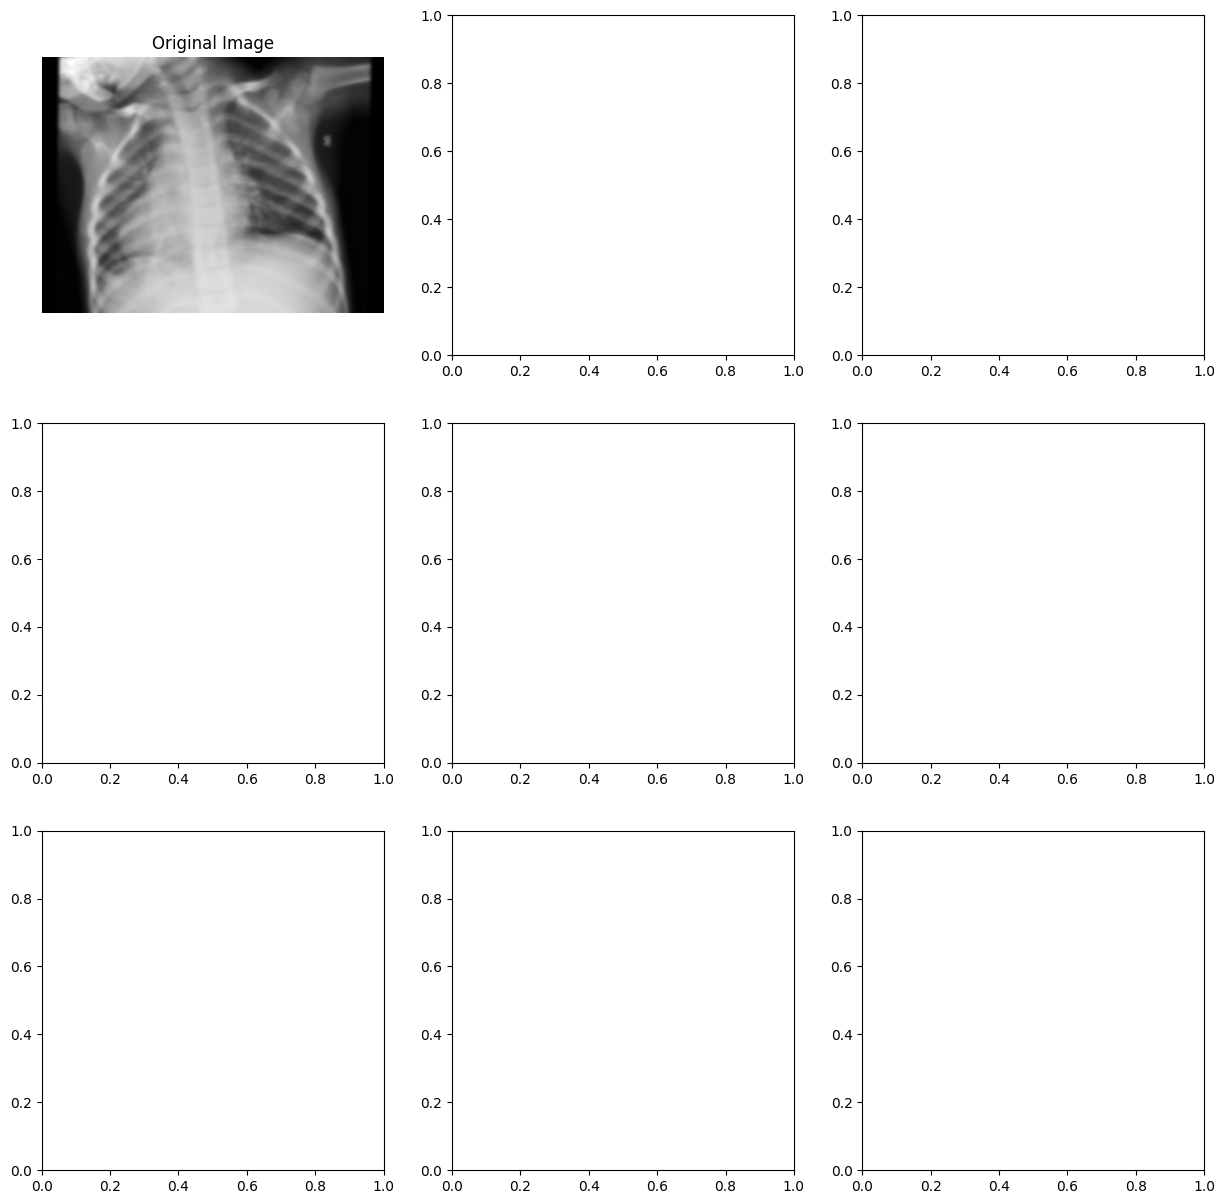

In [5]:
# ========================================
# CELL 5: Complete Training Script with All Tasks
# ========================================
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from vision_transformer import CSwinUnet
from tensorboardX import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_msssim import ssim
from tqdm import tqdm
from torchvision.models import vgg19
import matplotlib.pyplot as plt
import pandas as pd
import time
import lpips
from scipy import linalg
import torchvision.models as models

class Args:
    def __init__(self):
        self.clear_dir = '/kaggle/input/ch-xrays/augmented/augmented'
        self.blurred_dir = '/kaggle/input/ch-xrays/aug_blurred/aug_blurred'
        self.num_classes = 1
        self.img_size = 224
        self.max_epochs = 150
        self.batch_size = 8
        self.base_lr = 0.0005
        self.deterministic = 1
        self.seed = 1234
        self.ssim_weight = 0.5
        self.perceptual_weight = 0.1
        self.snapshot_path = '/kaggle/working/model_checkpoints'
        self.plots_dir = '/kaggle/working/training_plots'

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6, out_norm='bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        def get_outnorm(tensor: torch.Tensor, out_norm: str):
            img_shape = tensor.shape
            norm = 1
            if 'b' in out_norm:
                norm /= img_shape[0]
            if 'c' in out_norm:
                norm /= img_shape[-3]
            if 'i' in out_norm:
                norm /= img_shape[-1] * img_shape[-2]
            return norm

        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss * norm

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_model, charbonnier_eps=1e-3, perceptual_weight=0.1, ssim_weight=0.1):
        super(CombinedLoss, self).__init__()
        self.charbonnier_loss = CharbonnierLoss(eps=charbonnier_eps)
        self.perceptual_model = perceptual_model
        self.perceptual_model.eval()
        for param in self.perceptual_model.parameters():
            param.requires_grad = False
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight

    def forward(self, output, target):
        if output.size(1) == 1:
            output = output.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        l_charbonnier = self.charbonnier_loss(output, target)
        l_ssim = 1 - ssim(output, target)
        output_features = self.perceptual_model(output)
        target_features = self.perceptual_model(target)
        l_perceptual = torch.mean((output_features - target_features).pow(2))

        loss = l_charbonnier + self.ssim_weight * l_ssim + self.perceptual_weight * l_perceptual
        return loss

def save_loss_plot(losses, plots_dir):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, 'b-')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, 'loss_plot.png'))
    plt.close()

def measure_inference_time(model, input_shape=(1, 1, 224, 224), device='cuda', num_iterations=100):
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)
    
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)
    
    torch.cuda.synchronize()
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / num_iterations
    return avg_inference_time * 1000

def train_model(args, model, dataloader, optimizer, scheduler, combined_loss, device):
    model.train()
    scaler = GradScaler()
    writer = SummaryWriter(logdir=args.snapshot_path)
    
    epoch_losses = []
    epoch_times = []
    
    patience = 20
    best_loss = float('inf')
    patience_counter = 0
    
    os.makedirs(args.plots_dir, exist_ok=True)
    
    total_train_start = time.time()

    for epoch in range(args.max_epochs):
        running_loss = 0.0
        epoch_start_time = time.time()
        
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{args.max_epochs}", unit="batch") as pbar:
            for i, (blurred, clear) in enumerate(dataloader):
                blurred, clear = blurred.to(device), clear.to(device)
                optimizer.zero_grad()

                with autocast():
                    output = model(blurred)
                    loss = combined_loss(output, clear)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()
                pbar.set_postfix({'Loss': running_loss / (i + 1)})
                pbar.update(1)

        scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        df_epochs = pd.DataFrame({
            'Epoch': range(1, len(epoch_losses) + 1),
            'Loss': epoch_losses,
            'Time_seconds': epoch_times
        })
        df_epochs.to_csv(os.path.join(args.plots_dir, 'epoch_metrics.csv'), index=False)
        save_loss_plot(epoch_losses, args.plots_dir)

        writer.add_scalar('Training Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Epoch Time', epoch_time, epoch)

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}.")
            break

        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(args.snapshot_path, f"epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"\nCheckpoint saved: {checkpoint_path}")

    total_train_time = time.time() - total_train_start
    inference_time = measure_inference_time(model, device=device)
    
    timing_metrics = {
        'Total Training Time (seconds)': total_train_time,
        'Total Training Time (hours)': total_train_time / 3600,
        'Average Epoch Time (seconds)': np.mean(epoch_times),
        'Average Inference Time (milliseconds)': inference_time,
        'Total Epochs': len(epoch_losses)
    }
    
    timing_df = pd.DataFrame([timing_metrics])
    timing_df.to_csv(os.path.join(args.plots_dir, 'timing_metrics.csv'), index=False)
    
    print(f"\n{'='*50}")
    print(f"Training Metrics:")
    print(f"Total Training Time: {total_train_time/3600:.2f} hours")
    print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
    print(f"Average Inference Time: {inference_time:.2f} ms")
    print(f"{'='*50}\n")

    final_model_path = os.path.join(args.snapshot_path, "final_model.pth")
    torch.save(model.state_dict(), final_model_path)
    
    print(f"\nTraining completed. Model saved to {final_model_path}")
    print(f"Best loss: {min(epoch_losses):.6f} at epoch {epoch_losses.index(min(epoch_losses)) + 1}")

def calculate_psnr_ssim_lpips_fid(model, dataloader, device):
    model.eval()
    
    lpips_model = lpips.LPIPS(net='alex').to(device)
    
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False
    
    psnr_scores = []
    ssim_scores = []
    lpips_scores = []
    
    real_activations = []
    fake_activations = []
    
    with torch.no_grad():
        for blurred, clear in tqdm(dataloader, desc="Evaluating all metrics"):
            blurred = blurred.to(device)
            clear = clear.to(device)
            
            output = model(blurred)
            
            mse = torch.mean((output - clear) ** 2, dim=[1, 2, 3])
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
            psnr_scores.extend(psnr.cpu().numpy())
            
            ssim_val = ssim(output, clear, data_range=1.0, size_average=False)
            ssim_scores.extend(ssim_val.cpu().numpy())
            
            output_3ch = output.repeat(1, 3, 1, 1) if output.shape[1] == 1 else output
            clear_3ch = clear.repeat(1, 3, 1, 1) if clear.shape[1] == 1 else clear
            
            output_normalized = output_3ch * 2 - 1
            clear_normalized = clear_3ch * 2 - 1
            
            lpips_score = lpips_model(output_normalized, clear_normalized)
            lpips_scores.extend(lpips_score.squeeze().cpu().numpy())
            
            if len(real_activations) < 100:
                real_feat = inception_model(clear_3ch)
                fake_feat = inception_model(output_3ch)
                real_activations.append(real_feat.cpu().numpy())
                fake_activations.append(fake_feat.cpu().numpy())
    
    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)
    
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    
    mu_fake = np.mean(fake_activations, axis=0)
    sigma_fake = np.cov(fake_activations, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    metrics = {
        'PSNR': np.mean(psnr_scores),
        'SSIM': np.mean(ssim_scores),
        'LPIPS': np.mean(lpips_scores),
        'FID': fid_score
    }
    
    return metrics

def visualize_attention_maps(model, test_image_path, device, save_dir='/kaggle/working/attention_maps'):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    image = Image.open(test_image_path).convert('L')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    attention_outputs = {}
    
    def get_activation(name):
        def hook(module, input, output):
            attention_outputs[name] = output.detach()
        return hook
    
    hooks = []
    for i, block in enumerate(model.cswin_unet.stage1):
        hooks.append(block.register_forward_hook(get_activation(f'stage1_block{i}')))
    for i, block in enumerate(model.cswin_unet.stage2):
        hooks.append(block.register_forward_hook(get_activation(f'stage2_block{i}')))
    for i, block in enumerate(model.cswin_unet.stage3):
        hooks.append(block.register_forward_hook(get_activation(f'stage3_block{i}')))
    for i, block in enumerate(model.cswin_unet.stage4):
        hooks.append(block.register_forward_hook(get_activation(f'stage4_block{i}')))
    
    with torch.no_grad():
        _ = model(input_tensor)
    
    for hook in hooks:
        hook.remove()
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    plot_idx = 1
    for stage_name in ['stage1', 'stage2', 'stage3', 'stage4']:
        stage_keys = [k for k in attention_outputs.keys() if stage_name in k]
        if len(stage_keys) > 0 and plot_idx < 9:
            key = stage_keys[0]
            attn = attention_outputs[key][0]
            
            B, L, C = attn.shape
            H = W = int(np.sqrt(L))
            attn_map = attn.mean(dim=-1).view(H, W).cpu().numpy()
            
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
            
            row = (plot_idx) // 3
            col = (plot_idx) % 3
            axes[row * 3 + col].imshow(attn_map, cmap='jet')
            axes[row * 3 + col].set_title(f'Attention - {stage_name}')
            axes[row * 3 + col].axis('off')
            plot_idx += 1
    
    for idx in range(plot_idx, 9):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'attention_maps.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Attention maps saved to {save_dir}")

def main():
    args = Args()

    if args.deterministic:
        cudnn.benchmark = False
        cudnn.deterministic = True
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)
        torch.cuda.manual_seed(args.seed)

    os.makedirs(args.snapshot_path, exist_ok=True)

    logging.basicConfig(
        filename=os.path.join(args.snapshot_path, "train.log"),
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logging.info("Training started with configuration: %s", vars(args))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = CSwinUnet(img_size=args.img_size, num_classes=args.num_classes).to(device)
    logging.info("Model initialized")

    vgg = vgg19(pretrained=True).features[:9].to(device).eval()
    for param in vgg.parameters():
        param.requires_grad = False

    combined_loss = CombinedLoss(
        perceptual_model=vgg,
        ssim_weight=args.ssim_weight,
        perceptual_weight=args.perceptual_weight
    )
    logging.info("Loss functions initialized")

    optimizer = optim.AdamW(model.parameters(), lr=args.base_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=args.max_epochs, eta_min=1e-6)

    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor()
    ])

    dataset = PairedXrayDataset(
        blurred_dir=args.blurred_dir,
        clear_dir=args.clear_dir,
        transform=transform
    )
    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    logging.info(f"Dataloader initialized with {len(dataset)} samples")

    train_model(args, model, dataloader, optimizer, scheduler, combined_loss, device)
    logging.info("Training completed")
    
    print("\n" + "="*60)
    print("EVALUATING MODEL WITH ALL METRICS")
    print("="*60)
    
    test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    model_path = os.path.join(args.snapshot_path, 'final_model.pth')
    model.load_state_dict(torch.load(model_path))
    
    metrics = calculate_psnr_ssim_lpips_fid(model, test_loader, device)
    
    print("\nEvaluation Results:")
    print("-" * 40)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("-" * 40)
    
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(args.plots_dir, 'evaluation_metrics.csv'), index=False)
    print(f"\nMetrics saved!")
    
    test_image = os.path.join(args.blurred_dir, os.listdir(args.blurred_dir)[0])
    visualize_attention_maps(model, test_image, device)
    print("\nAll tasks completed!")

if __name__ == "__main__":
    main()


In [5]:
%%writefile cswin_unet_lepe_only.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from einops.layers.torch import Rearrange
import torch.utils.checkpoint as checkpoint
import numpy as np


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class LePEAttention(nn.Module):
    def __init__(self, dim, resolution, idx, split_size, dim_out=None, num_heads=9, attn_drop=0., proj_drop=0.,
                 qk_scale=None):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out or dim
        self.resolution = resolution
        self.split_size = split_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        if idx == -1:
            H_sp, W_sp = self.resolution, self.resolution
        elif idx == 0:
            H_sp, W_sp = self.resolution, self.split_size
        elif idx == 1:
            W_sp, H_sp = self.resolution, self.split_size
        else:
            print("ERROR MODE", idx)
            exit(0)
        self.H_sp = H_sp
        self.W_sp = W_sp
        stride = 1
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim)

        self.attn_drop = nn.Dropout(attn_drop)

    def im2cswin(self, x):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = img2windows(x, self.H_sp, self.W_sp)
        x = x.reshape(-1, self.H_sp * self.W_sp, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3).contiguous()
        return x

    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.H_sp, self.W_sp
        x = x.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp)

        lepe = func(x)
        lepe = lepe.reshape(-1, self.num_heads, C // self.num_heads, H_sp * W_sp).permute(0, 1, 3, 2).contiguous()

        x = x.reshape(-1, self.num_heads, C // self.num_heads, self.H_sp * self.W_sp).permute(0, 1, 3, 2).contiguous()
        return x, lepe

    def forward(self, qkv):
        q, k, v = qkv[0], qkv[1], qkv[2]

        H = W = self.resolution
        B, L, C = q.shape

        assert L == H * W, "flatten img_tokens has wrong size"

        q = self.im2cswin(q)
        k = self.im2cswin(k)
        v, lepe = self.get_lepe(v, self.get_v)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        attn = nn.functional.softmax(attn, dim=-1, dtype=attn.dtype)
        attn = self.attn_drop(attn)

        x = (attn @ v) + lepe
        x = x.transpose(1, 2).reshape(-1, self.H_sp * self.W_sp, C)

        x = windows2img(x, self.H_sp, self.W_sp, H, W).view(B, -1, C)

        return x


class CSWinBlock(nn.Module):

    def __init__(self, dim, reso, num_heads,
                 split_size, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 last_stage=False):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patches_resolution = reso
        self.split_size = split_size
        self.mlp_ratio = mlp_ratio
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.norm1 = norm_layer(dim)

        if self.patches_resolution == split_size:
            last_stage = True
        if last_stage:
            self.branch_num = 1
        else:
            self.branch_num = 2
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)

        if last_stage:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim, resolution=self.patches_resolution, idx=-1,
                    split_size=split_size, num_heads=num_heads, dim_out=dim,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])

        else:
            self.attns = nn.ModuleList([
                LePEAttention(
                    dim // 2, resolution=self.patches_resolution, idx=i,
                    split_size=split_size, num_heads=num_heads // 2, dim_out=dim // 2,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])

        mlp_hidden_dim = int(dim * mlp_ratio)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer,
                       drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        img = self.norm1(x)
        qkv = self.qkv(img).reshape(B, -1, 3, C).permute(2, 0, 1, 3)

        if self.branch_num == 2:
            x1 = self.attns[0](qkv[:, :, :, :C // 2])
            x2 = self.attns[1](qkv[:, :, :, C // 2:])
            attened_x = torch.cat([x1, x2], dim=2)
        else:
            attened_x = self.attns[0](qkv)
        attened_x = self.proj(attened_x)
        x = x + self.drop_path(attened_x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


def img2windows(img, H_sp, W_sp):
    B, C, H, W = img.shape
    img_reshape = img.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
    img_perm = img_reshape.permute(0, 2, 4, 3, 5, 1).contiguous().reshape(-1, H_sp * W_sp, C)
    return img_perm


def windows2img(img_splits_hw, H_sp, W_sp, H, W):
    B = int(img_splits_hw.shape[0] / (H * W / H_sp / W_sp))

    img = img_splits_hw.view(B, H // H_sp, W // W_sp, H_sp, W_sp, -1)
    img = img.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return img


class Merge_Block(nn.Module):
    def __init__(self, dim, dim_out, norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim_out, 3, 2, 1)
        self.norm = norm_layer(dim_out)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = self.conv(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = self.norm(x)

        return x

# ABLATION: Replace CARAFE with simple bilinear upsampling
class SimpleUpsample(nn.Module):
    def __init__(self, dim, dim_out, up_factor=2):
        super().__init__()
        self.up_factor = up_factor
        self.conv = nn.Conv2d(dim, dim_out, kernel_size=1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        
        x = F.interpolate(x, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        x = self.conv(x)
        
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        return x


class CSWinTransformer_LePEOnly(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=8, embed_dim=64, depth=[1, 2, 9, 1],
                 split_size=[1, 2, 7, 7],
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0, hybrid_backbone=None, norm_layer=nn.LayerNorm, use_chk=False):
        super().__init__()
        self.use_chk = use_chk
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        heads = num_heads

        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, 7, 4, 2),
            Rearrange('b c h w -> b (h w) c', h=img_size // 4, w=img_size // 4),
            nn.LayerNorm(embed_dim)
        )

        curr_dim = embed_dim

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, np.sum(depth))]
        
        self.stage1 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size // 4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
                for i in range(depth[0])])
        self.merge1 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        self.stage2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size // 8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.merge2 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        temp_stage3 = []
        temp_stage3.extend(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size // 16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])])

        self.stage3 = nn.ModuleList(temp_stage3)
        self.merge3 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        self.stage4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size // 32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer, last_stage=True)
                for i in range(depth[-1])])

        self.norm = norm_layer(curr_dim)

        self.stage_up4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size // 32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer, last_stage=True)
                for i in range(depth[-1])])

        # ABLATION: Use SimpleUpsample instead of CARAFE
        self.upsample4 = SimpleUpsample(curr_dim, curr_dim // 2, up_factor=2)
        curr_dim = curr_dim // 2

        self.concat_linear4 = nn.Linear(512, 256)
        self.stage_up3 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size // 16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])]
        )

        self.upsample3 = SimpleUpsample(curr_dim, curr_dim // 2, up_factor=2)
        curr_dim = curr_dim // 2

        self.concat_linear3 = nn.Linear(256, 128)
        self.stage_up2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size // 8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.upsample2 = SimpleUpsample(curr_dim, curr_dim // 2, up_factor=2)
        curr_dim = curr_dim // 2

        self.concat_linear2 = nn.Linear(128, 64)
        self.stage_up1 = nn.ModuleList([
            CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size // 4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
                for i in range(depth[0])])

        self.upsample1 = SimpleUpsample(curr_dim, 64, up_factor=4)
        self.norm_up = norm_layer(embed_dim)
        self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.stage1_conv_embed(x)
        x = self.pos_drop(x)

        for blk in self.stage1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x1 = x
        x = self.merge1(x)

        for blk in self.stage2:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x2 = x
        x = self.merge2(x)

        for blk in self.stage3:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x3 = x
        x = self.merge3(x)

        for blk in self.stage4:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        x = self.norm(x)
        return x

    def forward_up_features(self, x):
        for blk in self.stage_up4:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample4(x)
        x = torch.cat([self.x3, x],-1)
        x = self.concat_linear4(x)
        for blk in self.stage_up3:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample3(x)
        x = torch.cat([self.x2, x],-1)
        x = self.concat_linear3(x)
        for blk in self.stage_up2:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample2(x)
        x = torch.cat([self.x1, x],-1)
        x = self.concat_linear2(x)
        for blk in self.stage_up1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.norm_up(x)
        return x

    def up_x4(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = self.upsample1(x)
        x = x.view(B, 4 * H, 4 * W, -1)
        x = x.permute(0, 3, 1, 2)
        x = self.output(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_up_features(x)
        x = self.up_x4(x)
        return x


Writing cswin_unet_lepe_only.py


In [8]:
%%writefile cswin_unet_carafe_only.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from einops.layers.torch import Rearrange
import torch.utils.checkpoint as checkpoint
import numpy as np


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


# ABLATION: Standard attention without LePE
class StandardAttention(nn.Module):
    def __init__(self, dim, resolution, idx, split_size, dim_out=None, num_heads=9, attn_drop=0., proj_drop=0.,
                 qk_scale=None):
        super().__init__()
        self.dim = dim
        self.dim_out = dim_out or dim
        self.resolution = resolution
        self.split_size = split_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        if idx == -1:
            H_sp, W_sp = self.resolution, self.resolution
        elif idx == 0:
            H_sp, W_sp = self.resolution, self.split_size
        elif idx == 1:
            W_sp, H_sp = self.resolution, self.split_size
        else:
            print("ERROR MODE", idx)
            exit(0)
        self.H_sp = H_sp
        self.W_sp = W_sp

        self.attn_drop = nn.Dropout(attn_drop)

    def im2cswin(self, x):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = img2windows(x, self.H_sp, self.W_sp)
        x = x.reshape(-1, self.H_sp * self.W_sp, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3).contiguous()
        return x

    def forward(self, qkv):
        q, k, v = qkv[0], qkv[1], qkv[2]

        H = W = self.resolution
        B, L, C = q.shape

        assert L == H * W, "flatten img_tokens has wrong size"

        q = self.im2cswin(q)
        k = self.im2cswin(k)
        v = self.im2cswin(v)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        attn = nn.functional.softmax(attn, dim=-1, dtype=attn.dtype)
        attn = self.attn_drop(attn)

        # NO LePE - just standard attention
        x = (attn @ v)
        x = x.transpose(1, 2).reshape(-1, self.H_sp * self.W_sp, C)

        x = windows2img(x, self.H_sp, self.W_sp, H, W).view(B, -1, C)

        return x


class CSWinBlock(nn.Module):

    def __init__(self, dim, reso, num_heads,
                 split_size, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 last_stage=False):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patches_resolution = reso
        self.split_size = split_size
        self.mlp_ratio = mlp_ratio
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.norm1 = norm_layer(dim)

        if self.patches_resolution == split_size:
            last_stage = True
        if last_stage:
            self.branch_num = 1
        else:
            self.branch_num = 2
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(drop)

        if last_stage:
            self.attns = nn.ModuleList([
                StandardAttention(
                    dim, resolution=self.patches_resolution, idx=-1,
                    split_size=split_size, num_heads=num_heads, dim_out=dim,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])

        else:
            self.attns = nn.ModuleList([
                StandardAttention(
                    dim // 2, resolution=self.patches_resolution, idx=i,
                    split_size=split_size, num_heads=num_heads // 2, dim_out=dim // 2,
                    qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
                for i in range(self.branch_num)])

        mlp_hidden_dim = int(dim * mlp_ratio)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer,
                       drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        img = self.norm1(x)
        qkv = self.qkv(img).reshape(B, -1, 3, C).permute(2, 0, 1, 3)

        if self.branch_num == 2:
            x1 = self.attns[0](qkv[:, :, :, :C // 2])
            x2 = self.attns[1](qkv[:, :, :, C // 2:])
            attened_x = torch.cat([x1, x2], dim=2)
        else:
            attened_x = self.attns[0](qkv)
        attened_x = self.proj(attened_x)
        x = x + self.drop_path(attened_x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


def img2windows(img, H_sp, W_sp):
    B, C, H, W = img.shape
    img_reshape = img.view(B, C, H // H_sp, H_sp, W // W_sp, W_sp)
    img_perm = img_reshape.permute(0, 2, 4, 3, 5, 1).contiguous().reshape(-1, H_sp * W_sp, C)
    return img_perm


def windows2img(img_splits_hw, H_sp, W_sp, H, W):
    B = int(img_splits_hw.shape[0] / (H * W / H_sp / W_sp))

    img = img_splits_hw.view(B, H // H_sp, W // W_sp, H_sp, W_sp, -1)
    img = img.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return img


class Merge_Block(nn.Module):
    def __init__(self, dim, dim_out, norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim_out, 3, 2, 1)
        self.norm = norm_layer(dim_out)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = self.conv(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = self.norm(x)

        return x

class CARAFE(nn.Module):
    def __init__(self, dim, dim_out, kernel_size=3, up_factor=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.up_factor = up_factor
        self.down = nn.Conv2d(dim, dim // 4, 1)
        self.encoder = nn.Conv2d(dim // 4, self.up_factor ** 2 * self.kernel_size ** 2,
                                 self.kernel_size, 1, self.kernel_size // 2)
        self.out = nn.Conv2d(dim, dim_out, 1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)

        kernel_tensor = self.down(x)
        kernel_tensor = self.encoder(kernel_tensor)
        kernel_tensor = F.pixel_shuffle(kernel_tensor, self.up_factor)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)
        kernel_tensor = kernel_tensor.unfold(2, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.unfold(3, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.reshape(B, self.kernel_size ** 2, H, W,
                                              self.up_factor ** 2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)

        w = F.pad(x, pad=(self.kernel_size // 2, self.kernel_size // 2,
                          self.kernel_size // 2, self.kernel_size // 2),
                  mode='constant', value=0)
        w = w.unfold(2, self.kernel_size, step=1)
        w = w.unfold(3, self.kernel_size, step=1)
        w = w.reshape(B, C, H, W, -1)
        w = w.permute(0, 2, 3, 1, 4)

        x = torch.matmul(w, kernel_tensor)
        x = x.reshape(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)
        x = F.pixel_shuffle(x, self.up_factor)
        x = self.out(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()

        return x


class CARAFE4(nn.Module):
    def __init__(self, dim, dim_out, kernel_size=3, up_factor=4):
        super().__init__()
        self.kernel_size = kernel_size
        self.up_factor = up_factor
        self.down = nn.Conv2d(dim, dim // 4, 1)
        self.encoder = nn.Conv2d(dim // 4, self.up_factor ** 2 * self.kernel_size ** 2,
                                 self.kernel_size, 1, self.kernel_size // 2)
        self.out = nn.Conv2d(dim, dim_out, 1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)

        kernel_tensor = self.down(x)
        kernel_tensor = self.encoder(kernel_tensor)
        kernel_tensor = F.pixel_shuffle(kernel_tensor, self.up_factor)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)
        kernel_tensor = kernel_tensor.unfold(2, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.unfold(3, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.reshape(B, self.kernel_size ** 2, H, W,
                                              self.up_factor ** 2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)

        w = F.pad(x, pad=(self.kernel_size // 2, self.kernel_size // 2,
                          self.kernel_size // 2, self.kernel_size // 2),
                  mode='constant', value=0)
        w = w.unfold(2, self.kernel_size, step=1)
        w = w.unfold(3, self.kernel_size, step=1)
        w = w.reshape(B, C, H, W, -1)
        w = w.permute(0, 2, 3, 1, 4)

        x = torch.matmul(w, kernel_tensor)
        x = x.reshape(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)
        x = F.pixel_shuffle(x, self.up_factor)
        x = self.out(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()

        return x


class CSWinTransformer_CARAFEOnly(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=8, embed_dim=64, depth=[1, 2, 9, 1],
                 split_size=[1, 2, 7, 7],
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0, hybrid_backbone=None, norm_layer=nn.LayerNorm, use_chk=False):
        super().__init__()
        self.use_chk = use_chk
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        heads = num_heads

        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, 7, 4, 2),
            Rearrange('b c h w -> b (h w) c', h=img_size // 4, w=img_size // 4),
            nn.LayerNorm(embed_dim)
        )

        curr_dim = embed_dim

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, np.sum(depth))]
        
        self.stage1 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size // 4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
                for i in range(depth[0])])
        self.merge1 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        self.stage2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size // 8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.merge2 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        temp_stage3 = []
        temp_stage3.extend(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size // 16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])])

        self.stage3 = nn.ModuleList(temp_stage3)
        self.merge3 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        self.stage4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size // 32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer, last_stage=True)
                for i in range(depth[-1])])

        self.norm = norm_layer(curr_dim)

        self.stage_up4 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[3], reso=img_size // 32, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[-1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer, last_stage=True)
                for i in range(depth[-1])])

        self.upsample4 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear4 = nn.Linear(512, 256)
        self.stage_up3 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[2], reso=img_size // 16, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[2],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])]
        )

        self.upsample3 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear3 = nn.Linear(256, 128)
        self.stage_up2 = nn.ModuleList(
            [CSWinBlock(
                dim=curr_dim, num_heads=heads[1], reso=img_size // 8, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[1],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.upsample2 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear2 = nn.Linear(128, 64)
        self.stage_up1 = nn.ModuleList([
            CSWinBlock(
                dim=curr_dim, num_heads=heads[0], reso=img_size // 4, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale, split_size=split_size[0],
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], norm_layer=norm_layer)
                for i in range(depth[0])])

        self.upsample1 = CARAFE4(curr_dim, 64)
        self.norm_up = norm_layer(embed_dim)
        self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.stage1_conv_embed(x)
        x = self.pos_drop(x)

        for blk in self.stage1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x1 = x
        x = self.merge1(x)

        for blk in self.stage2:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x2 = x
        x = self.merge2(x)

        for blk in self.stage3:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        self.x3 = x
        x = self.merge3(x)

        for blk in self.stage4:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)

        x = self.norm(x)
        return x

    def forward_up_features(self, x):
        for blk in self.stage_up4:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample4(x)
        x = torch.cat([self.x3, x],-1)
        x = self.concat_linear4(x)
        for blk in self.stage_up3:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample3(x)
        x = torch.cat([self.x2, x],-1)
        x = self.concat_linear3(x)
        for blk in self.stage_up2:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.upsample2(x)
        x = torch.cat([self.x1, x],-1)
        x = self.concat_linear2(x)
        for blk in self.stage_up1:
            if self.use_chk:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        x = self.norm_up(x)
        return x

    def up_x4(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = self.upsample1(x)
        x = x.view(B, 4 * H, 4 * W, -1)
        x = x.permute(0, 3, 1, 2)
        x = self.output(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_up_features(x)
        x = self.up_x4(x)
        return x


Writing cswin_unet_carafe_only.py


In [9]:
%%writefile vision_transformer_ablations.py

import torch
import torch.nn as nn
import copy

class CSwinUnet_LePEOnly(nn.Module):
    def __init__(
        self,
        img_size=224,
        num_classes=1,
        patch_size=4,
        embed_dim=64,
        depth=[1, 2, 9, 1],
        split_size=[1, 2, 7, 7],
        num_heads=[2, 4, 8, 16],
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        drop_path_rate=0.1,
    ):
        super(CSwinUnet_LePEOnly, self).__init__()
        from cswin_unet_lepe_only import CSWinTransformer_LePEOnly
        
        self.num_classes = num_classes
        self.cswin_unet = CSWinTransformer_LePEOnly(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=1,
            num_classes=self.num_classes,
            embed_dim=embed_dim,
            depth=depth,
            split_size=split_size,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
        )
        print("CSWinUnet LePE-Only model initialized (Without CARAFE).")

    def forward(self, x):
        logits = self.cswin_unet(x)
        return logits


class CSwinUnet_CARAFEOnly(nn.Module):
    def __init__(
        self,
        img_size=224,
        num_classes=1,
        patch_size=4,
        embed_dim=64,
        depth=[1, 2, 9, 1],
        split_size=[1, 2, 7, 7],
        num_heads=[2, 4, 8, 16],
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        drop_path_rate=0.1,
    ):
        super(CSwinUnet_CARAFEOnly, self).__init__()
        from cswin_unet_carafe_only import CSWinTransformer_CARAFEOnly
        
        self.num_classes = num_classes
        self.cswin_unet = CSWinTransformer_CARAFEOnly(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=1,
            num_classes=self.num_classes,
            embed_dim=embed_dim,
            depth=depth,
            split_size=split_size,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
        )
        print("CSWinUnet CARAFE-Only model initialized (Without LePE).")

    def forward(self, x):
        logits = self.cswin_unet(x)
        return logits


Writing vision_transformer_ablations.py


In [10]:
%%writefile cswin_unet_resblock.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers import DropPath, trunc_normal_
from einops.layers.torch import Rearrange
import torch.utils.checkpoint as checkpoint
import numpy as np


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


# ABLATION: ResBlock to replace CSWin Transformer Blocks
class ResBlock(nn.Module):
    def __init__(self, dim, reso, mlp_ratio=4., drop=0., drop_path=0., 
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.patches_resolution = reso
        self.norm1 = norm_layer(dim)
        
        # Convolutional layers instead of attention
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, padding=1)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, 
                       out_features=dim, act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):
        H = W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "flatten img_tokens has wrong size"
        
        # Reshape to image format
        shortcut = x
        x = self.norm1(x)
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        
        # Apply convolutions
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        
        # Reshape back to sequence format
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = shortcut + self.drop_path(x)
        
        # MLP block
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x


class Merge_Block(nn.Module):
    def __init__(self, dim, dim_out, norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim_out, 3, 2, 1)
        self.norm = norm_layer(dim_out)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)
        x = self.conv(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()
        x = self.norm(x)
        return x


class CARAFE(nn.Module):
    def __init__(self, dim, dim_out, kernel_size=3, up_factor=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.up_factor = up_factor
        self.down = nn.Conv2d(dim, dim // 4, 1)
        self.encoder = nn.Conv2d(dim // 4, self.up_factor ** 2 * self.kernel_size ** 2,
                                 self.kernel_size, 1, self.kernel_size // 2)
        self.out = nn.Conv2d(dim, dim_out, 1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)

        kernel_tensor = self.down(x)
        kernel_tensor = self.encoder(kernel_tensor)
        kernel_tensor = F.pixel_shuffle(kernel_tensor, self.up_factor)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)
        kernel_tensor = kernel_tensor.unfold(2, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.unfold(3, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.reshape(B, self.kernel_size ** 2, H, W,
                                              self.up_factor ** 2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)

        w = F.pad(x, pad=(self.kernel_size // 2, self.kernel_size // 2,
                          self.kernel_size // 2, self.kernel_size // 2),
                  mode='constant', value=0)
        w = w.unfold(2, self.kernel_size, step=1)
        w = w.unfold(3, self.kernel_size, step=1)
        w = w.reshape(B, C, H, W, -1)
        w = w.permute(0, 2, 3, 1, 4)

        x = torch.matmul(w, kernel_tensor)
        x = x.reshape(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)
        x = F.pixel_shuffle(x, self.up_factor)
        x = self.out(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()

        return x


class CARAFE4(nn.Module):
    def __init__(self, dim, dim_out, kernel_size=3, up_factor=4):
        super().__init__()
        self.kernel_size = kernel_size
        self.up_factor = up_factor
        self.down = nn.Conv2d(dim, dim // 4, 1)
        self.encoder = nn.Conv2d(dim // 4, self.up_factor ** 2 * self.kernel_size ** 2,
                                 self.kernel_size, 1, self.kernel_size // 2)
        self.out = nn.Conv2d(dim, dim_out, 1)

    def forward(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = x.transpose(-2, -1).contiguous().view(B, C, H, W)

        kernel_tensor = self.down(x)
        kernel_tensor = self.encoder(kernel_tensor)
        kernel_tensor = F.pixel_shuffle(kernel_tensor, self.up_factor)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)
        kernel_tensor = kernel_tensor.unfold(2, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.unfold(3, self.up_factor, step=self.up_factor)
        kernel_tensor = kernel_tensor.reshape(B, self.kernel_size ** 2, H, W,
                                              self.up_factor ** 2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)

        w = F.pad(x, pad=(self.kernel_size // 2, self.kernel_size // 2,
                          self.kernel_size // 2, self.kernel_size // 2),
                  mode='constant', value=0)
        w = w.unfold(2, self.kernel_size, step=1)
        w = w.unfold(3, self.kernel_size, step=1)
        w = w.reshape(B, C, H, W, -1)
        w = w.permute(0, 2, 3, 1, 4)

        x = torch.matmul(w, kernel_tensor)
        x = x.reshape(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)
        x = F.pixel_shuffle(x, self.up_factor)
        x = self.out(x)
        B, C = x.shape[:2]
        x = x.view(B, C, -1).transpose(-2, -1).contiguous()

        return x


class ResBlockUNet(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=8, embed_dim=64, depth=[1, 2, 9, 1],
                 mlp_ratio=4., drop_rate=0., drop_path_rate=0, norm_layer=nn.LayerNorm, use_chk=False):
        super().__init__()
        self.use_chk = use_chk
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim

        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, 7, 4, 2),
            Rearrange('b c h w -> b (h w) c', h=img_size // 4, w=img_size // 4),
            nn.LayerNorm(embed_dim)
        )

        curr_dim = embed_dim
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, np.sum(depth))]
        
        # Encoder with ResBlocks
        self.stage1 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 4, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
                for i in range(depth[0])])
        self.merge1 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        
        self.stage2 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 8, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.merge2 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        
        self.stage3 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 16, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])])
        self.merge3 = Merge_Block(curr_dim, curr_dim * 2)
        curr_dim = curr_dim * 2
        
        self.stage4 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 32, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer)
                for i in range(depth[-1])])

        self.norm = norm_layer(curr_dim)

        # Decoder with ResBlocks
        self.stage_up4 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 32, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[np.sum(depth[:-1]) + i], norm_layer=norm_layer)
                for i in range(depth[-1])])

        self.upsample4 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear4 = nn.Linear(512, 256)
        self.stage_up3 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 16, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[np.sum(depth[:2]) + i], norm_layer=norm_layer)
                for i in range(depth[2])])

        self.upsample3 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear3 = nn.Linear(256, 128)
        self.stage_up2 = nn.ModuleList(
            [ResBlock(dim=curr_dim, reso=img_size // 8, mlp_ratio=mlp_ratio,
                     drop=drop_rate, drop_path=dpr[np.sum(depth[:1]) + i], norm_layer=norm_layer)
                for i in range(depth[1])])
        self.upsample2 = CARAFE(curr_dim, curr_dim // 2)
        curr_dim = curr_dim // 2

        self.concat_linear2 = nn.Linear(128, 64)
        self.stage_up1 = nn.ModuleList([
            ResBlock(dim=curr_dim, reso=img_size // 4, mlp_ratio=mlp_ratio,
                    drop=drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
                for i in range(depth[0])])

        self.upsample1 = CARAFE4(curr_dim, 64)
        self.norm_up = norm_layer(embed_dim)
        self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.stage1_conv_embed(x)
        x = self.pos_drop(x)

        for blk in self.stage1:
            x = blk(x)
        self.x1 = x
        x = self.merge1(x)

        for blk in self.stage2:
            x = blk(x)
        self.x2 = x
        x = self.merge2(x)

        for blk in self.stage3:
            x = blk(x)
        self.x3 = x
        x = self.merge3(x)

        for blk in self.stage4:
            x = blk(x)

        x = self.norm(x)
        return x

    def forward_up_features(self, x):
        for blk in self.stage_up4:
            x = blk(x)
        x = self.upsample4(x)
        x = torch.cat([self.x3, x],-1)
        x = self.concat_linear4(x)
        
        for blk in self.stage_up3:
            x = blk(x)
        x = self.upsample3(x)
        x = torch.cat([self.x2, x],-1)
        x = self.concat_linear3(x)
        
        for blk in self.stage_up2:
            x = blk(x)
        x = self.upsample2(x)
        x = torch.cat([self.x1, x],-1)
        x = self.concat_linear2(x)
        
        for blk in self.stage_up1:
            x = blk(x)
        x = self.norm_up(x)
        return x

    def up_x4(self, x):
        B, new_HW, C = x.shape
        H = W = int(np.sqrt(new_HW))
        x = self.upsample1(x)
        x = x.view(B, 4 * H, 4 * W, -1)
        x = x.permute(0, 3, 1, 2)
        x = self.output(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_up_features(x)
        x = self.up_x4(x)
        return x


Writing cswin_unet_resblock.py


In [11]:
%%writefile loss_ablations.py

import torch
import torch.nn as nn
from pytorch_msssim import ssim


class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""
    def __init__(self, eps=1e-6, out_norm='bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        def get_outnorm(tensor: torch.Tensor, out_norm: str):
            img_shape = tensor.shape
            norm = 1
            if 'b' in out_norm:
                norm /= img_shape[0]
            if 'c' in out_norm:
                norm /= img_shape[-3]
            if 'i' in out_norm:
                norm /= img_shape[-1] * img_shape[-2]
            return norm

        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss * norm


# ABLATION: Loss1 - Only Charbonnier Loss
class Loss1_Charbonnier(nn.Module):
    def __init__(self, charbonnier_eps=1e-3):
        super(Loss1_Charbonnier, self).__init__()
        self.charbonnier_loss = CharbonnierLoss(eps=charbonnier_eps)

    def forward(self, output, target):
        # Ensure 3 channels (even though we only use Charbonnier)
        if output.size(1) == 1:
            output = output.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        loss = self.charbonnier_loss(output, target)
        return loss


# ABLATION: Loss1 + Loss2 - Charbonnier + SSIM (No Perceptual)
class Loss1_Plus_Loss2(nn.Module):
    def __init__(self, charbonnier_eps=1e-3, ssim_weight=0.5):
        super(Loss1_Plus_Loss2, self).__init__()
        self.charbonnier_loss = CharbonnierLoss(eps=charbonnier_eps)
        self.ssim_weight = ssim_weight

    def forward(self, output, target):
        # Ensure 3 channels
        if output.size(1) == 1:
            output = output.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        # Charbonnier loss
        l_charbonnier = self.charbonnier_loss(output, target)

        # SSIM loss
        l_ssim = 1 - ssim(output, target)

        # Combined loss (NO perceptual)
        loss = l_charbonnier + self.ssim_weight * l_ssim
        return loss


Writing loss_ablations.py


In [12]:
%%writefile vision_transformer_ablations_extended.py

import torch
import torch.nn as nn
import copy

class CSwinUnet_ResBlock(nn.Module):
    """CSWin→Conv: Replace all CSWin blocks with ResBlocks"""
    def __init__(
        self,
        img_size=224,
        num_classes=1,
        patch_size=4,
        embed_dim=64,
        depth=[1, 2, 9, 1],
        mlp_ratio=4.0,
        drop_rate=0.0,
        drop_path_rate=0.1,
    ):
        super(CSwinUnet_ResBlock, self).__init__()
        from cswin_unet_resblock import ResBlockUNet
        
        self.num_classes = num_classes
        self.cswin_unet = ResBlockUNet(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=1,
            num_classes=self.num_classes,
            embed_dim=embed_dim,
            depth=depth,
            mlp_ratio=mlp_ratio,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
        )
        print("CSwinUnet ResBlock model initialized (CSWin→Conv).")

    def forward(self, x):
        logits = self.cswin_unet(x)
        return logits


Writing vision_transformer_ablations_extended.py


In [ ]:
# ========================================
# CELL 14: UPDATED Complete Ablation Training Script (Including ALL 5 Ablations)
# ========================================
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from vision_transformer_ablations import CSwinUnet_LePEOnly, CSwinUnet_CARAFEOnly
from vision_transformer_ablations_extended import CSwinUnet_ResBlock
from loss_ablations import Loss1_Charbonnier, Loss1_Plus_Loss2
from tensorboardX import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_msssim import ssim
from tqdm import tqdm
from torchvision.models import vgg19
import matplotlib.pyplot as plt
import pandas as pd
import time
import lpips
from scipy import linalg
import torchvision.models as models

class AblationArgs:
    def __init__(self, model_name, use_special_loss=False, loss_type='combined'):
        self.clear_dir = '/kaggle/input/ch-xrays/augmented/augmented'
        self.blurred_dir = '/kaggle/input/ch-xrays/aug_blurred/aug_blurred'
        self.num_classes = 1
        self.img_size = 224
        self.max_epochs = 150
        self.batch_size = 8
        self.base_lr = 0.0005
        self.deterministic = 1
        self.seed = 1234
        self.ssim_weight = 0.5
        self.perceptual_weight = 0.1
        self.model_name = model_name
        self.use_special_loss = use_special_loss
        self.loss_type = loss_type  # 'combined', 'loss1', 'loss1+2'
        self.snapshot_path = f'/kaggle/working/ablation_{model_name}_checkpoints'
        self.plots_dir = f'/kaggle/working/ablation_{model_name}_plots'

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6, out_norm='bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        def get_outnorm(tensor: torch.Tensor, out_norm: str):
            img_shape = tensor.shape
            norm = 1
            if 'b' in out_norm:
                norm /= img_shape[0]
            if 'c' in out_norm:
                norm /= img_shape[-3]
            if 'i' in out_norm:
                norm /= img_shape[-1] * img_shape[-2]
            return norm

        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss * norm

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_model, charbonnier_eps=1e-3, perceptual_weight=0.1, ssim_weight=0.1):
        super(CombinedLoss, self).__init__()
        self.charbonnier_loss = CharbonnierLoss(eps=charbonnier_eps)
        self.perceptual_model = perceptual_model
        self.perceptual_model.eval()
        for param in self.perceptual_model.parameters():
            param.requires_grad = False
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight

    def forward(self, output, target):
        if output.size(1) == 1:
            output = output.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        l_charbonnier = self.charbonnier_loss(output, target)
        l_ssim = 1 - ssim(output, target)
        output_features = self.perceptual_model(output)
        target_features = self.perceptual_model(target)
        l_perceptual = torch.mean((output_features - target_features).pow(2))

        loss = l_charbonnier + self.ssim_weight * l_ssim + self.perceptual_weight * l_perceptual
        return loss

def save_loss_plot(losses, plots_dir, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, 'b-')
    plt.title(f'Training Loss Over Epochs - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, f'loss_plot_{model_name}.png'))
    plt.close()

def measure_inference_time(model, input_shape=(1, 1, 224, 224), device='cuda', num_iterations=100):
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)
    
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)
    
    torch.cuda.synchronize()
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / num_iterations
    return avg_inference_time * 1000

def train_model_ablation(args, model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train()
    scaler = GradScaler()
    writer = SummaryWriter(logdir=args.snapshot_path)
    
    epoch_losses = []
    epoch_times = []
    
    patience = 20
    best_loss = float('inf')
    patience_counter = 0
    
    os.makedirs(args.plots_dir, exist_ok=True)
    
    total_train_start = time.time()

    for epoch in range(args.max_epochs):
        running_loss = 0.0
        epoch_start_time = time.time()
        
        with tqdm(total=len(dataloader), desc=f"{args.model_name} Epoch {epoch+1}/{args.max_epochs}", unit="batch") as pbar:
            for i, (blurred, clear) in enumerate(dataloader):
                blurred, clear = blurred.to(device), clear.to(device)
                optimizer.zero_grad()

                with autocast():
                    output = model(blurred)
                    loss = loss_fn(output, clear)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()
                pbar.set_postfix({'Loss': running_loss / (i + 1)})
                pbar.update(1)

        scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        df_epochs = pd.DataFrame({
            'Epoch': range(1, len(epoch_losses) + 1),
            'Loss': epoch_losses,
            'Time_seconds': epoch_times
        })
        df_epochs.to_csv(os.path.join(args.plots_dir, f'epoch_metrics_{args.model_name}.csv'), index=False)
        save_loss_plot(epoch_losses, args.plots_dir, args.model_name)

        writer.add_scalar('Training Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Epoch Time', epoch_time, epoch)

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}.")
            break

        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(args.snapshot_path, f"epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"\nCheckpoint saved: {checkpoint_path}")

    total_train_time = time.time() - total_train_start
    inference_time = measure_inference_time(model, device=device)
    
    timing_metrics = {
        'Model': args.model_name,
        'Total Training Time (seconds)': total_train_time,
        'Total Training Time (hours)': total_train_time / 3600,
        'Average Epoch Time (seconds)': np.mean(epoch_times),
        'Average Inference Time (milliseconds)': inference_time,
        'Total Epochs': len(epoch_losses)
    }
    
    timing_df = pd.DataFrame([timing_metrics])
    timing_df.to_csv(os.path.join(args.plots_dir, f'timing_metrics_{args.model_name}.csv'), index=False)
    
    print(f"\n{'='*50}")
    print(f"Training Metrics for {args.model_name}:")
    print(f"Total Training Time: {total_train_time/3600:.2f} hours")
    print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
    print(f"Average Inference Time: {inference_time:.2f} ms")
    print(f"{'='*50}\n")

    final_model_path = os.path.join(args.snapshot_path, f"final_model_{args.model_name}.pth")
    torch.save(model.state_dict(), final_model_path)
    
    print(f"\nTraining completed for {args.model_name}. Model saved to {final_model_path}")
    print(f"Best loss: {min(epoch_losses):.6f} at epoch {epoch_losses.index(min(epoch_losses)) + 1}")
    
    return timing_metrics

def calculate_psnr_ssim_lpips_fid(model, dataloader, device):
    model.eval()
    
    lpips_model = lpips.LPIPS(net='alex').to(device)
    
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False
    
    psnr_scores = []
    ssim_scores = []
    lpips_scores = []
    
    real_activations = []
    fake_activations = []
    
    with torch.no_grad():
        for blurred, clear in tqdm(dataloader, desc="Evaluating all metrics"):
            blurred = blurred.to(device)
            clear = clear.to(device)
            
            output = model(blurred)
            
            mse = torch.mean((output - clear) ** 2, dim=[1, 2, 3])
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
            psnr_scores.extend(psnr.cpu().numpy())
            
            ssim_val = ssim(output, clear, data_range=1.0, size_average=False)
            ssim_scores.extend(ssim_val.cpu().numpy())
            
            output_3ch = output.repeat(1, 3, 1, 1) if output.shape[1] == 1 else output
            clear_3ch = clear.repeat(1, 3, 1, 1) if clear.shape[1] == 1 else clear
            
            output_normalized = output_3ch * 2 - 1
            clear_normalized = clear_3ch * 2 - 1
            
            lpips_score = lpips_model(output_normalized, clear_normalized)
            lpips_scores.extend(lpips_score.squeeze().cpu().numpy())
            
            if len(real_activations) < 100:
                real_feat = inception_model(clear_3ch)
                fake_feat = inception_model(output_3ch)
                real_activations.append(real_feat.cpu().numpy())
                fake_activations.append(fake_feat.cpu().numpy())
    
    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)
    
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    
    mu_fake = np.mean(fake_activations, axis=0)
    sigma_fake = np.cov(fake_activations, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    metrics = {
        'PSNR': np.mean(psnr_scores),
        'SSIM': np.mean(ssim_scores),
        'LPIPS': np.mean(lpips_scores),
        'FID': fid_score
    }
    
    return metrics

def run_ablation_study(model_name, model_class, loss_type='combined'):
    args = AblationArgs(model_name, loss_type=loss_type)

    if args.deterministic:
        cudnn.benchmark = False
        cudnn.deterministic = True
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)
        torch.cuda.manual_seed(args.seed)

    os.makedirs(args.snapshot_path, exist_ok=True)

    logging.basicConfig(
        filename=os.path.join(args.snapshot_path, f"train_{model_name}.log"),
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logging.info(f"Ablation study started for {model_name}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*60}")
    print(f"ABLATION STUDY: {model_name}")
    print(f"Loss Type: {loss_type}")
    print(f"Using device: {device}")
    print(f"{'='*60}\n")

    model = model_class(img_size=args.img_size, num_classes=args.num_classes).to(device)
    logging.info(f"{model_name} model initialized")

    # Initialize loss function based on type
    if loss_type == 'loss1':
        # Only Charbonnier
        loss_fn = Loss1_Charbonnier()
        print("Using Loss1: Charbonnier only")
    elif loss_type == 'loss1+2':
        # Charbonnier + SSIM
        loss_fn = Loss1_Plus_Loss2(ssim_weight=args.ssim_weight)
        print("Using Loss1+2: Charbonnier + SSIM")
    else:
        # Combined loss (default)
        vgg = vgg19(pretrained=True).features[:9].to(device).eval()
        for param in vgg.parameters():
            param.requires_grad = False
        loss_fn = CombinedLoss(
            perceptual_model=vgg,
            ssim_weight=args.ssim_weight,
            perceptual_weight=args.perceptual_weight
        )
        print("Using Combined Loss: Charbonnier + SSIM + Perceptual")

    optimizer = optim.AdamW(model.parameters(), lr=args.base_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=args.max_epochs, eta_min=1e-6)

    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor()
    ])

    dataset = PairedXrayDataset(
        blurred_dir=args.blurred_dir,
        clear_dir=args.clear_dir,
        transform=transform
    )
    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    logging.info(f"Dataloader initialized with {len(dataset)} samples")

    timing_metrics = train_model_ablation(args, model, dataloader, optimizer, scheduler, loss_fn, device)
    logging.info(f"Training completed for {model_name}")
    
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name} WITH ALL METRICS")
    print(f"{'='*60}")
    
    test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    model_path = os.path.join(args.snapshot_path, f'final_model_{model_name}.pth')
    model.load_state_dict(torch.load(model_path))
    
    metrics = calculate_psnr_ssim_lpips_fid(model, test_loader, device)
    metrics['Model'] = model_name
    metrics['Loss_Type'] = loss_type
    
    print(f"\nEvaluation Results for {model_name}:")
    print("-" * 40)
    for metric_name, value in metrics.items():
        if metric_name not in ['Model', 'Loss_Type']:
            print(f"{metric_name}: {value:.4f}")
    print("-" * 40)
    
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(args.plots_dir, f'evaluation_metrics_{model_name}.csv'), index=False)
    print(f"\nMetrics saved for {model_name}!")
    
    return timing_metrics, metrics

# Run all ablation studies (ALL 5 variants)
print("\n" + "="*60)
print("STARTING COMPLETE ABLATION STUDY (5 VARIANTS)")
print("="*60 + "\n")

all_results = {}

# Ablation 1: LePE Only (Without CARAFE)
print("\n" + "="*60)
print("ABLATION 1: LePE Only (Without CARAFE)")
print("="*60 + "\n")
timing1, metrics1 = run_ablation_study("LePE_Only", CSwinUnet_LePEOnly, loss_type='combined')
all_results['LePE_Only'] = {'timing': timing1, 'metrics': metrics1}

# Ablation 2: CARAFE Only (Without LePE)
print("\n" + "="*60)
print("ABLATION 2: CARAFE Only (Without LePE)")
print("="*60 + "\n")
timing2, metrics2 = run_ablation_study("CARAFE_Only", CSwinUnet_CARAFEOnly, loss_type='combined')
all_results['CARAFE_Only'] = {'timing': timing2, 'metrics': metrics2}

# Ablation 3: CSWin→Conv (Replace transformers with ResBlocks)
print("\n" + "="*60)
print("ABLATION 3: CSWin→Conv (ResBlocks instead of Transformers)")
print("="*60 + "\n")
timing3, metrics3 = run_ablation_study("CSWin_to_Conv", CSwinUnet_ResBlock, loss_type='combined')
all_results['CSWin_to_Conv'] = {'timing': timing3, 'metrics': metrics3}

# Ablation 4: Loss1 (Only Charbonnier)
print("\n" + "="*60)
print("ABLATION 4: Loss1 (Only Charbonnier Loss)")
print("="*60 + "\n")
from vision_transformer import CSwinUnet
timing4, metrics4 = run_ablation_study("Loss1_Only", CSwinUnet, loss_type='loss1')
all_results['Loss1_Only'] = {'timing': timing4, 'metrics': metrics4}

# Ablation 5: Loss1+2 (Charbonnier + SSIM, no perceptual)
print("\n" + "="*60)
print("ABLATION 5: Loss1+2 (Charbonnier + SSIM)")
print("="*60 + "\n")
timing5, metrics5 = run_ablation_study("Loss1_Plus_2", CSwinUnet, loss_type='loss1+2')
all_results['Loss1_Plus_2'] = {'timing': timing5, 'metrics': metrics5}

# Compile results
print("\n" + "="*60)
print("ABLATION STUDY COMPLETE - SUMMARY (ALL 5 VARIANTS)")
print("="*60 + "\n")

# Combine all metrics
all_metrics = []
for model_name, results in all_results.items():
    combined = {**results['timing'], **results['metrics']}
    all_metrics.append(combined)

summary_df = pd.DataFrame(all_metrics)
summary_df.to_csv('/kaggle/working/ablation_study_complete_summary.csv', index=False)

print("\nComplete Ablation Study Summary:")
print(summary_df.to_string())
print(f"\nSummary saved to /kaggle/working/ablation_study_complete_summary.csv")
print("\n" + "="*60)
print("ALL 5 ABLATION STUDIES COMPLETED!")
print("="*60 + "\n")



STARTING COMPLETE ABLATION STUDY (5 VARIANTS)


ABLATION 1: LePE Only (Without CARAFE)


ABLATION STUDY: LePE_Only
Loss Type: combined
Using device: cuda

CSWinUnet LePE-Only model initialized (Without CARAFE).


/tmp/ipykernel_37/611275115.py:131: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Using Combined Loss: Charbonnier + SSIM + Perceptual


LePE_Only Epoch 1/150:   0%|          | 0/160 [00:00<?, ?batch/s]/tmp/ipykernel_37/611275115.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
LePE_Only Epoch 10/150: 100%|██████████| 160/160 [00:34<00:00,  4.63batch/s, Loss=0.0319]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_10.pth


LePE_Only Epoch 20/150: 100%|██████████| 160/160 [00:34<00:00,  4.62batch/s, Loss=0.0305]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_20.pth


LePE_Only Epoch 30/150: 100%|██████████| 160/160 [00:34<00:00,  4.61batch/s, Loss=0.0293]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_30.pth


LePE_Only Epoch 40/150: 100%|██████████| 160/160 [00:37<00:00,  4.22batch/s, Loss=0.0288]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_40.pth


LePE_Only Epoch 50/150: 100%|██████████| 160/160 [00:35<00:00,  4.53batch/s, Loss=0.0276]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_50.pth


LePE_Only Epoch 60/150: 100%|██████████| 160/160 [00:35<00:00,  4.48batch/s, Loss=0.0284]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_60.pth


LePE_Only Epoch 70/150: 100%|██████████| 160/160 [00:36<00:00,  4.35batch/s, Loss=0.0274]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_70.pth


LePE_Only Epoch 80/150: 100%|██████████| 160/160 [00:39<00:00,  4.10batch/s, Loss=0.0273]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_80.pth


LePE_Only Epoch 90/150: 100%|██████████| 160/160 [00:38<00:00,  4.13batch/s, Loss=0.0271]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_90.pth


LePE_Only Epoch 100/150: 100%|██████████| 160/160 [00:38<00:00,  4.14batch/s, Loss=0.027] 



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_100.pth


LePE_Only Epoch 110/150: 100%|██████████| 160/160 [00:38<00:00,  4.15batch/s, Loss=0.0269]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_110.pth


LePE_Only Epoch 120/150: 100%|██████████| 160/160 [00:38<00:00,  4.18batch/s, Loss=0.0268]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_120.pth


LePE_Only Epoch 130/150: 100%|██████████| 160/160 [00:38<00:00,  4.16batch/s, Loss=0.0268]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_130.pth


LePE_Only Epoch 140/150: 100%|██████████| 160/160 [00:38<00:00,  4.17batch/s, Loss=0.0268]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_140.pth


LePE_Only Epoch 150/150: 100%|██████████| 160/160 [00:38<00:00,  4.18batch/s, Loss=0.0268]



Checkpoint saved: /kaggle/working/ablation_LePE_Only_checkpoints/epoch_150.pth

Training Metrics for LePE_Only:
Total Training Time: 1.55 hours
Average Epoch Time: 36.99 seconds
Average Inference Time: 45.86 ms


Training completed for LePE_Only. Model saved to /kaggle/working/ablation_LePE_Only_checkpoints/final_model_LePE_Only.pth
Best loss: 0.026761 at epoch 149

EVALUATING LePE_Only WITH ALL METRICS
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating all metrics: 100%|██████████| 160/160 [00:26<00:00,  6.11it/s]



Evaluation Results for LePE_Only:
----------------------------------------
PSNR: 32.2805
SSIM: 0.9161
LPIPS: 0.2228
FID: 205.3321
----------------------------------------

Metrics saved for LePE_Only!

ABLATION 2: CARAFE Only (Without LePE)


ABLATION STUDY: CARAFE_Only
Loss Type: combined
Using device: cuda

CSWinUnet CARAFE-Only model initialized (Without LePE).
Using Combined Loss: Charbonnier + SSIM + Perceptual


CARAFE_Only Epoch 10/150: 100%|██████████| 160/160 [00:37<00:00,  4.31batch/s, Loss=0.0292]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_10.pth


CARAFE_Only Epoch 20/150: 100%|██████████| 160/160 [00:37<00:00,  4.32batch/s, Loss=0.0257]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_20.pth


CARAFE_Only Epoch 30/150: 100%|██████████| 160/160 [00:36<00:00,  4.44batch/s, Loss=0.0221]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_30.pth


CARAFE_Only Epoch 40/150: 100%|██████████| 160/160 [00:37<00:00,  4.25batch/s, Loss=0.0194]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_40.pth


CARAFE_Only Epoch 50/150: 100%|██████████| 160/160 [00:37<00:00,  4.26batch/s, Loss=0.0184]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_50.pth


CARAFE_Only Epoch 60/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.0166]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_60.pth


CARAFE_Only Epoch 70/150: 100%|██████████| 160/160 [00:37<00:00,  4.32batch/s, Loss=0.0154]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_70.pth


CARAFE_Only Epoch 80/150: 100%|██████████| 160/160 [00:37<00:00,  4.27batch/s, Loss=0.0138]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_80.pth


CARAFE_Only Epoch 90/150: 100%|██████████| 160/160 [00:37<00:00,  4.29batch/s, Loss=0.0127]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_90.pth


CARAFE_Only Epoch 100/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.0119]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_100.pth


CARAFE_Only Epoch 110/150: 100%|██████████| 160/160 [00:37<00:00,  4.30batch/s, Loss=0.0114]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_110.pth


CARAFE_Only Epoch 120/150: 100%|██████████| 160/160 [00:37<00:00,  4.29batch/s, Loss=0.011] 



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_120.pth


CARAFE_Only Epoch 130/150: 100%|██████████| 160/160 [00:37<00:00,  4.28batch/s, Loss=0.0108]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_130.pth


CARAFE_Only Epoch 140/150: 100%|██████████| 160/160 [00:37<00:00,  4.29batch/s, Loss=0.0106]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_140.pth


CARAFE_Only Epoch 150/150: 100%|██████████| 160/160 [00:36<00:00,  4.34batch/s, Loss=0.0106]



Checkpoint saved: /kaggle/working/ablation_CARAFE_Only_checkpoints/epoch_150.pth

Training Metrics for CARAFE_Only:
Total Training Time: 1.56 hours
Average Epoch Time: 37.26 seconds
Average Inference Time: 42.87 ms


Training completed for CARAFE_Only. Model saved to /kaggle/working/ablation_CARAFE_Only_checkpoints/final_model_CARAFE_Only.pth
Best loss: 0.010577 at epoch 150

EVALUATING CARAFE_Only WITH ALL METRICS
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating all metrics: 100%|██████████| 160/160 [00:26<00:00,  5.99it/s]



Evaluation Results for CARAFE_Only:
----------------------------------------
PSNR: 39.7102
SSIM: 0.9669
LPIPS: 0.0442
FID: 41.0959
----------------------------------------

Metrics saved for CARAFE_Only!

ABLATION 3: CSWin→Conv (ResBlocks instead of Transformers)


ABLATION STUDY: CSWin_to_Conv
Loss Type: combined
Using device: cuda

CSwinUnet ResBlock model initialized (CSWin→Conv).
Using Combined Loss: Charbonnier + SSIM + Perceptual


CSWin_to_Conv Epoch 10/150: 100%|██████████| 160/160 [00:29<00:00,  5.50batch/s, Loss=0.029] 



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_10.pth


CSWin_to_Conv Epoch 20/150: 100%|██████████| 160/160 [00:29<00:00,  5.44batch/s, Loss=0.026] 



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_20.pth


CSWin_to_Conv Epoch 30/150: 100%|██████████| 160/160 [00:29<00:00,  5.48batch/s, Loss=0.0209]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_30.pth


CSWin_to_Conv Epoch 40/150: 100%|██████████| 160/160 [00:29<00:00,  5.40batch/s, Loss=0.0186]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_40.pth


CSWin_to_Conv Epoch 50/150: 100%|██████████| 160/160 [00:29<00:00,  5.44batch/s, Loss=0.0156]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_50.pth


CSWin_to_Conv Epoch 60/150: 100%|██████████| 160/160 [00:27<00:00,  5.73batch/s, Loss=0.0139]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_60.pth


CSWin_to_Conv Epoch 70/150: 100%|██████████| 160/160 [00:27<00:00,  5.75batch/s, Loss=0.0127]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_70.pth


CSWin_to_Conv Epoch 80/150: 100%|██████████| 160/160 [00:27<00:00,  5.72batch/s, Loss=0.0113]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_80.pth


CSWin_to_Conv Epoch 90/150: 100%|██████████| 160/160 [00:27<00:00,  5.73batch/s, Loss=0.0106]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_90.pth


CSWin_to_Conv Epoch 100/150: 100%|██████████| 160/160 [00:29<00:00,  5.51batch/s, Loss=0.00984]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_100.pth


CSWin_to_Conv Epoch 110/150: 100%|██████████| 160/160 [00:29<00:00,  5.49batch/s, Loss=0.00937]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_110.pth


CSWin_to_Conv Epoch 120/150: 100%|██████████| 160/160 [00:29<00:00,  5.48batch/s, Loss=0.0091] 



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_120.pth


CSWin_to_Conv Epoch 130/150: 100%|██████████| 160/160 [00:28<00:00,  5.53batch/s, Loss=0.00884]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_130.pth


CSWin_to_Conv Epoch 140/150: 100%|██████████| 160/160 [00:29<00:00,  5.44batch/s, Loss=0.00877]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_140.pth


CSWin_to_Conv Epoch 150/150: 100%|██████████| 160/160 [00:29<00:00,  5.50batch/s, Loss=0.00873]



Checkpoint saved: /kaggle/working/ablation_CSWin_to_Conv_checkpoints/epoch_150.pth

Training Metrics for CSWin_to_Conv:
Total Training Time: 1.21 hours
Average Epoch Time: 28.94 seconds
Average Inference Time: 17.16 ms


Training completed for CSWin_to_Conv. Model saved to /kaggle/working/ablation_CSWin_to_Conv_checkpoints/final_model_CSWin_to_Conv.pth
Best loss: 0.008727 at epoch 143

EVALUATING CSWin_to_Conv WITH ALL METRICS
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating all metrics: 100%|██████████| 160/160 [00:25<00:00,  6.36it/s]



Evaluation Results for CSWin_to_Conv:
----------------------------------------
PSNR: 41.1270
SSIM: 0.9744
LPIPS: 0.0324
FID: 25.8933
----------------------------------------

Metrics saved for CSWin_to_Conv!

ABLATION 4: Loss1 (Only Charbonnier Loss)


ABLATION STUDY: Loss1_Only
Loss Type: loss1
Using device: cuda

depth [1, 2, 9, 1]
CSWinUnet model initialized.
Using Loss1: Charbonnier only


Loss1_Only Epoch 10/150: 100%|██████████| 160/160 [00:38<00:00,  4.16batch/s, Loss=0.0193]



Checkpoint saved: /kaggle/working/ablation_Loss1_Only_checkpoints/epoch_10.pth


Loss1_Only Epoch 20/150: 100%|██████████| 160/160 [00:38<00:00,  4.12batch/s, Loss=0.0156]



Checkpoint saved: /kaggle/working/ablation_Loss1_Only_checkpoints/epoch_20.pth


Loss1_Only Epoch 30/150: 100%|██████████| 160/160 [00:38<00:00,  4.17batch/s, Loss=0.0145]



Checkpoint saved: /kaggle/working/ablation_Loss1_Only_checkpoints/epoch_30.pth


Loss1_Only Epoch 40/150: 100%|██████████| 160/160 [00:38<00:00,  4.21batch/s, Loss=0.0129]



Checkpoint saved: /kaggle/working/ablation_Loss1_Only_checkpoints/epoch_40.pth


Loss1_Only Epoch 50/150: 100%|██████████| 160/160 [00:37<00:00,  4.22batch/s, Loss=0.124]



Checkpoint saved: /kaggle/working/ablation_Loss1_Only_checkpoints/epoch_50.pth


Loss1_Only Epoch 60/150: 100%|██████████| 160/160 [00:37<00:00,  4.32batch/s, Loss=nan]



Checkpoint saved: /kaggle/working/ablation_Loss1_Only_checkpoints/epoch_60.pth


Loss1_Only Epoch 62/150: 100%|██████████| 160/160 [00:36<00:00,  4.38batch/s, Loss=nan]


Early stopping at epoch 62.

Training Metrics for Loss1_Only:
Total Training Time: 0.66 hours
Average Epoch Time: 37.98 seconds
Average Inference Time: 47.63 ms


Training completed for Loss1_Only. Model saved to /kaggle/working/ablation_Loss1_Only_checkpoints/final_model_Loss1_Only.pth
Best loss: 0.011737 at epoch 42

EVALUATING Loss1_Only WITH ALL METRICS
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating all metrics: 100%|██████████| 160/160 [00:26<00:00,  5.98it/s]



Evaluation Results for Loss1_Only:
----------------------------------------
PSNR: 14.8310
SSIM: 0.4860
LPIPS: 0.6649
FID: 681.0713
----------------------------------------

Metrics saved for Loss1_Only!

ABLATION 5: Loss1+2 (Charbonnier + SSIM)


ABLATION STUDY: Loss1_Plus_2
Loss Type: loss1+2
Using device: cuda

depth [1, 2, 9, 1]
CSWinUnet model initialized.
Using Loss1+2: Charbonnier + SSIM


Loss1_Plus_2 Epoch 10/150: 100%|██████████| 160/160 [00:39<00:00,  4.06batch/s, Loss=0.0172]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_10.pth


Loss1_Plus_2 Epoch 20/150: 100%|██████████| 160/160 [00:39<00:00,  4.10batch/s, Loss=0.0155]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_20.pth


Loss1_Plus_2 Epoch 30/150: 100%|██████████| 160/160 [00:34<00:00,  4.64batch/s, Loss=0.0146]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_30.pth


Loss1_Plus_2 Epoch 40/150: 100%|██████████| 160/160 [00:34<00:00,  4.61batch/s, Loss=0.0117]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_40.pth


Loss1_Plus_2 Epoch 43/150:  67%|██████▋   | 107/160 [00:23<00:11,  4.60batch/s, Loss=0.0128]

In [6]:
# ========================================
# CELL 14: UPDATED Complete Ablation Training Script (Only Ablation 5 Active)
# ========================================
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from vision_transformer_ablations import CSwinUnet_LePEOnly, CSwinUnet_CARAFEOnly
from vision_transformer_ablations_extended import CSwinUnet_ResBlock
from loss_ablations import Loss1_Charbonnier, Loss1_Plus_Loss2
from tensorboardX import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_msssim import ssim
from tqdm import tqdm
from torchvision.models import vgg19
import matplotlib.pyplot as plt
import pandas as pd
import time
import lpips
from scipy import linalg
import torchvision.models as models

class AblationArgs:
    def __init__(self, model_name, use_special_loss=False, loss_type='combined'):
        self.clear_dir = '/kaggle/input/ch-xrays/augmented/augmented'
        self.blurred_dir = '/kaggle/input/ch-xrays/aug_blurred/aug_blurred'
        self.num_classes = 1
        self.img_size = 224
        self.max_epochs = 150
        self.batch_size = 8
        self.base_lr = 0.0005
        self.deterministic = 1
        self.seed = 1234
        self.ssim_weight = 0.5
        self.perceptual_weight = 0.1
        self.model_name = model_name
        self.use_special_loss = use_special_loss
        self.loss_type = loss_type  # 'combined', 'loss1', 'loss1+2'
        self.snapshot_path = f'/kaggle/working/ablation_{model_name}_checkpoints'
        self.plots_dir = f'/kaggle/working/ablation_{model_name}_plots'

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6, out_norm='bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        def get_outnorm(tensor: torch.Tensor, out_norm: str):
            img_shape = tensor.shape
            norm = 1
            if 'b' in out_norm:
                norm /= img_shape[0]
            if 'c' in out_norm:
                norm /= img_shape[-3]
            if 'i' in out_norm:
                norm /= img_shape[-1] * img_shape[-2]
            return norm

        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss * norm

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_model, charbonnier_eps=1e-3, perceptual_weight=0.1, ssim_weight=0.1):
        super(CombinedLoss, self).__init__()
        self.charbonnier_loss = CharbonnierLoss(eps=charbonnier_eps)
        self.perceptual_model = perceptual_model
        self.perceptual_model.eval()
        for param in self.perceptual_model.parameters():
            param.requires_grad = False
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight

    def forward(self, output, target):
        if output.size(1) == 1:
            output = output.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        l_charbonnier = self.charbonnier_loss(output, target)
        l_ssim = 1 - ssim(output, target)
        output_features = self.perceptual_model(output)
        target_features = self.perceptual_model(target)
        l_perceptual = torch.mean((output_features - target_features).pow(2))

        loss = l_charbonnier + self.ssim_weight * l_ssim + self.perceptual_weight * l_perceptual
        return loss

def save_loss_plot(losses, plots_dir, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, 'b-')
    plt.title(f'Training Loss Over Epochs - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, f'loss_plot_{model_name}.png'))
    plt.close()

def measure_inference_time(model, input_shape=(1, 1, 224, 224), device='cuda', num_iterations=100):
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)
    
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)
    
    torch.cuda.synchronize()
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / num_iterations
    return avg_inference_time * 1000

def train_model_ablation(args, model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train()
    scaler = GradScaler()
    writer = SummaryWriter(logdir=args.snapshot_path)
    
    epoch_losses = []
    epoch_times = []
    
    patience = 20
    best_loss = float('inf')
    patience_counter = 0
    
    os.makedirs(args.plots_dir, exist_ok=True)
    
    total_train_start = time.time()

    for epoch in range(args.max_epochs):
        running_loss = 0.0
        epoch_start_time = time.time()
        
        with tqdm(total=len(dataloader), desc=f"{args.model_name} Epoch {epoch+1}/{args.max_epochs}", unit="batch") as pbar:
            for i, (blurred, clear) in enumerate(dataloader):
                blurred, clear = blurred.to(device), clear.to(device)
                optimizer.zero_grad()

                with autocast():
                    output = model(blurred)
                    loss = loss_fn(output, clear)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()
                pbar.set_postfix({'Loss': running_loss / (i + 1)})
                pbar.update(1)

        scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        
        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        df_epochs = pd.DataFrame({
            'Epoch': range(1, len(epoch_losses) + 1),
            'Loss': epoch_losses,
            'Time_seconds': epoch_times
        })
        df_epochs.to_csv(os.path.join(args.plots_dir, f'epoch_metrics_{args.model_name}.csv'), index=False)
        save_loss_plot(epoch_losses, args.plots_dir, args.model_name)

        writer.add_scalar('Training Loss', avg_epoch_loss, epoch)
        writer.add_scalar('Epoch Time', epoch_time, epoch)

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}.")
            break

        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(args.snapshot_path, f"epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"\nCheckpoint saved: {checkpoint_path}")

    total_train_time = time.time() - total_train_start
    inference_time = measure_inference_time(model, device=device)
    
    timing_metrics = {
        'Model': args.model_name,
        'Total Training Time (seconds)': total_train_time,
        'Total Training Time (hours)': total_train_time / 3600,
        'Average Epoch Time (seconds)': np.mean(epoch_times),
        'Average Inference Time (milliseconds)': inference_time,
        'Total Epochs': len(epoch_losses)
    }
    
    timing_df = pd.DataFrame([timing_metrics])
    timing_df.to_csv(os.path.join(args.plots_dir, f'timing_metrics_{args.model_name}.csv'), index=False)
    
    print(f"\n{'='*50}")
    print(f"Training Metrics for {args.model_name}:")
    print(f"Total Training Time: {total_train_time/3600:.2f} hours")
    print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
    print(f"Average Inference Time: {inference_time:.2f} ms")
    print(f"{'='*50}\n")

    final_model_path = os.path.join(args.snapshot_path, f"final_model_{args.model_name}.pth")
    torch.save(model.state_dict(), final_model_path)
    
    print(f"\nTraining completed for {args.model_name}. Model saved to {final_model_path}")
    print(f"Best loss: {min(epoch_losses):.6f} at epoch {epoch_losses.index(min(epoch_losses)) + 1}")
    
    return timing_metrics

def calculate_psnr_ssim_lpips_fid(model, dataloader, device):
    model.eval()
    
    lpips_model = lpips.LPIPS(net='alex').to(device)
    
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False
    
    psnr_scores = []
    ssim_scores = []
    lpips_scores = []
    
    real_activations = []
    fake_activations = []
    
    with torch.no_grad():
        for blurred, clear in tqdm(dataloader, desc="Evaluating all metrics"):
            blurred = blurred.to(device)
            clear = clear.to(device)
            
            output = model(blurred)
            
            mse = torch.mean((output - clear) ** 2, dim=[1, 2, 3])
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
            psnr_scores.extend(psnr.cpu().numpy())
            
            ssim_val = ssim(output, clear, data_range=1.0, size_average=False)
            ssim_scores.extend(ssim_val.cpu().numpy())
            
            output_3ch = output.repeat(1, 3, 1, 1) if output.shape[1] == 1 else output
            clear_3ch = clear.repeat(1, 3, 1, 1) if clear.shape[1] == 1 else clear
            
            output_normalized = output_3ch * 2 - 1
            clear_normalized = clear_3ch * 2 - 1
            
            lpips_score = lpips_model(output_normalized, clear_normalized)
            lpips_scores.extend(lpips_score.squeeze().cpu().numpy())
            
            if len(real_activations) < 100:
                real_feat = inception_model(clear_3ch)
                fake_feat = inception_model(output_3ch)
                real_activations.append(real_feat.cpu().numpy())
                fake_activations.append(fake_feat.cpu().numpy())
    
    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)
    
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    
    mu_fake = np.mean(fake_activations, axis=0)
    sigma_fake = np.cov(fake_activations, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    metrics = {
        'PSNR': np.mean(psnr_scores),
        'SSIM': np.mean(ssim_scores),
        'LPIPS': np.mean(lpips_scores),
        'FID': fid_score
    }
    
    return metrics

def run_ablation_study(model_name, model_class, loss_type='combined'):
    args = AblationArgs(model_name, loss_type=loss_type)

    if args.deterministic:
        cudnn.benchmark = False
        cudnn.deterministic = True
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)
        torch.cuda.manual_seed(args.seed)

    os.makedirs(args.snapshot_path, exist_ok=True)

    logging.basicConfig(
        filename=os.path.join(args.snapshot_path, f"train_{model_name}.log"),
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logging.info(f"Ablation study started for {model_name}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*60}")
    print(f"ABLATION STUDY: {model_name}")
    print(f"Loss Type: {loss_type}")
    print(f"Using device: {device}")
    print(f"{'='*60}\n")

    model = model_class(img_size=args.img_size, num_classes=args.num_classes).to(device)
    logging.info(f"{model_name} model initialized")

    # Initialize loss function based on type
    if loss_type == 'loss1':
        # Only Charbonnier
        loss_fn = Loss1_Charbonnier()
        print("Using Loss1: Charbonnier only")
    elif loss_type == 'loss1+2':
        # Charbonnier + SSIM
        loss_fn = Loss1_Plus_Loss2(ssim_weight=args.ssim_weight)
        print("Using Loss1+2: Charbonnier + SSIM")
    else:
        # Combined loss (default)
        vgg = vgg19(pretrained=True).features[:9].to(device).eval()
        for param in vgg.parameters():
            param.requires_grad = False
        loss_fn = CombinedLoss(
            perceptual_model=vgg,
            ssim_weight=args.ssim_weight,
            perceptual_weight=args.perceptual_weight
        )
        print("Using Combined Loss: Charbonnier + SSIM + Perceptual")

    optimizer = optim.AdamW(model.parameters(), lr=args.base_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=args.max_epochs, eta_min=1e-6)

    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor()
    ])

    dataset = PairedXrayDataset(
        blurred_dir=args.blurred_dir,
        clear_dir=args.clear_dir,
        transform=transform
    )
    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    logging.info(f"Dataloader initialized with {len(dataset)} samples")

    timing_metrics = train_model_ablation(args, model, dataloader, optimizer, scheduler, loss_fn, device)
    logging.info(f"Training completed for {model_name}")
    
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name} WITH ALL METRICS")
    print(f"{'='*60}")
    
    test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    model_path = os.path.join(args.snapshot_path, f'final_model_{model_name}.pth')
    model.load_state_dict(torch.load(model_path))
    
    metrics = calculate_psnr_ssim_lpips_fid(model, test_loader, device)
    metrics['Model'] = model_name
    metrics['Loss_Type'] = loss_type
    
    print(f"\nEvaluation Results for {model_name}:")
    print("-" * 40)
    for metric_name, value in metrics.items():
        if metric_name not in ['Model', 'Loss_Type']:
            print(f"{metric_name}: {value:.4f}")
    print("-" * 40)
    
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(args.plots_dir, f'evaluation_metrics_{model_name}.csv'), index=False)
    print(f"\nMetrics saved for {model_name}!")
    
    return timing_metrics, metrics

# Run all ablation studies (ALL 5 variants)
print("\n" + "="*60)
print("STARTING ABLATION STUDY - ABLATION 5 ONLY")
print("="*60 + "\n")

all_results = {}

# # COMMENTED OUT: Ablation 1: LePE Only (Without CARAFE)
# # Uncomment below to train
# # print("\n" + "="*60)
# # print("ABLATION 1: LePE Only (Without CARAFE)")
# # print("="*60 + "\n")
# # timing1, metrics1 = run_ablation_study("LePE_Only", CSwinUnet_LePEOnly, loss_type='combined')
# # all_results['LePE_Only'] = {'timing': timing1, 'metrics': metrics1}

# # COMMENTED OUT: Ablation 2: CARAFE Only (Without LePE)
# # Uncomment below to train
# # print("\n" + "="*60)
# # print("ABLATION 2: CARAFE Only (Without LePE)")
# # print("="*60 + "\n")
# # timing2, metrics2 = run_ablation_study("CARAFE_Only", CSwinUnet_CARAFEOnly, loss_type='combined')
# # all_results['CARAFE_Only'] = {'timing': timing2, 'metrics': metrics2}

# # COMMENTED OUT: Ablation 3: CSWin→Conv (Replace transformers with ResBlocks)
# # Uncomment below to train
# # print("\n" + "="*60)
# # print("ABLATION 3: CSWin→Conv (ResBlocks instead of Transformers)")
# # print("="*60 + "\n")
# # timing3, metrics3 = run_ablation_study("CSWin_to_Conv", CSwinUnet_ResBlock, loss_type='combined')
# # all_results['CSWin_to_Conv'] = {'timing': timing3, 'metrics': metrics3}

# # COMMENTED OUT: Ablation 4: Loss1 (Only Charbonnier)
# # Uncomment below to train
# # print("\n" + "="*60)
# # print("ABLATION 4: Loss1 (Only Charbonnier Loss)")
# # print("="*60 + "\n")
# # from vision_transformer import CSwinUnet
# # timing4, metrics4 = run_ablation_study("Loss1_Only", CSwinUnet, loss_type='loss1')
# # all_results['Loss1_Only'] = {'timing': timing4, 'metrics': metrics4}

# ACTIVE: Ablation 5: Loss1+2 (Charbonnier + SSIM, no perceptual)
print("\n" + "="*60)
print("ABLATION 5: Loss1+2 (Charbonnier + SSIM)")
print("="*60 + "\n")
from vision_transformer import CSwinUnet
timing5, metrics5 = run_ablation_study("Loss1_Plus_2", CSwinUnet, loss_type='loss1+2')
all_results['Loss1_Plus_2'] = {'timing': timing5, 'metrics': metrics5}

# Compile results
print("\n" + "="*60)
print("ABLATION STUDY COMPLETE - ABLATION 5")
print("="*60 + "\n")

# Combine all metrics
all_metrics = []
for model_name, results in all_results.items():
    combined = {**results['timing'], **results['metrics']}
    all_metrics.append(combined)

summary_df = pd.DataFrame(all_metrics)
summary_df.to_csv('/kaggle/working/ablation_study_ablation5_summary.csv', index=False)

print("\nAblation 5 Summary:")
print(summary_df.to_string())
print(f"\nSummary saved to /kaggle/working/ablation_study_ablation5_summary.csv")
print("\n" + "="*60)
print("ABLATION 5 TRAINING COMPLETED!")
print("="*60 + "\n")



STARTING ABLATION STUDY - ABLATION 5 ONLY


ABLATION 5: Loss1+2 (Charbonnier + SSIM)


ABLATION STUDY: Loss1_Plus_2
Loss Type: loss1+2
Using device: cuda

depth [1, 2, 9, 1]


/tmp/ipykernel_118/1691441691.py:131: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


CSWinUnet model initialized.
Using Loss1+2: Charbonnier + SSIM


Loss1_Plus_2 Epoch 1/150:   0%|          | 0/160 [00:00<?, ?batch/s]/tmp/ipykernel_118/1691441691.py:154: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Loss1_Plus_2 Epoch 10/150: 100%|██████████| 160/160 [00:34<00:00,  4.65batch/s, Loss=0.0172]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_10.pth


Loss1_Plus_2 Epoch 20/150: 100%|██████████| 160/160 [00:33<00:00,  4.72batch/s, Loss=0.0155]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_20.pth


Loss1_Plus_2 Epoch 30/150: 100%|██████████| 160/160 [00:34<00:00,  4.64batch/s, Loss=0.0146]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_30.pth


Loss1_Plus_2 Epoch 40/150: 100%|██████████| 160/160 [00:34<00:00,  4.70batch/s, Loss=0.0117]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_40.pth


Loss1_Plus_2 Epoch 50/150: 100%|██████████| 160/160 [00:34<00:00,  4.58batch/s, Loss=0.0115]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_50.pth


Loss1_Plus_2 Epoch 60/150: 100%|██████████| 160/160 [00:33<00:00,  4.74batch/s, Loss=0.0106]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_60.pth


Loss1_Plus_2 Epoch 70/150: 100%|██████████| 160/160 [00:33<00:00,  4.74batch/s, Loss=0.00957]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_70.pth


Loss1_Plus_2 Epoch 80/150: 100%|██████████| 160/160 [00:34<00:00,  4.57batch/s, Loss=0.00946]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_80.pth


Loss1_Plus_2 Epoch 90/150: 100%|██████████| 160/160 [00:34<00:00,  4.70batch/s, Loss=0.00882]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_90.pth


Loss1_Plus_2 Epoch 100/150: 100%|██████████| 160/160 [00:34<00:00,  4.68batch/s, Loss=0.00886]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_100.pth


Loss1_Plus_2 Epoch 110/150: 100%|██████████| 160/160 [00:34<00:00,  4.70batch/s, Loss=0.00804]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_110.pth


Loss1_Plus_2 Epoch 120/150: 100%|██████████| 160/160 [00:33<00:00,  4.71batch/s, Loss=0.00776]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_120.pth


Loss1_Plus_2 Epoch 130/150: 100%|██████████| 160/160 [00:34<00:00,  4.71batch/s, Loss=0.00761]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_130.pth


Loss1_Plus_2 Epoch 140/150: 100%|██████████| 160/160 [00:34<00:00,  4.67batch/s, Loss=0.00756]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_140.pth


Loss1_Plus_2 Epoch 150/150: 100%|██████████| 160/160 [00:34<00:00,  4.70batch/s, Loss=0.00753]



Checkpoint saved: /kaggle/working/ablation_Loss1_Plus_2_checkpoints/epoch_150.pth

Training Metrics for Loss1_Plus_2:
Total Training Time: 1.43 hours
Average Epoch Time: 34.08 seconds
Average Inference Time: 40.94 ms


Training completed for Loss1_Plus_2. Model saved to /kaggle/working/ablation_Loss1_Plus_2_checkpoints/final_model_Loss1_Plus_2.pth
Best loss: 0.007519 at epoch 149

EVALUATING Loss1_Plus_2 WITH ALL METRICS
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating all metrics: 100%|██████████| 160/160 [00:23<00:00,  6.87it/s]



Evaluation Results for Loss1_Plus_2:
----------------------------------------
PSNR: 38.7483
SSIM: 0.9622
LPIPS: 0.0835
FID: 69.3248
----------------------------------------

Metrics saved for Loss1_Plus_2!

ABLATION STUDY COMPLETE - ABLATION 5


Ablation 5 Summary:
          Model  Total Training Time (seconds)  Total Training Time (hours)  Average Epoch Time (seconds)  Average Inference Time (milliseconds)  Total Epochs       PSNR      SSIM    LPIPS        FID Loss_Type
0  Loss1_Plus_2                    5133.890463                     1.426081                     34.075776                              40.936899           150  38.748283  0.962166  0.08345  69.324828   loss1+2

Summary saved to /kaggle/working/ablation_study_ablation5_summary.csv

ABLATION 5 TRAINING COMPLETED!



In [7]:
# ========================================
# CELL 15: UPDATED Ablation Study Testing Script (Manual Model Paths)
# ========================================
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from pytorch_msssim import ssim
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from PIL import Image
from vision_transformer_ablations import CSwinUnet_LePEOnly, CSwinUnet_CARAFEOnly
from vision_transformer_ablations_extended import CSwinUnet_ResBlock
from vision_transformer import CSwinUnet
import matplotlib.pyplot as plt
import pandas as pd
import lpips
from scipy import linalg
import torchvision.models as models

# ========================================
# MANUAL MODEL PATH CONFIGURATION
# ========================================
# Edit these paths to point to your trained models
MODEL_PATHS = {
    'Original': '/kaggle/input/saves/pytorch/default/1/final_model_org_train.pth',
    'LePE_Only': '/kaggle/input/saved-models/pytorch/default/1/final_model_LePE_Only.pth',
    'CARAFE_Only': '/kaggle/input/saved-models/pytorch/default/1/final_model_CARAFE_Only.pth',
    'CSWin_to_Conv': '/kaggle/input/saved-models/pytorch/default/1/final_model_CSWin_to_Conv.pth',
    'Loss1_Only': '/kaggle/input/saved-models/pytorch/default/1/final_model_Loss1_Only.pth',
    'Loss1_Plus_2': '/kaggle/input/saved-models/pytorch/default/1/final_model_Loss1_Plus_2.pth'
}

class TestAblationArgs:
    def __init__(self, model_name, model_path=None):
        self.test_blurred_dir = '/kaggle/input/ch-xrays-test/blurredd/blurredd'
        self.test_sharp_dir = '/kaggle/input/ch-xrays-test/sharpp/sharpp'
        self.model_name = model_name
        self.generated_dir = f'/kaggle/working/ablation_{model_name}_generated'
        self.comparison_dir = f'/kaggle/working/ablation_{model_name}_comparison'
        # Use manually provided path
        self.model_path = model_path if model_path else MODEL_PATHS.get(model_name, '')
        self.img_size = 224
        self.batch_size = 1

# Test dataset
class TestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, blurred_dir, sharp_dir, transform=None):
        self.blurred_dir = blurred_dir
        self.sharp_dir = sharp_dir
        self.image_paths = [os.path.join(blurred_dir, f) for f in os.listdir(blurred_dir) if f.endswith(('.PNG', '.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        blurred_img_path = self.image_paths[idx]
        sharp_img_path = os.path.join(self.sharp_dir, os.path.basename(blurred_img_path))
        
        blurred_img = Image.open(blurred_img_path).convert('L')
        sharp_img = Image.open(sharp_img_path).convert('L')

        if self.transform:
            blurred_img = self.transform(blurred_img)
            sharp_img = self.transform(sharp_img)

        return blurred_img, sharp_img, blurred_img_path

@torch.no_grad()
def test_model_ablation(args, model, dataloader, device):
    model.eval()
    os.makedirs(args.generated_dir, exist_ok=True)
    os.makedirs(args.comparison_dir, exist_ok=True)

    # Initialize LPIPS
    lpips_model = lpips.LPIPS(net='alex').to(device)
    
    # Initialize Inception for FID
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = torch.nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False

    psnr_values = []
    ssim_values = []
    lpips_values = []
    
    real_activations = []
    fake_activations = []

    transform_to_pil = transforms.ToPILImage()

    print(f"\nTesting {args.model_name} on {len(dataloader)} images...")

    for blurred, sharp, img_path in dataloader:
        blurred, sharp = blurred.to(device), sharp.to(device)
        
        # Get the deblurred output
        deblurred = model(blurred)
        deblurred = torch.clamp(deblurred, 0, 1)

        # Save the deblurred image
        output_image = transform_to_pil(deblurred.squeeze(0).cpu())
        output_path = os.path.join(args.generated_dir, os.path.basename(img_path[0]))
        output_image.save(output_path)

        # Load images for comparison
        blurred_image = transform_to_pil(blurred.squeeze(0).cpu())
        sharp_image = transform_to_pil(sharp.squeeze(0).cpu())

        # Create comparison figure
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        ax[0].imshow(blurred_image, cmap='gray')
        ax[0].set_title('Blurred')
        ax[0].axis('off')

        ax[1].imshow(output_image, cmap='gray')
        ax[1].set_title(f'Generated ({args.model_name})')
        ax[1].axis('off')

        ax[2].imshow(sharp_image, cmap='gray')
        ax[2].set_title('Ground Truth')
        ax[2].axis('off')

        comparison_image_path = os.path.join(args.comparison_dir, os.path.basename(img_path[0]).replace(".PNG", "_comparison.png").replace(".png", "_comparison.png"))
        plt.tight_layout()
        plt.savefig(comparison_image_path)
        plt.close(fig)

        # Calculate PSNR
        sharp_np = sharp.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        deblurred_np = deblurred.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        psnr_value = calculate_psnr(sharp_np, deblurred_np, data_range=1.0)
        psnr_values.append(psnr_value)

        # Calculate SSIM
        ssim_value = ssim(sharp, deblurred, data_range=1.0, size_average=True).item()
        ssim_values.append(ssim_value)

        # Calculate LPIPS
        deblurred_3ch = deblurred.repeat(1, 3, 1, 1) if deblurred.shape[1] == 1 else deblurred
        sharp_3ch = sharp.repeat(1, 3, 1, 1) if sharp.shape[1] == 1 else sharp
        
        deblurred_normalized = deblurred_3ch * 2 - 1
        sharp_normalized = sharp_3ch * 2 - 1
        
        lpips_value = lpips_model(deblurred_normalized, sharp_normalized).item()
        lpips_values.append(lpips_value)

        # Collect activations for FID (limit to 100 images)
        if len(real_activations) < 100:
            real_feat = inception_model(sharp_3ch)
            fake_feat = inception_model(deblurred_3ch)
            real_activations.append(real_feat.cpu().numpy())
            fake_activations.append(fake_feat.cpu().numpy())

        print(f"Processed: {os.path.basename(img_path[0])} | PSNR: {psnr_value:.4f} | SSIM: {ssim_value:.4f} | LPIPS: {lpips_value:.4f}")

    # Calculate FID
    if len(real_activations) > 0:
        real_activations = np.concatenate(real_activations, axis=0)
        fake_activations = np.concatenate(fake_activations, axis=0)
        
        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        
        mu_fake = np.mean(fake_activations, axis=0)
        sigma_fake = np.cov(fake_activations, rowvar=False)
        
        diff = mu_real - mu_fake
        covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    else:
        fid_score = float('nan')

    # Calculate averages
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    avg_lpips = np.mean(lpips_values)

    print(f"\n{args.model_name} Test Completed")
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average LPIPS: {avg_lpips:.4f}")
    print(f"FID Score: {fid_score:.4f}")

    return {
        'Model': args.model_name,
        'PSNR': avg_psnr,
        'SSIM': avg_ssim,
        'LPIPS': avg_lpips,
        'FID': fid_score
    }

def test_ablation_model(model_name, model_class, model_path):
    args = TestAblationArgs(model_name, model_path=model_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*60}")
    print(f"TESTING ABLATION MODEL: {model_name}")
    print(f"Model Path: {model_path}")
    print(f"Using device: {device}")
    print(f"{'='*60}")

    # Check if model path exists
    if not os.path.exists(model_path):
        print(f"⚠️  ERROR: Model not found at {model_path}")
        print(f"Please update MODEL_PATHS dictionary with correct path!")
        return None
    
    # Load the model
    model = model_class(img_size=args.img_size, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✅ {model_name} model loaded successfully")

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor()
    ])

    # Initialize dataset and dataloader
    test_dataset = TestXrayDataset(
        blurred_dir=args.test_blurred_dir,
        sharp_dir=args.test_sharp_dir,
        transform=transform
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Testing on {len(test_dataset)} images")

    # Test the model
    results = test_model_ablation(args, model, test_dataloader, device)
    
    # Save individual results
    results_df = pd.DataFrame([results])
    results_csv_path = f'/kaggle/working/ablation_test_results_{model_name}.csv'
    results_df.to_csv(results_csv_path, index=False)
    print(f"\n✅ Results saved to {results_csv_path}")

    return results

# ==============================================
# MAIN EXECUTION
# ==============================================
print("\n" + "="*60)
print("STARTING COMPLETE ABLATION STUDY TESTING (6 MODELS)")
print("="*60)
print("\n📋 CONFIGURED MODEL PATHS:")
for name, path in MODEL_PATHS.items():
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"  {exists} {name}: {path}")
print("\n")

all_test_results = []

# Test Original Model (CARAFE + LePE) - Baseline
if MODEL_PATHS['Original'] and os.path.exists(MODEL_PATHS['Original']):
    print("\n" + "="*60)
    print("TESTING BASELINE: Original (CARAFE + LePE)")
    print("="*60 + "\n")
    results_original = test_ablation_model("Original", CSwinUnet, MODEL_PATHS['Original'])
    if results_original:
        all_test_results.append(results_original)
else:
    print(f"\n⚠️  Skipping Original model - path not configured or not found")

# Test Ablation 1: LePE Only (Without CARAFE)
if MODEL_PATHS['LePE_Only'] and os.path.exists(MODEL_PATHS['LePE_Only']):
    print("\n" + "="*60)
    print("TESTING ABLATION 1: LePE Only (Without CARAFE)")
    print("="*60 + "\n")
    results_lepe = test_ablation_model("LePE_Only", CSwinUnet_LePEOnly, MODEL_PATHS['LePE_Only'])
    if results_lepe:
        all_test_results.append(results_lepe)
else:
    print(f"\n⚠️  Skipping LePE_Only model - path not configured or not found")

# Test Ablation 2: CARAFE Only (Without LePE)
if MODEL_PATHS['CARAFE_Only'] and os.path.exists(MODEL_PATHS['CARAFE_Only']):
    print("\n" + "="*60)
    print("TESTING ABLATION 2: CARAFE Only (Without LePE)")
    print("="*60 + "\n")
    results_carafe = test_ablation_model("CARAFE_Only", CSwinUnet_CARAFEOnly, MODEL_PATHS['CARAFE_Only'])
    if results_carafe:
        all_test_results.append(results_carafe)
else:
    print(f"\n⚠️  Skipping CARAFE_Only model - path not configured or not found")

# Test Ablation 3: CSWin→Conv (ResBlocks instead of Transformers)
if MODEL_PATHS['CSWin_to_Conv'] and os.path.exists(MODEL_PATHS['CSWin_to_Conv']):
    print("\n" + "="*60)
    print("TESTING ABLATION 3: CSWin→Conv (ResBlocks)")
    print("="*60 + "\n")
    results_resblock = test_ablation_model("CSWin_to_Conv", CSwinUnet_ResBlock, MODEL_PATHS['CSWin_to_Conv'])
    if results_resblock:
        all_test_results.append(results_resblock)
else:
    print(f"\n⚠️  Skipping CSWin_to_Conv model - path not configured or not found")

# Test Ablation 4: Loss1 Only (Charbonnier Loss only)
if MODEL_PATHS['Loss1_Only'] and os.path.exists(MODEL_PATHS['Loss1_Only']):
    print("\n" + "="*60)
    print("TESTING ABLATION 4: Loss1 Only (Charbonnier)")
    print("="*60 + "\n")
    results_loss1 = test_ablation_model("Loss1_Only", CSwinUnet, MODEL_PATHS['Loss1_Only'])
    if results_loss1:
        all_test_results.append(results_loss1)
else:
    print(f"\n⚠️  Skipping Loss1_Only model - path not configured or not found")

# Test Ablation 5: Loss1+2 (Charbonnier + SSIM)
if MODEL_PATHS['Loss1_Plus_2'] and os.path.exists(MODEL_PATHS['Loss1_Plus_2']):
    print("\n" + "="*60)
    print("TESTING ABLATION 5: Loss1+2 (Charbonnier + SSIM)")
    print("="*60 + "\n")
    results_loss12 = test_ablation_model("Loss1_Plus_2", CSwinUnet, MODEL_PATHS['Loss1_Plus_2'])
    if results_loss12:
        all_test_results.append(results_loss12)
else:
    print(f"\n⚠️  Skipping Loss1_Plus_2 model - path not configured or not found")

# Compile all test results
if len(all_test_results) > 0:
    print("\n" + "="*60)
    print(f"COMPLETE ABLATION STUDY TEST RESULTS - {len(all_test_results)} MODELS TESTED")
    print("="*60 + "\n")

    summary_test_df = pd.DataFrame(all_test_results)
    summary_test_df.to_csv('/kaggle/working/ablation_test_complete_summary.csv', index=False)

    print("\nComplete Ablation Test Summary:")
    print(summary_test_df.to_string())
    print(f"\n✅ Test summary saved to /kaggle/working/ablation_test_complete_summary.csv")
    
    # Create enhanced comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    models = summary_test_df['Model'].tolist()
    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown'][:len(models)]
    
    # PSNR comparison (higher is better)
    axes[0, 0].bar(models, summary_test_df['PSNR'], color=colors)
    axes[0, 0].set_title('PSNR Comparison (Higher is Better)', fontweight='bold')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # SSIM comparison (higher is better)
    axes[0, 1].bar(models, summary_test_df['SSIM'], color=colors)
    axes[0, 1].set_title('SSIM Comparison (Higher is Better)', fontweight='bold')
    axes[0, 1].set_ylabel('SSIM')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # LPIPS comparison (lower is better)
    axes[1, 0].bar(models, summary_test_df['LPIPS'], color=colors)
    axes[1, 0].set_title('LPIPS Comparison (Lower is Better)', fontweight='bold')
    axes[1, 0].set_ylabel('LPIPS')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # FID comparison (lower is better)
    axes[1, 1].bar(models, summary_test_df['FID'], color=colors)
    axes[1, 1].set_title('FID Comparison (Lower is Better)', fontweight='bold')
    axes[1, 1].set_ylabel('FID')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/ablation_test_complete_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\n✅ Comparison plot saved to /kaggle/working/ablation_test_complete_comparison.png")
    
    # Create a detailed comparison table
    print("\n" + "="*60)
    print("DETAILED METRIC COMPARISON")
    print("="*60)
    print("\n🏆 Ranking by PSNR (Higher is Better):")
    psnr_sorted = summary_test_df.sort_values('PSNR', ascending=False)[['Model', 'PSNR']]
    for idx, (i, row) in enumerate(psnr_sorted.iterrows(), 1):
        print(f"  {idx}. {row['Model']}: {row['PSNR']:.4f}")
    
    print("\n🏆 Ranking by SSIM (Higher is Better):")
    ssim_sorted = summary_test_df.sort_values('SSIM', ascending=False)[['Model', 'SSIM']]
    for idx, (i, row) in enumerate(ssim_sorted.iterrows(), 1):
        print(f"  {idx}. {row['Model']}: {row['SSIM']:.4f}")
    
    print("\n🏆 Ranking by LPIPS (Lower is Better):")
    lpips_sorted = summary_test_df.sort_values('LPIPS', ascending=True)[['Model', 'LPIPS']]
    for idx, (i, row) in enumerate(lpips_sorted.iterrows(), 1):
        print(f"  {idx}. {row['Model']}: {row['LPIPS']:.4f}")
    
    print("\n🏆 Ranking by FID (Lower is Better):")
    fid_sorted = summary_test_df.sort_values('FID', ascending=True)[['Model', 'FID']]
    for idx, (i, row) in enumerate(fid_sorted.iterrows(), 1):
        print(f"  {idx}. {row['Model']}: {row['FID']:.4f}")
    
    print("\n" + "="*60)
    print(f"✅ ALL {len(all_test_results)} ABLATION MODEL TESTING COMPLETED!")
    print("="*60 + "\n")
else:
    print("\n⚠️  No test results available. Please configure MODEL_PATHS with valid model files!")
    print("\nTo fix this:")
    print("1. Train your models first")
    print("2. Update the MODEL_PATHS dictionary at the top of this cell")
    print("3. Re-run this cell")



STARTING COMPLETE ABLATION STUDY TESTING (6 MODELS)

📋 CONFIGURED MODEL PATHS:
  ✅ Original: /kaggle/input/saves/pytorch/default/1/final_model_org_train.pth
  ✅ LePE_Only: /kaggle/input/saved-models/pytorch/default/1/final_model_LePE_Only.pth
  ✅ CARAFE_Only: /kaggle/input/saved-models/pytorch/default/1/final_model_CARAFE_Only.pth
  ✅ CSWin_to_Conv: /kaggle/input/saved-models/pytorch/default/1/final_model_CSWin_to_Conv.pth
  ✅ Loss1_Only: /kaggle/input/saved-models/pytorch/default/1/final_model_Loss1_Only.pth
  ✅ Loss1_Plus_2: /kaggle/input/saved-models/pytorch/default/1/final_model_Loss1_Plus_2.pth



TESTING BASELINE: Original (CARAFE + LePE)


TESTING ABLATION MODEL: Original
Model Path: /kaggle/input/saves/pytorch/default/1/final_model_org_train.pth
Using device: cuda
depth [1, 2, 9, 1]
CSWinUnet model initialized.
✅ Original model loaded successfully
Testing on 100 images
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Testing Original on 100 images...
Processed: 258_img_258_original_person496_bacteria_2095.jpeg_2e6bf10d-9f00-44c3-a8c4-3706a9b7113b.PNG | PSNR: 33.2531 | SSIM: 0.9252 | LPIPS: 0.0725
Processed: 259_img_259_original_person498_bacteria_2100.jpeg_30d2d192-3672-4e3f-8de1-fd8b4f03b152.PNG | PSNR: 34.1342 | SSIM: 0.9302 | LPIPS: 0.0688
Processed: 271_img_271_original_person707_virus_1305.jpeg_4e02b1ce-0e13-4f46-82bc-b551226f6ea9.PNG | PSNR: 34.9080 | SSIM: 0.9446 | LPIPS: 0.0562
Processed: 264_img_264_original_person593_bacteria_2435.jpeg_14025f99-7553-4fa8-818d-c4af7614859a.PNG | PSNR: 37.6823 | SSIM: 0.9526 | LPIPS: 0.0674
Processed: 275_img_275_original_person802_bacteria_2708.jpeg_ed48aec4-f0b2-4d13-a64b-bf99aebe2e9b.PNG | PSNR: 33.2757 | SSIM: 0.9273 | LPIPS: 0.0742
Processed: 257_img_257_original_person469_virus_965.jpeg_5d7a5d2c-87a1-4765-acc8-d365b68ffaee.PNG | PSNR: 35.8961 | SSIM: 0.9027 | LPIPS: 0.1595
Processed: 264_img_264_original_person593_bacteria_2435.jpeg_92ac4fa2-2769-422

In [ ]:
# ========================================
# CELL 15: UPDATED Ablation Study Testing Script (All 5 Ablations + Original)
# ========================================
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from pytorch_msssim import ssim
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from PIL import Image
from vision_transformer_ablations import CSwinUnet_LePEOnly, CSwinUnet_CARAFEOnly
from vision_transformer_ablations_extended import CSwinUnet_ResBlock
from vision_transformer import CSwinUnet
import matplotlib.pyplot as plt
import pandas as pd
import lpips
from scipy import linalg
import torchvision.models as models

class TestAblationArgs:
    def __init__(self, model_name):
        self.test_blurred_dir = '/kaggle/input/ch-xrays-test/blurredd/blurredd'
        self.test_sharp_dir = '/kaggle/input/ch-xrays-test/sharpp/sharpp'
        self.model_name = model_name
        self.generated_dir = f'/kaggle/working/ablation_{model_name}_generated'
        self.comparison_dir = f'/kaggle/working/ablation_{model_name}_comparison'
        self.model_path = f'/kaggle/working/ablation_{model_name}_checkpoints/final_model_{model_name}.pth'
        self.img_size = 224
        self.batch_size = 1

# Test dataset
class TestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, blurred_dir, sharp_dir, transform=None):
        self.blurred_dir = blurred_dir
        self.sharp_dir = sharp_dir
        self.image_paths = [os.path.join(blurred_dir, f) for f in os.listdir(blurred_dir) if f.endswith(('.PNG', '.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        blurred_img_path = self.image_paths[idx]
        sharp_img_path = os.path.join(self.sharp_dir, os.path.basename(blurred_img_path))
        
        blurred_img = Image.open(blurred_img_path).convert('L')
        sharp_img = Image.open(sharp_img_path).convert('L')

        if self.transform:
            blurred_img = self.transform(blurred_img)
            sharp_img = self.transform(sharp_img)

        return blurred_img, sharp_img, blurred_img_path

@torch.no_grad()
def test_model_ablation(args, model, dataloader, device):
    model.eval()
    os.makedirs(args.generated_dir, exist_ok=True)
    os.makedirs(args.comparison_dir, exist_ok=True)

    # Initialize LPIPS
    lpips_model = lpips.LPIPS(net='alex').to(device)
    
    # Initialize Inception for FID
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = torch.nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False

    psnr_values = []
    ssim_values = []
    lpips_values = []
    
    real_activations = []
    fake_activations = []

    transform_to_pil = transforms.ToPILImage()

    print(f"\nTesting {args.model_name} on {len(dataloader)} images...")

    for blurred, sharp, img_path in dataloader:
        blurred, sharp = blurred.to(device), sharp.to(device)
        
        # Get the deblurred output
        deblurred = model(blurred)
        deblurred = torch.clamp(deblurred, 0, 1)

        # Save the deblurred image
        output_image = transform_to_pil(deblurred.squeeze(0).cpu())
        output_path = os.path.join(args.generated_dir, os.path.basename(img_path[0]))
        output_image.save(output_path)

        # Load images for comparison
        blurred_image = transform_to_pil(blurred.squeeze(0).cpu())
        sharp_image = transform_to_pil(sharp.squeeze(0).cpu())

        # Create comparison figure
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        ax[0].imshow(blurred_image, cmap='gray')
        ax[0].set_title('Blurred')
        ax[0].axis('off')

        ax[1].imshow(output_image, cmap='gray')
        ax[1].set_title(f'Generated ({args.model_name})')
        ax[1].axis('off')

        ax[2].imshow(sharp_image, cmap='gray')
        ax[2].set_title('Ground Truth')
        ax[2].axis('off')

        comparison_image_path = os.path.join(args.comparison_dir, os.path.basename(img_path[0]).replace(".PNG", "_comparison.png").replace(".png", "_comparison.png"))
        plt.tight_layout()
        plt.savefig(comparison_image_path)
        plt.close(fig)

        # Calculate PSNR
        sharp_np = sharp.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        deblurred_np = deblurred.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        psnr_value = calculate_psnr(sharp_np, deblurred_np, data_range=1.0)
        psnr_values.append(psnr_value)

        # Calculate SSIM
        ssim_value = ssim(sharp, deblurred, data_range=1.0, size_average=True).item()
        ssim_values.append(ssim_value)

        # Calculate LPIPS
        deblurred_3ch = deblurred.repeat(1, 3, 1, 1) if deblurred.shape[1] == 1 else deblurred
        sharp_3ch = sharp.repeat(1, 3, 1, 1) if sharp.shape[1] == 1 else sharp
        
        deblurred_normalized = deblurred_3ch * 2 - 1
        sharp_normalized = sharp_3ch * 2 - 1
        
        lpips_value = lpips_model(deblurred_normalized, sharp_normalized).item()
        lpips_values.append(lpips_value)

        # Collect activations for FID (limit to 100 images)
        if len(real_activations) < 100:
            real_feat = inception_model(sharp_3ch)
            fake_feat = inception_model(deblurred_3ch)
            real_activations.append(real_feat.cpu().numpy())
            fake_activations.append(fake_feat.cpu().numpy())

        print(f"Processed: {os.path.basename(img_path[0])} | PSNR: {psnr_value:.4f} | SSIM: {ssim_value:.4f} | LPIPS: {lpips_value:.4f}")

    # Calculate FID
    if len(real_activations) > 0:
        real_activations = np.concatenate(real_activations, axis=0)
        fake_activations = np.concatenate(fake_activations, axis=0)
        
        mu_real = np.mean(real_activations, axis=0)
        sigma_real = np.cov(real_activations, rowvar=False)
        
        mu_fake = np.mean(fake_activations, axis=0)
        sigma_fake = np.cov(fake_activations, rowvar=False)
        
        diff = mu_real - mu_fake
        covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    else:
        fid_score = float('nan')

    # Calculate averages
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    avg_lpips = np.mean(lpips_values)

    print(f"\n{args.model_name} Test Completed")
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average LPIPS: {avg_lpips:.4f}")
    print(f"FID Score: {fid_score:.4f}")

    return {
        'Model': args.model_name,
        'PSNR': avg_psnr,
        'SSIM': avg_ssim,
        'LPIPS': avg_lpips,
        'FID': fid_score
    }

def test_ablation_model(model_name, model_class):
    args = TestAblationArgs(model_name)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*60}")
    print(f"TESTING ABLATION MODEL: {model_name}")
    print(f"Using device: {device}")
    print(f"{'='*60}")

    # Load the model
    model = model_class(img_size=args.img_size, num_classes=1).to(device)
    
    if not os.path.exists(args.model_path):
        print(f"ERROR: Model not found at {args.model_path}")
        print(f"Please train the {model_name} model first!")
        return None
    
    model.load_state_dict(torch.load(args.model_path, map_location=device))
    print(f"{model_name} model loaded successfully from {args.model_path}")

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor()
    ])

    # Initialize dataset and dataloader
    test_dataset = TestXrayDataset(
        blurred_dir=args.test_blurred_dir,
        sharp_dir=args.test_sharp_dir,
        transform=transform
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Testing on {len(test_dataset)} images")

    # Test the model
    results = test_model_ablation(args, model, test_dataloader, device)
    
    # Save individual results
    results_df = pd.DataFrame([results])
    results_csv_path = f'/kaggle/working/ablation_test_results_{model_name}.csv'
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nResults saved to {results_csv_path}")

    return results

# Main execution
print("\n" + "="*60)
print("STARTING COMPLETE ABLATION STUDY TESTING (6 MODELS)")
print("="*60 + "\n")

all_test_results = []

# Test Original Model (CARAFE + LePE) - Baseline
print("\n" + "="*60)
print("TESTING BASELINE: Original (CARAFE + LePE)")
print("="*60 + "\n")

args_original = TestAblationArgs("Original")
args_original.model_path = '/kaggle/working/model_checkpoints/final_model.pth'
args_original.generated_dir = '/kaggle/working/original_generated'
args_original.comparison_dir = '/kaggle/working/original_comparison'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists(args_original.model_path):
    model_original = CSwinUnet(img_size=args_original.img_size, num_classes=1).to(device)
    model_original.load_state_dict(torch.load(args_original.model_path, map_location=device))
    
    transform = transforms.Compose([
        transforms.Resize((args_original.img_size, args_original.img_size)),
        transforms.ToTensor()
    ])
    
    test_dataset = TestXrayDataset(
        blurred_dir=args_original.test_blurred_dir,
        sharp_dir=args_original.test_sharp_dir,
        transform=transform
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args_original.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    results_original = test_model_ablation(args_original, model_original, test_dataloader, device)
    all_test_results.append(results_original)
else:
    print(f"Original model not found at {args_original.model_path}")

# Test Ablation 1: LePE Only (Without CARAFE)
print("\n" + "="*60)
print("TESTING ABLATION 1: LePE Only (Without CARAFE)")
print("="*60 + "\n")
results_lepe = test_ablation_model("LePE_Only", CSwinUnet_LePEOnly)
if results_lepe:
    all_test_results.append(results_lepe)

# Test Ablation 2: CARAFE Only (Without LePE)
print("\n" + "="*60)
print("TESTING ABLATION 2: CARAFE Only (Without LePE)")
print("="*60 + "\n")
results_carafe = test_ablation_model("CARAFE_Only", CSwinUnet_CARAFEOnly)
if results_carafe:
    all_test_results.append(results_carafe)

# Test Ablation 3: CSWin→Conv (ResBlocks instead of Transformers)
print("\n" + "="*60)
print("TESTING ABLATION 3: CSWin→Conv (ResBlocks)")
print("="*60 + "\n")
results_resblock = test_ablation_model("CSWin_to_Conv", CSwinUnet_ResBlock)
if results_resblock:
    all_test_results.append(results_resblock)

# Test Ablation 4: Loss1 Only (Charbonnier Loss only)
print("\n" + "="*60)
print("TESTING ABLATION 4: Loss1 Only (Charbonnier)")
print("="*60 + "\n")
results_loss1 = test_ablation_model("Loss1_Only", CSwinUnet)
if results_loss1:
    all_test_results.append(results_loss1)

# Test Ablation 5: Loss1+2 (Charbonnier + SSIM)
print("\n" + "="*60)
print("TESTING ABLATION 5: Loss1+2 (Charbonnier + SSIM)")
print("="*60 + "\n")
results_loss12 = test_ablation_model("Loss1_Plus_2", CSwinUnet)
if results_loss12:
    all_test_results.append(results_loss12)

# Compile all test results
if len(all_test_results) > 0:
    print("\n" + "="*60)
    print("COMPLETE ABLATION STUDY TEST RESULTS - SUMMARY (6 MODELS)")
    print("="*60 + "\n")

    summary_test_df = pd.DataFrame(all_test_results)
    summary_test_df.to_csv('/kaggle/working/ablation_test_complete_summary.csv', index=False)

    print("\nComplete Ablation Test Summary:")
    print(summary_test_df.to_string())
    print(f"\nTest summary saved to /kaggle/working/ablation_test_complete_summary.csv")
    
    # Create enhanced comparison plot (2x3 grid)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    models = summary_test_df['Model'].tolist()
    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown'][:len(models)]
    
    # PSNR comparison (higher is better)
    axes[0, 0].bar(models, summary_test_df['PSNR'], color=colors)
    axes[0, 0].set_title('PSNR Comparison (Higher is Better)', fontweight='bold')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # SSIM comparison (higher is better)
    axes[0, 1].bar(models, summary_test_df['SSIM'], color=colors)
    axes[0, 1].set_title('SSIM Comparison (Higher is Better)', fontweight='bold')
    axes[0, 1].set_ylabel('SSIM')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # LPIPS comparison (lower is better)
    axes[1, 0].bar(models, summary_test_df['LPIPS'], color=colors)
    axes[1, 0].set_title('LPIPS Comparison (Lower is Better)', fontweight='bold')
    axes[1, 0].set_ylabel('LPIPS')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # FID comparison (lower is better)
    axes[1, 1].bar(models, summary_test_df['FID'], color=colors)
    axes[1, 1].set_title('FID Comparison (Lower is Better)', fontweight='bold')
    axes[1, 1].set_ylabel('FID')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/ablation_test_complete_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("\nComparison plot saved to /kaggle/working/ablation_test_complete_comparison.png")
    
    # Create a detailed comparison table
    print("\n" + "="*60)
    print("DETAILED METRIC COMPARISON")
    print("="*60)
    print("\nRanking by PSNR (Higher is Better):")
    psnr_sorted = summary_test_df.sort_values('PSNR', ascending=False)[['Model', 'PSNR']]
    for idx, row in psnr_sorted.iterrows():
        print(f"  {row['Model']}: {row['PSNR']:.4f}")
    
    print("\nRanking by SSIM (Higher is Better):")
    ssim_sorted = summary_test_df.sort_values('SSIM', ascending=False)[['Model', 'SSIM']]
    for idx, row in ssim_sorted.iterrows():
        print(f"  {row['Model']}: {row['SSIM']:.4f}")
    
    print("\nRanking by LPIPS (Lower is Better):")
    lpips_sorted = summary_test_df.sort_values('LPIPS', ascending=True)[['Model', 'LPIPS']]
    for idx, row in lpips_sorted.iterrows():
        print(f"  {row['Model']}: {row['LPIPS']:.4f}")
    
    print("\nRanking by FID (Lower is Better):")
    fid_sorted = summary_test_df.sort_values('FID', ascending=True)[['Model', 'FID']]
    for idx, row in fid_sorted.iterrows():
        print(f"  {row['Model']}: {row['FID']:.4f}")
    
    print("\n" + "="*60)
    print("ALL 6 ABLATION MODEL TESTING COMPLETED!")
    print("="*60 + "\n")
else:
    print("\nNo test results available. Please train the models first.")


In [ ]:
import shutil

# Path to the generated folder
generated_dir = '/kaggle/working/generated'

# Create a zip file
shutil.make_archive(generated_dir, 'zip', generated_dir)

In [ ]:
import shutil

# Path to the generated folder
generated_dir = '/kaggle/working/comparison'

# Create a zip file
shutil.make_archive(comparison_dir, 'zip', comparison_dir)

In [ ]:
import shutil

# Path to the generated folder
generated_dir = '/kaggle/working'

# Create a zip file
shutil.make_archive(working_dir, 'zip', working_dir)

In [9]:
import shutil

# Create zip of entire working directory
shutil.make_archive(
    '/kaggle/working/complete_backup',  # Output filename (without .zip)
    'zip',                               # Archive format
    '/kaggle/working'                    # Directory to zip
)

print("✅ Complete working directory zipped!")
print("📥 Download 'complete_backup.zip' from Output section")


✅ Complete working directory zipped!
📥 Download 'complete_backup.zip' from Output section


In [6]:
# ========================================
# CELL: Generate Attention Maps from Middle Layer Features (3 Test Images)
# ========================================
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from vision_transformer import CSwinUnet

# ========================================
# CONFIGURATION
# ========================================
# Path to your trained model
MODEL_PATH = '/kaggle/input/saves/pytorch/default/1/final_model_org_train.pth'

# Test images directory
TEST_BLURRED_DIR = '/kaggle/input/ch-xrays-test/blurredd/blurredd'

# Output directory for attention maps
OUTPUT_DIR = '/kaggle/working/attention_maps_middle_layers'

# Model parameters
IMG_SIZE = 224
NUM_CLASSES = 1

# ========================================
# SETUP
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
print(f"\nLoading model from: {MODEL_PATH}")
model = CSwinUnet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded successfully")

# Get first 3 test images
test_images = sorted([f for f in os.listdir(TEST_BLURRED_DIR) 
                      if f.endswith(('.PNG', '.jpg', '.jpeg', '.png'))])[:3]
print(f"\n📸 Selected {len(test_images)} test images:")
for i, img in enumerate(test_images, 1):
    print(f"  {i}. {img}")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# ========================================
# ATTENTION MAP EXTRACTION FUNCTION
# ========================================
def extract_middle_layer_attention(model, input_tensor, device):
    """
    Extract attention/feature maps from middle layers of each stage
    """
    model.eval()
    attention_maps = {}
    
    # Hook function to capture intermediate outputs
    def get_activation(name):
        def hook(module, input, output):
            # Store the output tensor
            attention_maps[name] = output.detach().cpu()
        return hook
    
    # Register hooks for MIDDLE blocks of each stage
    hooks = []
    
    # Stage 1: Get middle block (if multiple blocks exist)
    stage1_blocks = model.cswin_unet.stage1
    if len(stage1_blocks) > 0:
        middle_idx = len(stage1_blocks) // 2
        hooks.append(stage1_blocks[middle_idx].register_forward_hook(
            get_activation('stage1_middle')))
    
    # Stage 2: Get middle block
    stage2_blocks = model.cswin_unet.stage2
    if len(stage2_blocks) > 0:
        middle_idx = len(stage2_blocks) // 2
        hooks.append(stage2_blocks[middle_idx].register_forward_hook(
            get_activation('stage2_middle')))
    
    # Stage 3: Get middle block (usually has 9 blocks)
    stage3_blocks = model.cswin_unet.stage3
    if len(stage3_blocks) > 0:
        middle_idx = len(stage3_blocks) // 2  # Block 4 or 5 out of 9
        hooks.append(stage3_blocks[middle_idx].register_forward_hook(
            get_activation('stage3_middle')))
    
    # Stage 4: Get middle block
    stage4_blocks = model.cswin_unet.stage4
    if len(stage4_blocks) > 0:
        middle_idx = len(stage4_blocks) // 2
        hooks.append(stage4_blocks[middle_idx].register_forward_hook(
            get_activation('stage4_middle')))
    
    # Forward pass
    with torch.no_grad():
        output = model(input_tensor.to(device))
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return attention_maps, output

# ========================================
# VISUALIZATION FUNCTION
# ========================================
def visualize_middle_layer_attention(image_path, model, device, output_dir, img_idx):
    """
    Visualize attention maps from middle layers
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('L')
    input_tensor = transform(image).unsqueeze(0)
    
    # Extract attention maps
    attention_maps, model_output = extract_middle_layer_attention(model, input_tensor, device)
    
    # Create output directory
    img_output_dir = os.path.join(output_dir, f'image_{img_idx}')
    os.makedirs(img_output_dir, exist_ok=True)
    
    # Prepare visualization
    num_stages = len(attention_maps)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Input (Blurred)', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Model output
    output_img = model_output.squeeze().cpu().numpy()
    axes[1].imshow(output_img, cmap='gray')
    axes[1].set_title('Model Output (Deblurred)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Plot attention maps from middle layers
    plot_idx = 2
    stage_names = ['stage1_middle', 'stage2_middle', 'stage3_middle', 'stage4_middle']
    
    for stage_name in stage_names:
        if stage_name in attention_maps and plot_idx < 6:
            # Get attention tensor
            attn = attention_maps[stage_name]  # Shape: [B, L, C]
            
            if len(attn.shape) == 3:
                B, L, C = attn.shape
                H = W = int(np.sqrt(L))
                
                # Average across channel dimension to get spatial attention
                attn_map = attn[0].mean(dim=-1).view(H, W).numpy()
                
                # Normalize to [0, 1]
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                
                # Plot
                im = axes[plot_idx].imshow(attn_map, cmap='jet', interpolation='bilinear')
                axes[plot_idx].set_title(f'Attention - {stage_name.upper()}', 
                                        fontsize=12, fontweight='bold')
                axes[plot_idx].axis('off')
                plt.colorbar(im, ax=axes[plot_idx], fraction=0.046, pad=0.04)
                
                # Save individual attention map
                individual_fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                im = ax.imshow(attn_map, cmap='jet', interpolation='bilinear')
                ax.set_title(f'{stage_name.upper()} Attention Map', fontsize=14, fontweight='bold')
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                individual_path = os.path.join(img_output_dir, f'{stage_name}_attention.png')
                plt.savefig(individual_path, dpi=300, bbox_inches='tight')
                plt.close(individual_fig)
                
                plot_idx += 1
    
    # Hide unused subplots
    for idx in range(plot_idx, 6):
        axes[idx].axis('off')
    
    # Save combined visualization
    plt.suptitle(f'Middle Layer Attention Maps - {os.path.basename(image_path)}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    combined_path = os.path.join(img_output_dir, 'combined_attention_maps.png')
    plt.savefig(combined_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    return img_output_dir

# ========================================
# MAIN EXECUTION
# ========================================
print("\n" + "="*60)
print("GENERATING ATTENTION MAPS FROM MIDDLE LAYERS")
print("="*60 + "\n")

os.makedirs(OUTPUT_DIR, exist_ok=True)

for idx, img_name in enumerate(test_images, 1):
    img_path = os.path.join(TEST_BLURRED_DIR, img_name)
    
    print(f"\n{'='*60}")
    print(f"Processing Image {idx}/{len(test_images)}: {img_name}")
    print(f"{'='*60}")
    
    try:
        output_path = visualize_middle_layer_attention(
            img_path, model, device, OUTPUT_DIR, idx
        )
        print(f"✅ Attention maps saved to: {output_path}")
        
    except Exception as e:
        print(f"❌ Error processing {img_name}: {str(e)}")
        continue

# ========================================
# GENERATE SUMMARY VISUALIZATION
# ========================================
print("\n" + "="*60)
print("CREATING SUMMARY COMPARISON")
print("="*60 + "\n")

# Create a summary figure comparing all 3 images
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for idx, img_name in enumerate(test_images):
    img_path = os.path.join(TEST_BLURRED_DIR, img_name)
    image = Image.open(img_path).convert('L')
    input_tensor = transform(image).unsqueeze(0)
    
    attention_maps, model_output = extract_middle_layer_attention(model, input_tensor, device)
    
    # Original image
    axes[idx, 0].imshow(image, cmap='gray')
    axes[idx, 0].set_title(f'Image {idx+1}: Input', fontsize=12, fontweight='bold')
    axes[idx, 0].axis('off')
    
    # Plot attention from one key stage (stage3 - middle of network)
    if 'stage3_middle' in attention_maps:
        attn = attention_maps['stage3_middle']
        B, L, C = attn.shape
        H = W = int(np.sqrt(L))
        
        for col, percentile in enumerate([25, 50, 75], 1):
            # Get different channel percentiles to show variety
            channel_idx = int(C * percentile / 100)
            attn_map = attn[0, :, channel_idx].view(H, W).numpy()
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
            
            im = axes[idx, col].imshow(attn_map, cmap='jet', interpolation='bilinear')
            axes[idx, col].set_title(f'Stage3 (Ch {percentile}%)', fontsize=10)
            axes[idx, col].axis('off')

plt.suptitle('Middle Layer Attention Maps Comparison (3 Test Images)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
summary_path = os.path.join(OUTPUT_DIR, 'summary_comparison.png')
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.close(fig)

print(f"✅ Summary comparison saved to: {summary_path}")

# ========================================
# FINAL SUMMARY
# ========================================
print("\n" + "="*60)
print("ATTENTION MAP GENERATION COMPLETE")
print("="*60)
print(f"\n📁 All outputs saved in: {OUTPUT_DIR}")
print("\n📊 Generated files:")
print(f"  • Individual attention maps for each image (4 stages each)")
print(f"  • Combined visualization for each image")
print(f"  • Summary comparison of all 3 images")
print("\n🎯 Middle layer blocks extracted:")
print(f"  • Stage 1: Middle block")
print(f"  • Stage 2: Middle block")
print(f"  • Stage 3: Middle block (block ~5 out of 9)")
print(f"  • Stage 4: Middle block")
print("\n" + "="*60)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda

Loading model from: /kaggle/input/saves/pytorch/default/1/final_model_org_train.pth
depth [1, 2, 9, 1]
CSWinUnet model initialized.
✅ Model loaded successfully

📸 Selected 3 test images:
  1. 257_img_257_original_person469_virus_965.jpeg_0aabea63-4d64-4b68-b306-c25fa77c8006.PNG
  2. 257_img_257_original_person469_virus_965.jpeg_5713af0d-0f22-42d9-8091-2a700457eeab.PNG
  3. 257_img_257_original_person469_virus_965.jpeg_5d7a5d2c-87a1-4765-acc8-d365b68ffaee.PNG

GENERATING ATTENTION MAPS FROM MIDDLE LAYERS


Processing Image 1/3: 257_img_257_original_person469_virus_965.jpeg_0aabea63-4d64-4b68-b306-c25fa77c8006.PNG
✅ Attention maps saved to: /kaggle/working/attention_maps_middle_layers/image_1

Processing Image 2/3: 257_img_257_original_person469_virus_965.jpeg_5713af0d-0f22-42d9-8091-2a700457eeab.PNG
✅ Attention maps saved to: /kaggle/working/attention_maps_middle_layers/image_2

Processing Image 3/3: 257_img_257_original_person469_virus_965.jpeg_5d7a5d2c-87a1-4765-ac

In [7]:
import shutil

# Create zip of entire working directory
shutil.make_archive(
    '/kaggle/working/attention_maps',  # Output filename (without .zip)
    'zip',                               # Archive format
    '/kaggle/working/attention_maps_middle_layers'                    # Directory to zip
)

print("✅ Complete working directory zipped!")
print("📥 Download 'complete_backup.zip' from Output section")


✅ Complete working directory zipped!
📥 Download 'complete_backup.zip' from Output section


In [8]:
# ========================================
# CELL: Loss Weight Grid Search Training (20 Epochs Each)
# ========================================
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from vision_transformer import CSwinUnet
from tensorboardX import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_msssim import ssim
from tqdm import tqdm
from torchvision.models import vgg19
import matplotlib.pyplot as plt
import pandas as pd
import time
import lpips
from scipy import linalg
import torchvision.models as models

# ========================================
# CONFIGURATION: Loss Weight Combinations to Test
# ========================================
LOSS_WEIGHT_COMBINATIONS = [
    # (ssim_weight, perceptual_weight, name)
    (0.0, 0.0, "Charbonnier_Only"),
    (0.3, 0.0, "Char+SSIM_0.3"),
    (0.5, 0.0, "Char+SSIM_0.5"),
    (1.0, 0.0, "Char+SSIM_1.0"),
    (0.0, 0.1, "Char+Perc_0.1"),
    (0.0, 0.5, "Char+Perc_0.5"),
    (0.3, 0.1, "Full_0.3_0.1"),
    (0.5, 0.1, "Full_0.5_0.1_OURS"),  # Our choice
    (1.0, 0.1, "Full_1.0_0.1"),
]

class LossWeightSearchArgs:
    def __init__(self):
        self.clear_dir = '/kaggle/input/ch-xrays/augmented/augmented'
        self.blurred_dir = '/kaggle/input/ch-xrays/aug_blurred/aug_blurred'
        self.num_classes = 1
        self.img_size = 224
        self.max_epochs = 20  # Quick training for comparison
        self.batch_size = 8
        self.base_lr = 0.0005
        self.deterministic = 1
        self.seed = 1234
        self.output_dir = '/kaggle/working/loss_weight_search'

args = LossWeightSearchArgs()

# ========================================
# LOSS FUNCTIONS
# ========================================
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6, out_norm='bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        def get_outnorm(tensor: torch.Tensor, out_norm: str):
            img_shape = tensor.shape
            norm = 1
            if 'b' in out_norm:
                norm /= img_shape[0]
            if 'c' in out_norm:
                norm /= img_shape[-3]
            if 'i' in out_norm:
                norm /= img_shape[-1] * img_shape[-2]
            return norm

        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss * norm

class ConfigurableLoss(nn.Module):
    def __init__(self, perceptual_model, charbonnier_eps=1e-3, ssim_weight=0.5, perceptual_weight=0.1):
        super(ConfigurableLoss, self).__init__()
        self.charbonnier_loss = CharbonnierLoss(eps=charbonnier_eps)
        self.perceptual_model = perceptual_model
        if self.perceptual_model is not None:
            self.perceptual_model.eval()
            for param in self.perceptual_model.parameters():
                param.requires_grad = False
        self.ssim_weight = ssim_weight
        self.perceptual_weight = perceptual_weight

    def forward(self, output, target):
        if output.size(1) == 1:
            output = output.repeat(1, 3, 1, 1)
        if target.size(1) == 1:
            target = target.repeat(1, 3, 1, 1)

        # Charbonnier loss (always computed)
        l_charbonnier = self.charbonnier_loss(output, target)
        
        total_loss = l_charbonnier
        
        # SSIM loss (if weight > 0)
        if self.ssim_weight > 0:
            l_ssim = 1 - ssim(output, target)
            total_loss += self.ssim_weight * l_ssim
        
        # Perceptual loss (if weight > 0 and model exists)
        if self.perceptual_weight > 0 and self.perceptual_model is not None:
            output_features = self.perceptual_model(output)
            target_features = self.perceptual_model(target)
            l_perceptual = torch.mean((output_features - target_features).pow(2))
            total_loss += self.perceptual_weight * l_perceptual

        return total_loss

# ========================================
# EVALUATION METRICS
# ========================================
def calculate_metrics(model, dataloader, device):
    """Calculate PSNR, SSIM, LPIPS, FID on validation set"""
    model.eval()
    
    lpips_model = lpips.LPIPS(net='alex').to(device)
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False
    
    psnr_scores = []
    ssim_scores = []
    lpips_scores = []
    real_activations = []
    fake_activations = []
    
    with torch.no_grad():
        for blurred, clear in tqdm(dataloader, desc="Evaluating metrics", leave=False):
            blurred = blurred.to(device)
            clear = clear.to(device)
            
            output = model(blurred)
            
            # PSNR
            mse = torch.mean((output - clear) ** 2, dim=[1, 2, 3])
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
            psnr_scores.extend(psnr.cpu().numpy())
            
            # SSIM
            ssim_val = ssim(output, clear, data_range=1.0, size_average=False)
            ssim_scores.extend(ssim_val.cpu().numpy())
            
            # LPIPS & FID
            output_3ch = output.repeat(1, 3, 1, 1) if output.shape[1] == 1 else output
            clear_3ch = clear.repeat(1, 3, 1, 1) if clear.shape[1] == 1 else clear
            
            output_normalized = output_3ch * 2 - 1
            clear_normalized = clear_3ch * 2 - 1
            
            lpips_score = lpips_model(output_normalized, clear_normalized)
            lpips_scores.extend(lpips_score.squeeze().cpu().numpy())
            
            if len(real_activations) < 50:  # Limit for speed
                real_feat = inception_model(clear_3ch)
                fake_feat = inception_model(output_3ch)
                real_activations.append(real_feat.cpu().numpy())
                fake_activations.append(fake_feat.cpu().numpy())
    
    # Calculate FID
    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)
    
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    mu_fake = np.mean(fake_activations, axis=0)
    sigma_fake = np.cov(fake_activations, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    return {
        'PSNR': np.mean(psnr_scores),
        'SSIM': np.mean(ssim_scores),
        'LPIPS': np.mean(lpips_scores),
        'FID': fid_score
    }

# ========================================
# TRAINING FUNCTION
# ========================================
def train_with_loss_weights(ssim_weight, perceptual_weight, config_name, args, device, train_loader, val_loader, vgg_model):
    """Train model with specific loss weight configuration"""
    
    print(f"\n{'='*70}")
    print(f"Training Configuration: {config_name}")
    print(f"SSIM Weight: {ssim_weight}, Perceptual Weight: {perceptual_weight}")
    print(f"{'='*70}\n")
    
    # Initialize model
    model = CSwinUnet(img_size=args.img_size, num_classes=args.num_classes).to(device)
    
    # Initialize loss function with current weights
    loss_fn = ConfigurableLoss(
        perceptual_model=vgg_model if perceptual_weight > 0 else None,
        ssim_weight=ssim_weight,
        perceptual_weight=perceptual_weight
    )
    
    # Optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=args.base_lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=args.max_epochs, eta_min=1e-6)
    scaler = GradScaler()
    
    # Training loop
    epoch_losses = []
    best_val_loss = float('inf')
    
    start_time = time.time()
    
    for epoch in range(args.max_epochs):
        model.train()
        running_loss = 0.0
        
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{args.max_epochs}", leave=False) as pbar:
            for i, (blurred, clear) in enumerate(train_loader):
                blurred, clear = blurred.to(device), clear.to(device)
                optimizer.zero_grad()

                with autocast():
                    output = model(blurred)
                    loss = loss_fn(output, clear)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()
                pbar.set_postfix({'Loss': running_loss / (i + 1)})
                pbar.update(1)
        
        scheduler.step()
        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        
        if avg_epoch_loss < best_val_loss:
            best_val_loss = avg_epoch_loss
    
    training_time = time.time() - start_time
    
    # Final evaluation on validation set
    print(f"\nEvaluating {config_name} on validation set...")
    final_metrics = calculate_metrics(model, val_loader, device)
    
    results = {
        'Config': config_name,
        'SSIM_Weight': ssim_weight,
        'Perceptual_Weight': perceptual_weight,
        'Training_Time_Minutes': training_time / 60,
        'Best_Train_Loss': best_val_loss,
        'Final_PSNR': final_metrics['PSNR'],
        'Final_SSIM': final_metrics['SSIM'],
        'Final_LPIPS': final_metrics['LPIPS'],
        'Final_FID': final_metrics['FID']
    }
    
    # Save model checkpoint
    config_dir = os.path.join(args.output_dir, config_name)
    os.makedirs(config_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(config_dir, 'final_model.pth'))
    
    # Save loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'b-', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Training Loss', fontsize=12)
    plt.title(f'Training Loss - {config_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(config_dir, 'loss_curve.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"\n✅ {config_name} completed!")
    print(f"   PSNR: {final_metrics['PSNR']:.4f} | SSIM: {final_metrics['SSIM']:.4f}")
    print(f"   LPIPS: {final_metrics['LPIPS']:.4f} | FID: {final_metrics['FID']:.4f}")
    
    return results

# ========================================
# MAIN EXECUTION
# ========================================
print("\n" + "="*70)
print("LOSS WEIGHT GRID SEARCH - 20 EPOCHS PER CONFIGURATION")
print("="*70 + "\n")

# Set deterministic behavior
if args.deterministic:
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Create output directory
os.makedirs(args.output_dir, exist_ok=True)

# Load VGG for perceptual loss (shared across all configurations)
vgg = vgg19(pretrained=True).features[:9].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

# Prepare data
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.ToTensor()
])

dataset = PairedXrayDataset(
    blurred_dir=args.blurred_dir,
    clear_dir=args.clear_dir,
    transform=transform
)

# Split dataset: 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Dataset split: {train_size} training, {val_size} validation samples\n")

# Run grid search
all_results = []

for ssim_weight, perceptual_weight, config_name in LOSS_WEIGHT_COMBINATIONS:
    results = train_with_loss_weights(
        ssim_weight=ssim_weight,
        perceptual_weight=perceptual_weight,
        config_name=config_name,
        args=args,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        vgg_model=vgg
    )
    all_results.append(results)
    
    # Save intermediate results
    df_temp = pd.DataFrame(all_results)
    df_temp.to_csv(os.path.join(args.output_dir, 'intermediate_results.csv'), index=False)

# ========================================
# FINAL ANALYSIS
# ========================================
print("\n" + "="*70)
print("GRID SEARCH COMPLETE - FINAL RESULTS")
print("="*70 + "\n")

df_results = pd.DataFrame(all_results)
df_results.to_csv(os.path.join(args.output_dir, 'final_results.csv'), index=False)

print("\nComplete Results Table:")
print(df_results.to_string(index=False))

# Find best configuration for each metric
best_psnr = df_results.loc[df_results['Final_PSNR'].idxmax()]
best_ssim = df_results.loc[df_results['Final_SSIM'].idxmax()]
best_lpips = df_results.loc[df_results['Final_LPIPS'].idxmin()]
best_fid = df_results.loc[df_results['Final_FID'].idxmin()]

print("\n" + "="*70)
print("BEST CONFIGURATIONS PER METRIC")
print("="*70)
print(f"\n🏆 Best PSNR: {best_psnr['Config']} ({best_psnr['Final_PSNR']:.4f} dB)")
print(f"   Weights: λ_SSIM={best_psnr['SSIM_Weight']}, λ_Perc={best_psnr['Perceptual_Weight']}")

print(f"\n🏆 Best SSIM: {best_ssim['Config']} ({best_ssim['Final_SSIM']:.4f})")
print(f"   Weights: λ_SSIM={best_ssim['SSIM_Weight']}, λ_Perc={best_ssim['Perceptual_Weight']}")

print(f"\n🏆 Best LPIPS: {best_lpips['Config']} ({best_lpips['Final_LPIPS']:.4f})")
print(f"   Weights: λ_SSIM={best_lpips['SSIM_Weight']}, λ_Perc={best_lpips['Perceptual_Weight']}")

print(f"\n🏆 Best FID: {best_fid['Config']} ({best_fid['Final_FID']:.4f})")
print(f"   Weights: λ_SSIM={best_fid['SSIM_Weight']}, λ_Perc={best_fid['Perceptual_Weight']}")

# Calculate overall best (balanced score)
df_results['Balanced_Score'] = (
    (df_results['Final_PSNR'] / df_results['Final_PSNR'].max()) + 
    (df_results['Final_SSIM'] / df_results['Final_SSIM'].max()) + 
    (1 - df_results['Final_LPIPS'] / df_results['Final_LPIPS'].max()) + 
    (1 - df_results['Final_FID'] / df_results['Final_FID'].max())
) / 4

best_overall = df_results.loc[df_results['Balanced_Score'].idxmax()]
print(f"\n🎯 BEST OVERALL (Balanced): {best_overall['Config']}")
print(f"   Weights: λ_SSIM={best_overall['SSIM_Weight']}, λ_Perc={best_overall['Perceptual_Weight']}")
print(f"   PSNR: {best_overall['Final_PSNR']:.4f} | SSIM: {best_overall['Final_SSIM']:.4f}")
print(f"   LPIPS: {best_overall['Final_LPIPS']:.4f} | FID: {best_overall['Final_FID']:.4f}")

# ========================================
# GENERATE COMPARISON VISUALIZATIONS
# ========================================
print("\n" + "="*70)
print("GENERATING COMPARISON VISUALIZATIONS")
print("="*70 + "\n")

# 1. Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

configs = df_results['Config'].tolist()
colors = ['red' if 'OURS' in c else 'steelblue' for c in configs]

# PSNR
axes[0, 0].barh(configs, df_results['Final_PSNR'], color=colors)
axes[0, 0].set_xlabel('PSNR (dB)', fontsize=14, fontweight='bold')
axes[0, 0].set_title('Peak Signal-to-Noise Ratio', fontsize=16, fontweight='bold')
axes[0, 0].grid(True, axis='x', alpha=0.3)

# SSIM
axes[0, 1].barh(configs, df_results['Final_SSIM'], color=colors)
axes[0, 1].set_xlabel('SSIM', fontsize=14, fontweight='bold')
axes[0, 1].set_title('Structural Similarity Index', fontsize=16, fontweight='bold')
axes[0, 1].grid(True, axis='x', alpha=0.3)

# LPIPS
axes[1, 0].barh(configs, df_results['Final_LPIPS'], color=['red' if 'OURS' in c else 'coral' for c in configs])
axes[1, 0].set_xlabel('LPIPS (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_title('Learned Perceptual Image Patch Similarity', fontsize=16, fontweight='bold')
axes[1, 0].grid(True, axis='x', alpha=0.3)

# FID
axes[1, 1].barh(configs, df_results['Final_FID'], color=['red' if 'OURS' in c else 'coral' for c in configs])
axes[1, 1].set_xlabel('FID (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_title('Fréchet Inception Distance', fontsize=16, fontweight='bold')
axes[1, 1].grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(args.output_dir, 'comprehensive_comparison.png'), dpi=300, bbox_inches='tight')
plt.close()

# 2. Scatter plot: PSNR vs SSIM
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
scatter_colors = ['red' if 'OURS' in c else 'blue' for c in configs]
ax.scatter(df_results['Final_PSNR'], df_results['Final_SSIM'], 
           c=scatter_colors, s=200, alpha=0.7, edgecolors='black', linewidth=2)

for i, config in enumerate(configs):
    ax.annotate(config, (df_results['Final_PSNR'].iloc[i], df_results['Final_SSIM'].iloc[i]),
                fontsize=9, ha='right', va='bottom')

ax.set_xlabel('PSNR (dB)', fontsize=14, fontweight='bold')
ax.set_ylabel('SSIM', fontsize=14, fontweight='bold')
ax.set_title('PSNR vs SSIM Trade-off Analysis', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(args.output_dir, 'psnr_vs_ssim_scatter.png'), dpi=300, bbox_inches='tight')
plt.close()

print("✅ All visualizations saved!")
print(f"\n📁 Results saved in: {args.output_dir}")
print("\n" + "="*70)
print("GRID SEARCH COMPLETED SUCCESSFULLY!")
print("="*70)



LOSS WEIGHT GRID SEARCH - 20 EPOCHS PER CONFIGURATION

Using device: cuda



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 208MB/s] 


Dataset split: 1024 training, 256 validation samples


Training Configuration: Charbonnier_Only
SSIM Weight: 0.0, Perceptual Weight: 0.0

depth [1, 2, 9, 1]


/tmp/ipykernel_37/3521147763.py:220: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


CSWinUnet model initialized.


Epoch 1/20:   0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_37/3521147763.py:237: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Evaluating Charbonnier_Only on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 241MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 225MB/s] 



✅ Charbonnier_Only completed!
   PSNR: 32.5699 | SSIM: 0.9077
   LPIPS: 0.2536 | FID: 294.6225

Training Configuration: Char+SSIM_0.3
SSIM Weight: 0.3, Perceptual Weight: 0.0

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Char+SSIM_0.3 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Char+SSIM_0.3 completed!
   PSNR: 33.1471 | SSIM: 0.9105
   LPIPS: 0.2440 | FID: 277.6241

Training Configuration: Char+SSIM_0.5
SSIM Weight: 0.5, Perceptual Weight: 0.0

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Char+SSIM_0.5 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Char+SSIM_0.5 completed!
   PSNR: 32.7815 | SSIM: 0.9074
   LPIPS: 0.2448 | FID: 289.5717

Training Configuration: Char+SSIM_1.0
SSIM Weight: 1.0, Perceptual Weight: 0.0

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Char+SSIM_1.0 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Char+SSIM_1.0 completed!
   PSNR: 32.8819 | SSIM: 0.9065
   LPIPS: 0.2565 | FID: 284.7311

Training Configuration: Char+Perc_0.1
SSIM Weight: 0.0, Perceptual Weight: 0.1

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Char+Perc_0.1 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Char+Perc_0.1 completed!
   PSNR: 33.4380 | SSIM: 0.9112
   LPIPS: 0.1862 | FID: 200.2557

Training Configuration: Char+Perc_0.5
SSIM Weight: 0.0, Perceptual Weight: 0.5

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Char+Perc_0.5 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Char+Perc_0.5 completed!
   PSNR: 33.6963 | SSIM: 0.9123
   LPIPS: 0.1525 | FID: 151.0162

Training Configuration: Full_0.3_0.1
SSIM Weight: 0.3, Perceptual Weight: 0.1

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Full_0.3_0.1 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Full_0.3_0.1 completed!
   PSNR: 33.2586 | SSIM: 0.9099
   LPIPS: 0.1842 | FID: 211.4694

Training Configuration: Full_0.5_0.1_OURS
SSIM Weight: 0.5, Perceptual Weight: 0.1

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Full_0.5_0.1_OURS on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Full_0.5_0.1_OURS completed!
   PSNR: 33.2753 | SSIM: 0.9098
   LPIPS: 0.1923 | FID: 205.9103

Training Configuration: Full_1.0_0.1
SSIM Weight: 1.0, Perceptual Weight: 0.1

depth [1, 2, 9, 1]
CSWinUnet model initialized.



Evaluating Full_1.0_0.1 on validation set...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth



✅ Full_1.0_0.1 completed!
   PSNR: 33.2661 | SSIM: 0.9096
   LPIPS: 0.1928 | FID: 209.3767

GRID SEARCH COMPLETE - FINAL RESULTS


Complete Results Table:
           Config  SSIM_Weight  Perceptual_Weight  Training_Time_Minutes  Best_Train_Loss  Final_PSNR  Final_SSIM  Final_LPIPS  Final_FID
 Charbonnier_Only          0.0                0.0               8.859072         0.014392   32.569916    0.907725     0.253619 294.622452
    Char+SSIM_0.3          0.3                0.0               9.195251         0.013743   33.147072    0.910518     0.243998 277.624095
    Char+SSIM_0.5          0.5                0.0               9.185891         0.014173   32.781464    0.907447     0.244817 289.571690
    Char+SSIM_1.0          1.0                0.0               9.160011         0.014170   32.881905    0.906523     0.256521 284.731133
    Char+Perc_0.1          0.0                0.1               9.799314         0.024866   33.438007    0.911227     0.186248 200.255739
    Char+Perc_0.

In [5]:
# ========================================
# CELL: Generalization Test - CheXpert (First 50 Patients, view1_frontal.jpg)
# ========================================
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_msssim import ssim
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from PIL import Image
from vision_transformer import CSwinUnet
import matplotlib.pyplot as plt
import pandas as pd
import lpips
from scipy import linalg
import torchvision.models as models
from scipy.ndimage import gaussian_filter, convolve
import cv2

# ========================================
# CONFIGURATION
# ========================================
class GeneralizationTestArgs:
    def __init__(self):
        # Path to your trained model
        self.model_path = '/kaggle/input/saves/pytorch/default/1/final_model_org_train.pth'
        
        # Path to CheXpert dataset
        self.chexpert_train_dir = '/kaggle/input/chexpert/train'
        
        # Output directories
        self.output_dir = '/kaggle/working/generalization_test'
        self.blurred_output = os.path.join(self.output_dir, 'simulated_blurred')
        self.deblurred_output = os.path.join(self.output_dir, 'deblurred')
        self.comparison_output = os.path.join(self.output_dir, 'comparisons')
        
        # Model parameters
        self.img_size = 224
        self.num_classes = 1
        self.batch_size = 1
        
        # Specific patient selection
        self.start_patient = 1   # patient00001
        self.end_patient = 50    # patient00050
        self.target_filename = 'view1_frontal.jpg'

args = GeneralizationTestArgs()

# ========================================
# 3-STAGE BLUR SIMULATION
# ========================================
def create_motion_blur_kernel(kernel_size=3, angle=45):
    """Create motion blur kernel at specified angle"""
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    
    if kernel_size == 3 and angle == 45:
        kernel[0, 0] = 1
        kernel[1, 1] = 1
        kernel[2, 2] = 1
    else:
        angle_rad = np.deg2rad(angle)
        for i in range(kernel_size):
            for j in range(kernel_size):
                x = j - center
                y = i - center
                dist = abs(x * np.sin(angle_rad) - y * np.cos(angle_rad))
                if dist < 0.5:
                    kernel[i, j] = 1
    
    if kernel.sum() > 0:
        kernel = kernel / kernel.sum()
    else:
        kernel[center, center] = 1
    
    return kernel

def apply_realistic_blur(image):
    """
    3-stage blur simulation:
    Stage 1: Gaussian (σ=1.5) - X-ray beam scattering
    Stage 2: Motion blur (3×3, 45°) - Patient motion
    Stage 3: Gaussian (σ=0.5) - Residual smoothing
    """
    if isinstance(image, Image.Image):
        img_array = np.array(image).astype(np.float32)
    else:
        img_array = image.astype(np.float32)
    
    img_normalized = img_array / 255.0
    
    # Stage 1: X-ray beam scattering
    img_stage1 = gaussian_filter(img_normalized, sigma=1.5)
    
    # Stage 2: Patient motion
    motion_kernel = create_motion_blur_kernel(kernel_size=3, angle=45)
    img_stage2 = convolve(img_stage1, motion_kernel, mode='reflect')
    
    # Stage 3: Residual artifact smoothing
    img_stage3 = gaussian_filter(img_stage2, sigma=0.5)
    
    img_blurred = np.clip(img_stage3, 0, 1)
    img_blurred = (img_blurred * 255).astype(np.uint8)
    
    return img_blurred

# ========================================
# DATASET CLASS - SPECIFIC STRUCTURE NAVIGATION
# ========================================
class CheXpertSpecificDataset(Dataset):
    def __init__(self, train_dir, start_patient=1, end_patient=50, 
                 target_filename='view1_frontal.jpg', transform=None):
        """
        Navigate CheXpert structure: train/patient00001/study1/view1_frontal.jpg
        
        Args:
            train_dir: Path to CheXpert train folder
            start_patient: Starting patient ID (default 1)
            end_patient: Ending patient ID (default 50)
            target_filename: Specific file to extract (default 'view1_frontal.jpg')
            transform: Image transformations
        """
        self.train_dir = train_dir
        self.transform = transform
        self.target_filename = target_filename
        self.image_paths = []
        
        print(f"\n{'='*70}")
        print(f"SCANNING CHEXPERT DATASET STRUCTURE")
        print(f"{'='*70}")
        print(f"Base directory: {train_dir}")
        print(f"Target patients: patient{start_patient:05d} to patient{end_patient:05d}")
        print(f"Target file: {target_filename}")
        print(f"{'='*70}\n")
        
        # Navigate specific patient folders
        found_count = 0
        missing_patients = []
        
        for patient_num in range(start_patient, end_patient + 1):
            patient_folder = f"patient{patient_num:05d}"
            patient_path = os.path.join(train_dir, patient_folder)
            
            if not os.path.exists(patient_path):
                missing_patients.append(patient_folder)
                continue
            
            # Search through all studies in this patient folder
            found_in_patient = False
            for study_folder in os.listdir(patient_path):
                study_path = os.path.join(patient_path, study_folder)
                
                if not os.path.isdir(study_path):
                    continue
                
                # Look for target file in this study
                target_file_path = os.path.join(study_path, target_filename)
                
                if os.path.exists(target_file_path):
                    self.image_paths.append(target_file_path)
                    found_count += 1
                    found_in_patient = True
                    print(f"✅ [{found_count:3d}] Found: {patient_folder}/{study_folder}/{target_filename}")
                    break  # Take first study that has the target file
            
            if not found_in_patient:
                print(f"⚠️  Missing {target_filename} in {patient_folder}")
        
        print(f"\n{'='*70}")
        print(f"DATASET COLLECTION COMPLETE")
        print(f"{'='*70}")
        print(f"✅ Successfully found: {len(self.image_paths)} images")
        
        if missing_patients:
            print(f"⚠️  Missing patient folders: {len(missing_patients)}")
            if len(missing_patients) <= 10:
                print(f"   {', '.join(missing_patients)}")
        print(f"{'='*70}\n")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Load image and convert to grayscale
        image = Image.open(img_path).convert('L')
        
        # Apply realistic 3-stage blur
        blurred_array = apply_realistic_blur(image)
        blurred_image = Image.fromarray(blurred_array)
        
        # The original clean image is our ground truth
        sharp_image = image
        
        if self.transform:
            blurred_tensor = self.transform(blurred_image)
            sharp_tensor = self.transform(sharp_image)
        
        return blurred_tensor, sharp_tensor, img_path

# ========================================
# EVALUATION FUNCTION
# ========================================
@torch.no_grad()
def evaluate_generalization(args, model, dataloader, device):
    """Evaluate model on CheXpert dataset with simulated blur"""
    
    model.eval()
    
    # Initialize metrics
    lpips_model = lpips.LPIPS(net='alex').to(device)
    
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = torch.nn.Identity()
    inception_model = inception_model.to(device).eval()
    for param in inception_model.parameters():
        param.requires_grad = False
    
    # Storage for metrics
    psnr_values = []
    ssim_values = []
    lpips_values = []
    
    real_activations = []
    fake_activations = []
    
    # Storage for individual results
    individual_results = []
    
    transform_to_pil = transforms.ToPILImage()
    
    print(f"\n{'='*70}")
    print("EVALUATING ON CHEXPERT DATASET (GENERALIZATION TEST)")
    print(f"{'='*70}")
    print("\n📋 Blur Simulation Process:")
    print("  Stage 1: Gaussian blur (σ=1.5) - X-ray beam scattering")
    print("  Stage 2: Motion blur (3×3, 45°) - Patient motion")
    print("  Stage 3: Gaussian blur (σ=0.5) - Residual smoothing")
    print(f"{'='*70}\n")
    
    os.makedirs(args.blurred_output, exist_ok=True)
    os.makedirs(args.deblurred_output, exist_ok=True)
    os.makedirs(args.comparison_output, exist_ok=True)
    
    for idx, (blurred, sharp, img_path) in enumerate(dataloader, 1):
        blurred, sharp = blurred.to(device), sharp.to(device)
        
        # Get deblurred output
        deblurred = model(blurred)
        deblurred = torch.clamp(deblurred, 0, 1)
        
        # Extract patient info from path
        path_parts = img_path[0].split(os.sep)
        patient_folder = [p for p in path_parts if p.startswith('patient')][0]
        study_folder = [p for p in path_parts if p.startswith('study')][0]
        
        # Save images with patient info
        save_prefix = f"{patient_folder}_{study_folder}"
        
        # Save blurred
        blurred_pil = transform_to_pil(blurred.squeeze(0).cpu())
        blurred_pil.save(os.path.join(args.blurred_output, f'{idx:03d}_{save_prefix}_blurred.png'))
        
        # Save deblurred
        deblurred_pil = transform_to_pil(deblurred.squeeze(0).cpu())
        deblurred_pil.save(os.path.join(args.deblurred_output, f'{idx:03d}_{save_prefix}_deblurred.png'))
        
        # Create comparison
        sharp_pil = transform_to_pil(sharp.squeeze(0).cpu())
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(blurred_pil, cmap='gray')
        axes[0].set_title('Simulated Blur\n(3-Stage Process)', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(deblurred_pil, cmap='gray')
        axes[1].set_title('Deblurred\n(Our Model)', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        axes[2].imshow(sharp_pil, cmap='gray')
        axes[2].set_title('Original\n(Ground Truth)', fontsize=12, fontweight='bold')
        axes[2].axis('off')
        
        plt.suptitle(f'{patient_folder} - {study_folder} ({idx}/{len(dataloader)})', 
                     fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.savefig(os.path.join(args.comparison_output, f'{idx:03d}_{save_prefix}_comparison.png'), 
                    dpi=150, bbox_inches='tight')
        plt.close()
        
        # Calculate metrics
        sharp_np = sharp.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        deblurred_np = deblurred.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        
        # PSNR
        psnr_value = calculate_psnr(sharp_np, deblurred_np, data_range=1.0)
        psnr_values.append(psnr_value)
        
        # SSIM
        ssim_value = ssim(sharp, deblurred, data_range=1.0, size_average=True).item()
        ssim_values.append(ssim_value)
        
        # LPIPS
        deblurred_3ch = deblurred.repeat(1, 3, 1, 1) if deblurred.shape[1] == 1 else deblurred
        sharp_3ch = sharp.repeat(1, 3, 1, 1) if sharp.shape[1] == 1 else sharp
        
        deblurred_normalized = deblurred_3ch * 2 - 1
        sharp_normalized = sharp_3ch * 2 - 1
        
        lpips_value = lpips_model(deblurred_normalized, sharp_normalized).item()
        lpips_values.append(lpips_value)
        
        # FID activations
        real_feat = inception_model(sharp_3ch)
        fake_feat = inception_model(deblurred_3ch)
        real_activations.append(real_feat.cpu().numpy())
        fake_activations.append(fake_feat.cpu().numpy())
        
        # Store individual result
        individual_results.append({
            'Image_ID': idx,
            'Patient': patient_folder,
            'Study': study_folder,
            'PSNR': psnr_value,
            'SSIM': ssim_value,
            'LPIPS': lpips_value
        })
        
        print(f"[{idx:3d}/{len(dataloader)}] {patient_folder}/{study_folder:20s} | "
              f"PSNR: {psnr_value:6.3f} | SSIM: {ssim_value:.4f} | LPIPS: {lpips_value:.4f}")
    
    # Calculate FID
    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)
    
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    
    mu_fake = np.mean(fake_activations, axis=0)
    sigma_fake = np.cov(fake_activations, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    # Calculate statistics
    psnr_array = np.array(psnr_values)
    ssim_array = np.array(ssim_values)
    lpips_array = np.array(lpips_values)
    
    results = {
        'Metric': ['PSNR (dB)', 'SSIM', 'LPIPS', 'FID'],
        'Mean': [
            psnr_array.mean(),
            ssim_array.mean(),
            lpips_array.mean(),
            fid_score
        ],
        'Std': [
            psnr_array.std(),
            ssim_array.std(),
            lpips_array.std(),
            np.nan
        ],
        'Min': [
            psnr_array.min(),
            ssim_array.min(),
            lpips_array.min(),
            np.nan
        ],
        'Max': [
            psnr_array.max(),
            ssim_array.max(),
            lpips_array.max(),
            np.nan
        ]
    }
    
    return results, individual_results

# ========================================
# MAIN EXECUTION
# ========================================
print("\n" + "="*70)
print("GENERALIZATION TEST: CheXpert Dataset")
print("="*70)
print(f"\n📚 Training Dataset: COVID-19/Pneumonia/Normal Chest X-rays")
print(f"🧪 Testing Dataset: CheXpert")
print(f"   • Patients: {args.start_patient:05d} to {args.end_patient:05d}")
print(f"   • Target file: {args.target_filename}")
print(f"\n🔬 Blur Simulation: 3-stage process")
print(f"📂 Model: {args.model_path}")
print("="*70 + "\n")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Create output directory
os.makedirs(args.output_dir, exist_ok=True)

# Load trained model
print("Loading trained model...")
model = CSwinUnet(img_size=args.img_size, num_classes=args.num_classes)
model.load_state_dict(torch.load(args.model_path, map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded successfully\n")

# Prepare data
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.ToTensor()
])

# Create dataset with specific structure navigation
test_dataset = CheXpertSpecificDataset(
    train_dir=args.chexpert_train_dir,
    start_patient=args.start_patient,
    end_patient=args.end_patient,
    target_filename=args.target_filename,
    transform=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Run evaluation
results, individual_results = evaluate_generalization(args, model, test_dataloader, device)

# ========================================
# SAVE RESULTS
# ========================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70 + "\n")

# Create summary table
summary_df = pd.DataFrame(results)
summary_df['Mean±Std'] = summary_df.apply(
    lambda row: f"{row['Mean']:.4f}±{row['Std']:.4f}" if not np.isnan(row['Std']) else f"{row['Mean']:.4f}",
    axis=1
)

print("\n📊 GENERALIZATION TEST RESULTS:")
print("="*70)
print(summary_df[['Metric', 'Mean±Std', 'Min', 'Max']].to_string(index=False))
print("="*70)

# Save all results
summary_df.to_csv(os.path.join(args.output_dir, 'generalization_summary.csv'), index=False)
individual_df = pd.DataFrame(individual_results)
individual_df.to_csv(os.path.join(args.output_dir, 'individual_results.csv'), index=False)

# Create LaTeX table
latex_table = f"""
\\begin{{table}}[h]
\\centering
\\caption{{Cross-Dataset Generalization on CheXpert (Patients 00001-00050)}}
\\label{{tab:generalization}}
\\begin{{tabular}}{{lccc}}
\\toprule
\\textbf{{Metric}} & \\textbf{{Mean±Std}} & \\textbf{{Min}} & \\textbf{{Max}} \\\\
\\midrule
PSNR (dB) & {results['Mean'][0]:.2f}$\\pm${results['Std'][0]:.2f} & {results['Min'][0]:.2f} & {results['Max'][0]:.2f} \\\\
SSIM & {results['Mean'][1]:.4f}$\\pm${results['Std'][1]:.4f} & {results['Min'][1]:.4f} & {results['Max'][1]:.4f} \\\\
LPIPS & {results['Mean'][2]:.4f}$\\pm${results['Std'][2]:.4f} & {results['Min'][2]:.4f} & {results['Max'][2]:.4f} \\\\
FID & {results['Mean'][3]:.2f} & - & - \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""

with open(os.path.join(args.output_dir, 'latex_table.txt'), 'w') as f:
    f.write(latex_table)

print(f"\n✅ All results saved to: {args.output_dir}")
print("="*70)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 


GENERALIZATION TEST: CheXpert Dataset

📚 Training Dataset: COVID-19/Pneumonia/Normal Chest X-rays
🧪 Testing Dataset: CheXpert
   • Patients: 00001 to 00050
   • Target file: view1_frontal.jpg

🔬 Blur Simulation: 3-stage process
📂 Model: /kaggle/input/saves/pytorch/default/1/final_model_org_train.pth

Using device: cuda

Loading trained model...
depth [1, 2, 9, 1]
CSWinUnet model initialized.
✅ Model loaded successfully


SCANNING CHEXPERT DATASET STRUCTURE
Base directory: /kaggle/input/chexpert/train
Target patients: patient00001 to patient00050
Target file: view1_frontal.jpg

✅ [  1] Found: patient00001/study1/view1_frontal.jpg
✅ [  2] Found: patient00002/study2/view1_frontal.jpg
✅ [  3] Found: patient00003/study1/view1_frontal.jpg
✅ [  4] Found: patient00004/study1/view1_frontal.jpg
✅ [  5] Found: patient00005/study2/view1_frontal.jpg
✅ [  6] Found: patient00006/study1/view1_frontal.jpg
✅ [  7] Found: patient00007/study2/view1_frontal.jpg
✅ [  8] Found: patient00008/study2/view1_fro

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 234MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 118MB/s]  



EVALUATING ON CHEXPERT DATASET (GENERALIZATION TEST)

📋 Blur Simulation Process:
  Stage 1: Gaussian blur (σ=1.5) - X-ray beam scattering
  Stage 2: Motion blur (3×3, 45°) - Patient motion
  Stage 3: Gaussian blur (σ=0.5) - Residual smoothing

[  1/50] patient00001/study1               | PSNR: 31.159 | SSIM: 0.8308 | LPIPS: 0.2145
[  2/50] patient00002/study2               | PSNR: 30.596 | SSIM: 0.8689 | LPIPS: 0.0973
[  3/50] patient00003/study1               | PSNR: 30.283 | SSIM: 0.8756 | LPIPS: 0.1046
[  4/50] patient00004/study1               | PSNR: 26.803 | SSIM: 0.8475 | LPIPS: 0.0894
[  5/50] patient00005/study2               | PSNR: 29.288 | SSIM: 0.8658 | LPIPS: 0.1243
[  6/50] patient00006/study1               | PSNR: 29.481 | SSIM: 0.8341 | LPIPS: 0.1388
[  7/50] patient00007/study2               | PSNR: 30.566 | SSIM: 0.8545 | LPIPS: 0.1397
[  8/50] patient00008/study2               | PSNR: 26.344 | SSIM: 0.8154 | LPIPS: 0.1405
[  9/50] patient00009/study1               

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [6]:
import shutil

# Create zip of entire working directory
shutil.make_archive(
    '/kaggle/working/generalization',  # Output filename (without .zip)
    'zip',                               # Archive format
    '/kaggle/working/generalization_test'                    # Directory to zip
)

print("✅ Complete working directory zipped!")
print("📥 Download 'complete_backup.zip' from Output section")


✅ Complete working directory zipped!
📥 Download 'complete_backup.zip' from Output section


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda

Loading trained model...
depth [1, 2, 9, 1]
CSWinUnet model initialized.
✅ Model loaded successfully
   Model expects input size: 224×224

Loading image: /kaggle/input/real-test/real_image.jpg
   Original image size: 1162×968
   ⚠️  Image will be resized to 224×224 for model input
   ✅ Output will be upscaled back to 1162×968
   Tensor shape for model: torch.Size([1, 1, 224, 224])

Deblurring image...
✅ Deblurring complete!

Upscaling output to original size: 1162×968

Saving results...
✅ Model output (224×224) saved: /kaggle/working/real_world_deblurred/deblurred_224x224.png
✅ Full-size output (1162×968) saved: /kaggle/working/real_world_deblurred/deblurred_fullsize.png
✅ Original blurred image saved: /kaggle/working/real_world_deblurred/original_blurred.png
✅ Comparison image saved: /kaggle/working/real_world_deblurred/comparison_fullsize.png


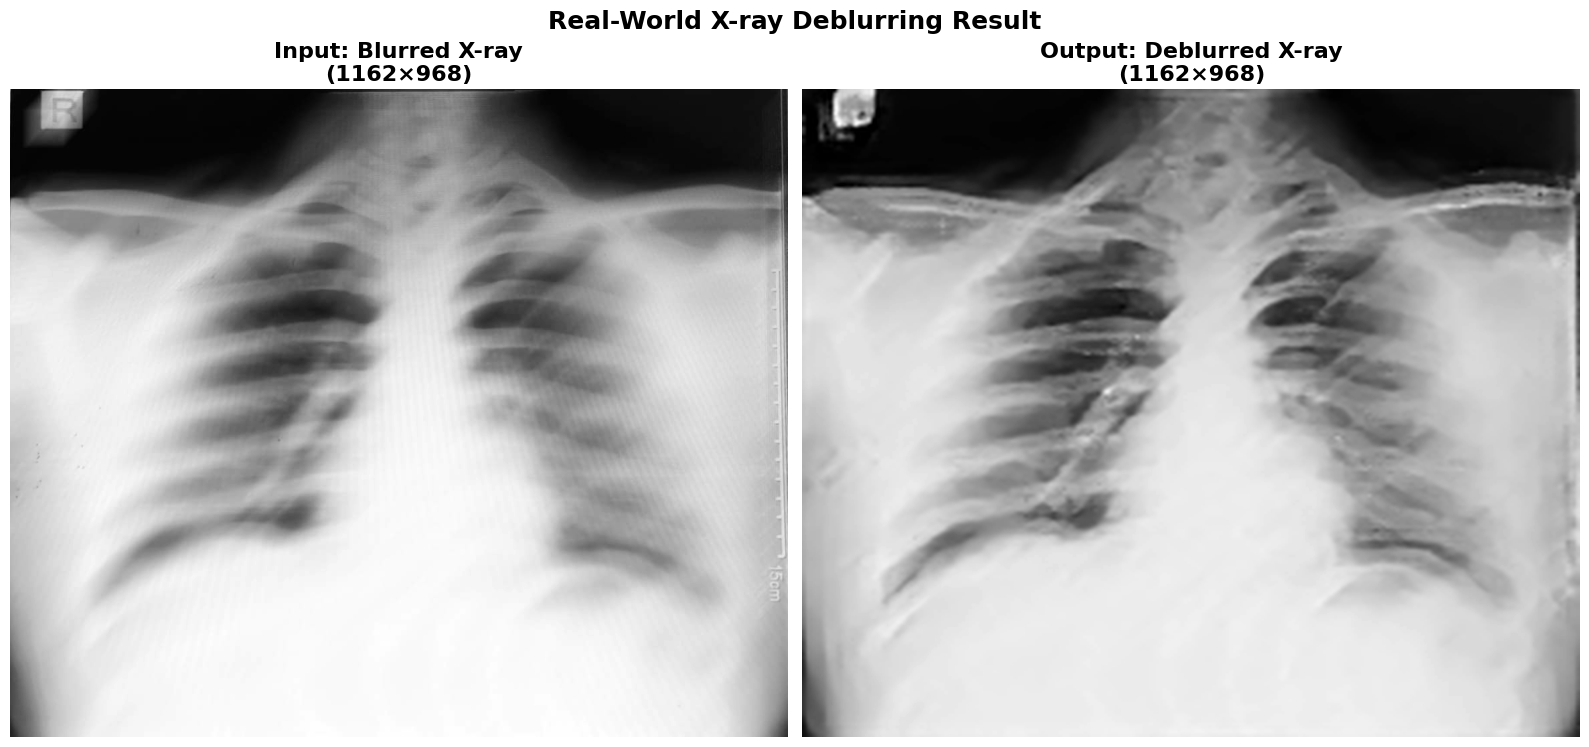

✅ Model-size comparison saved: /kaggle/working/real_world_deblurred/comparison_224x224.png


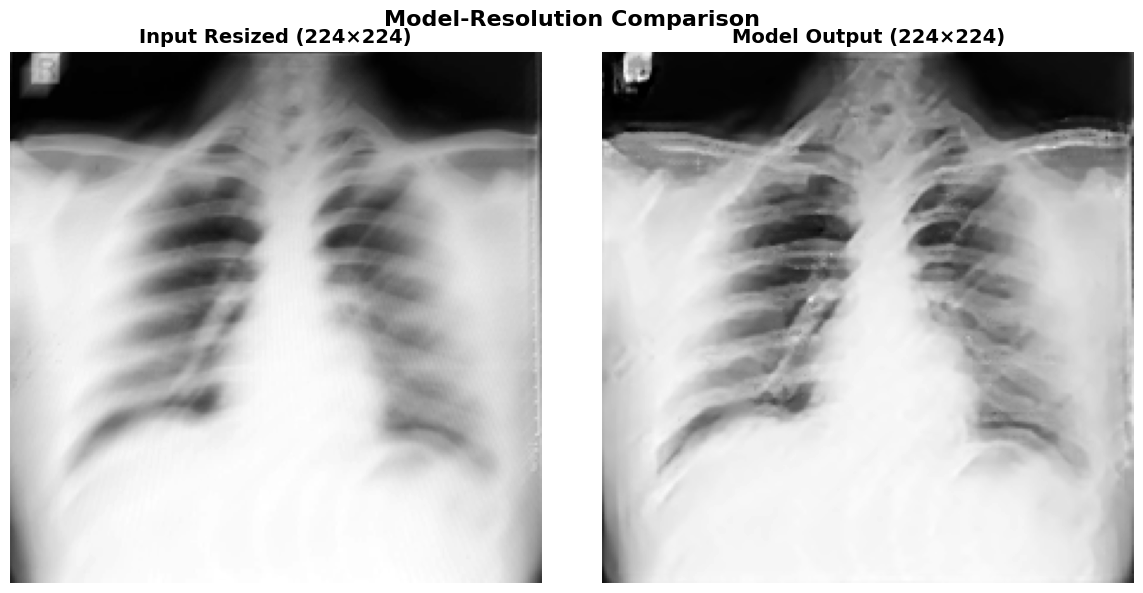


DEBLURRING COMPLETED SUCCESSFULLY!

📊 Input Image:  1162×968
🔧 Model Input:  224×224 (auto-resized)
📤 Output Image: 1162×968 (upscaled back)

📁 All outputs saved in: /kaggle/working/real_world_deblurred
   • deblurred_224x224.png - Model output
   • deblurred_fullsize.png - Upscaled to original size
   • original_blurred.png - Input copy
   • comparison_fullsize.png - Side-by-side (original size)
   • comparison_224x224.png - Side-by-side (model size)


In [5]:
# ========================================
# CELL: Real-World Blurred X-ray Deblurring (Handles Any Input Size)
# ========================================
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from vision_transformer import CSwinUnet

# ========================================
# CONFIGURATION
# ========================================
MODEL_PATH = '/kaggle/input/saves/pytorch/default/1/final_model_org_train.pth'
INPUT_IMAGE_PATH = '/kaggle/input/real-test/real_image.jpg'
OUTPUT_DIR = '/kaggle/working/real_world_deblurred'

# Model parameters (FIXED - trained on 224×224)
MODEL_INPUT_SIZE = 224
NUM_CLASSES = 1

# ========================================
# SETUP
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load model
print("Loading trained model...")
model = CSwinUnet(img_size=MODEL_INPUT_SIZE, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded successfully")
print(f"   Model expects input size: {MODEL_INPUT_SIZE}×{MODEL_INPUT_SIZE}\n")

# ========================================
# LOAD IMAGE AND CHECK SIZE
# ========================================
print(f"Loading image: {INPUT_IMAGE_PATH}")
blurred_image = Image.open(INPUT_IMAGE_PATH).convert('L')
original_width, original_height = blurred_image.size

print(f"   Original image size: {original_width}×{original_height}")

# Check if resizing is needed
if original_width != MODEL_INPUT_SIZE or original_height != MODEL_INPUT_SIZE:
    print(f"   ⚠️  Image will be resized to {MODEL_INPUT_SIZE}×{MODEL_INPUT_SIZE} for model input")
    print(f"   ✅ Output will be upscaled back to {original_width}×{original_height}")
else:
    print(f"   ✅ Image size matches model input - no resizing needed")

# ========================================
# IMAGE PREPROCESSING (AUTO-RESIZE TO 224×224)
# ========================================
transform_to_model = transforms.Compose([
    transforms.Resize((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE), interpolation=Image.LANCZOS),  # ← Auto-resize
    transforms.ToTensor()
])

blurred_tensor = transform_to_model(blurred_image).unsqueeze(0).to(device)
print(f"   Tensor shape for model: {blurred_tensor.shape}")  # Should be [1, 1, 224, 224]

# ========================================
# DEBLUR
# ========================================
print("\nDeblurring image...")
with torch.no_grad():
    deblurred_tensor = model(blurred_tensor)
    deblurred_tensor = torch.clamp(deblurred_tensor, 0, 1)

# Convert back to PIL Image
transform_to_pil = transforms.ToPILImage()
deblurred_image_224 = transform_to_pil(deblurred_tensor.squeeze(0).cpu())

print("✅ Deblurring complete!")

# ========================================
# UPSCALE TO ORIGINAL SIZE
# ========================================
print(f"\nUpscaling output to original size: {original_width}×{original_height}")
deblurred_image_fullsize = deblurred_image_224.resize(
    (original_width, original_height), 
    Image.LANCZOS  # High-quality interpolation
)

# ========================================
# SAVE RESULTS
# ========================================
print("\nSaving results...")

# 1. Save model-size output (224×224)
deblurred_224_path = os.path.join(OUTPUT_DIR, 'deblurred_224x224.png')
deblurred_image_224.save(deblurred_224_path)
print(f"✅ Model output (224×224) saved: {deblurred_224_path}")

# 2. Save full-size output (original dimensions)
deblurred_fullsize_path = os.path.join(OUTPUT_DIR, 'deblurred_fullsize.png')
deblurred_image_fullsize.save(deblurred_fullsize_path)
print(f"✅ Full-size output ({original_width}×{original_height}) saved: {deblurred_fullsize_path}")

# 3. Save original blurred (for reference)
blurred_copy_path = os.path.join(OUTPUT_DIR, 'original_blurred.png')
blurred_image.save(blurred_copy_path)
print(f"✅ Original blurred image saved: {blurred_copy_path}")

# ========================================
# DISPLAY: Side-by-Side Comparison (Full Size)
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Input (original size)
axes[0].imshow(blurred_image, cmap='gray')
axes[0].set_title(f'Input: Blurred X-ray\n({original_width}×{original_height})', 
                  fontsize=16, fontweight='bold')
axes[0].axis('off')

# Output (upscaled to original size)
axes[1].imshow(deblurred_image_fullsize, cmap='gray')
axes[1].set_title(f'Output: Deblurred X-ray\n({original_width}×{original_height})', 
                  fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Real-World X-ray Deblurring Result', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()

# Save comparison
comparison_path = os.path.join(OUTPUT_DIR, 'comparison_fullsize.png')
plt.savefig(comparison_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Comparison image saved: {comparison_path}")

plt.show()

# ========================================
# DISPLAY: Model-Size Comparison (224×224)
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

blurred_image_224 = blurred_image.resize((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE), Image.LANCZOS)

axes[0].imshow(blurred_image_224, cmap='gray')
axes[0].set_title(f'Input Resized (224×224)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(deblurred_image_224, cmap='gray')
axes[1].set_title(f'Model Output (224×224)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Model-Resolution Comparison', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

comparison_224_path = os.path.join(OUTPUT_DIR, 'comparison_224x224.png')
plt.savefig(comparison_224_path, dpi=200, bbox_inches='tight', facecolor='white')
print(f"✅ Model-size comparison saved: {comparison_224_path}")

plt.show()

# ========================================
# SUMMARY
# ========================================
print("\n" + "="*70)
print("DEBLURRING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\n📊 Input Image:  {original_width}×{original_height}")
print(f"🔧 Model Input:  {MODEL_INPUT_SIZE}×{MODEL_INPUT_SIZE} (auto-resized)")
print(f"📤 Output Image: {original_width}×{original_height} (upscaled back)")
print(f"\n📁 All outputs saved in: {OUTPUT_DIR}")
print(f"   • deblurred_224x224.png - Model output")
print(f"   • deblurred_fullsize.png - Upscaled to original size")
print(f"   • original_blurred.png - Input copy")
print(f"   • comparison_fullsize.png - Side-by-side (original size)")
print(f"   • comparison_224x224.png - Side-by-side (model size)")
print("="*70)


In [6]:
import shutil

# Create zip of entire working directory
shutil.make_archive(
    '/kaggle/working/real_test',  # Output filename (without .zip)
    'zip',                               # Archive format
    '/kaggle/working/real_world_deblurred'                    # Directory to zip
)

print("✅ Complete working directory zipped!")
print("📥 Download 'complete_backup.zip' from Output section")


✅ Complete working directory zipped!
📥 Download 'complete_backup.zip' from Output section


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda

Loading trained model...
depth [1, 2, 9, 1]
CSWinUnet model initialized.
✅ Model loaded successfully
   Model expects input size: 224×224

Loading image: /kaggle/input/real-22/real_2.jpg
   Original image size: 1024×848
   ⚠️  Image will be resized to 224×224 for model input
   ✅ Output will be upscaled back to 1024×848
   Tensor shape for model: torch.Size([1, 1, 224, 224])

Deblurring image...
✅ Deblurring complete!

Upscaling output to original size: 1024×848

Saving results...
✅ Model output (224×224) saved: /kaggle/working/real_world_deblurred/deblurred_224x224.png
✅ Full-size output (1024×848) saved: /kaggle/working/real_world_deblurred/deblurred_fullsize.png
✅ Original blurred image saved: /kaggle/working/real_world_deblurred/original_blurred.png
✅ Comparison image saved: /kaggle/working/real_world_deblurred/comparison_fullsize.png


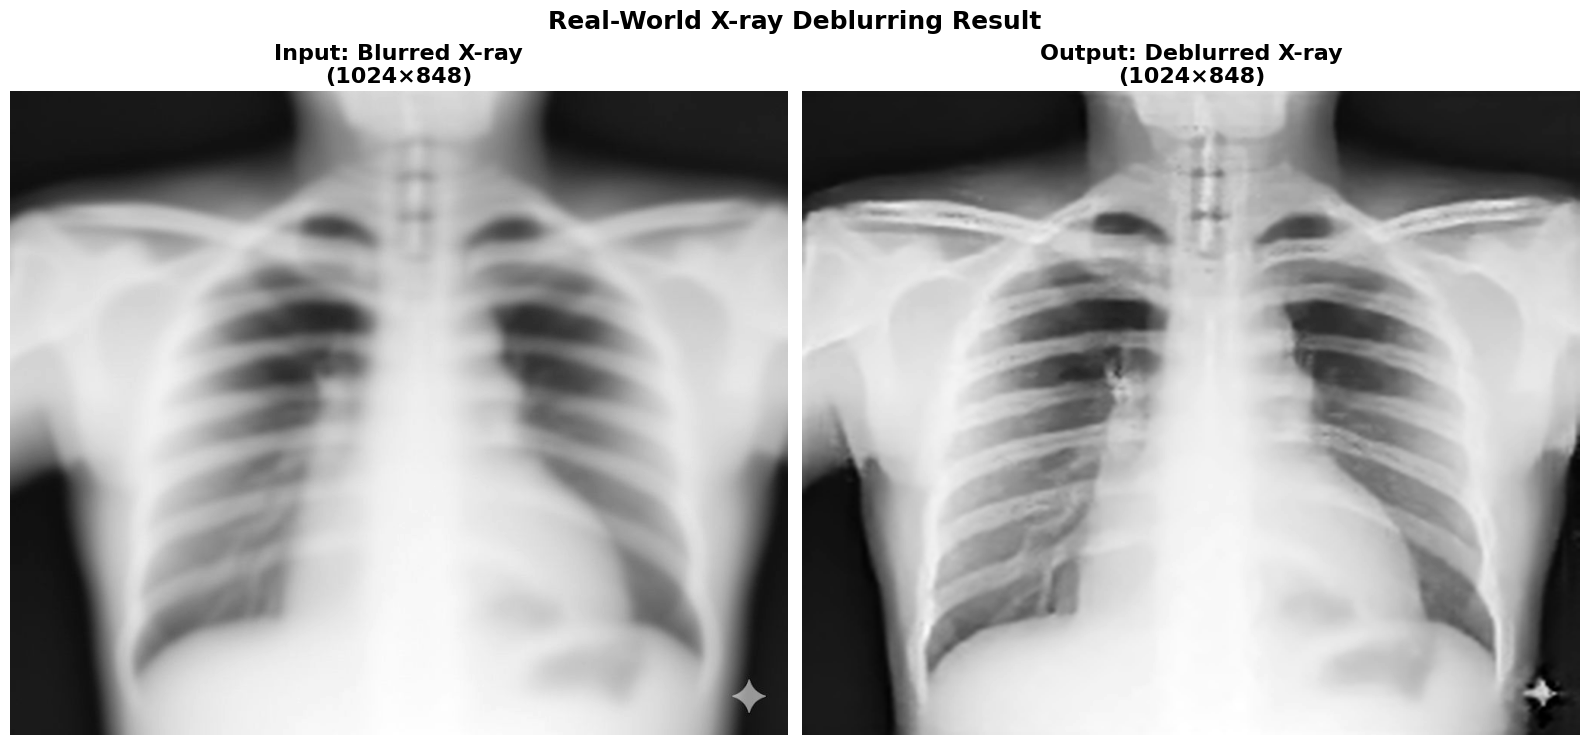

✅ Model-size comparison saved: /kaggle/working/real_world_deblurred/comparison_224x224.png


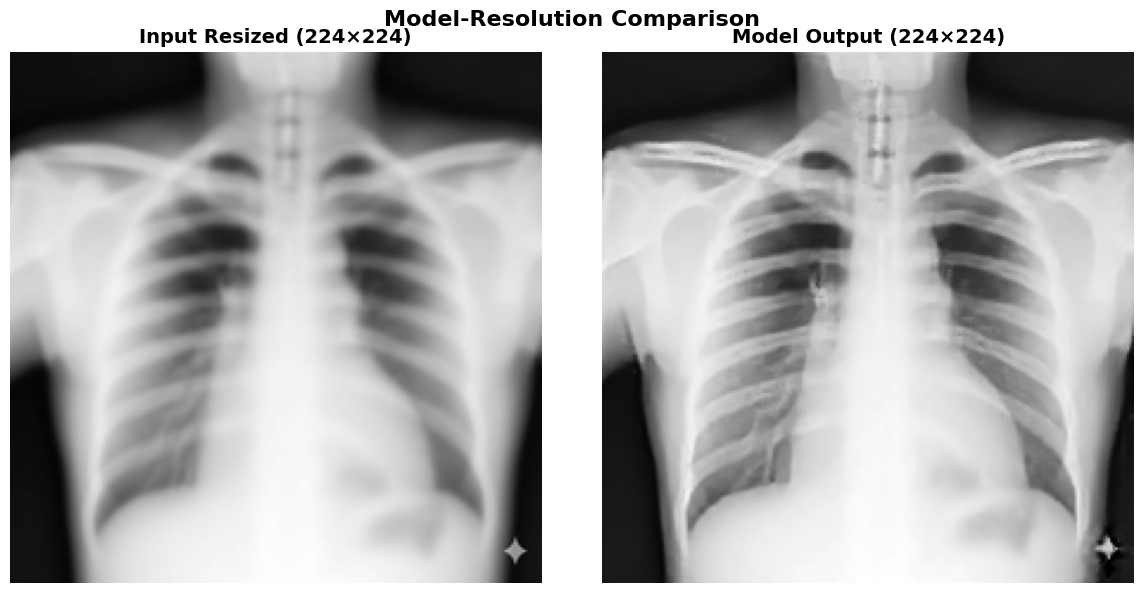


DEBLURRING COMPLETED SUCCESSFULLY!

📊 Input Image:  1024×848
🔧 Model Input:  224×224 (auto-resized)
📤 Output Image: 1024×848 (upscaled back)

📁 All outputs saved in: /kaggle/working/real_world_deblurred
   • deblurred_224x224.png - Model output
   • deblurred_fullsize.png - Upscaled to original size
   • original_blurred.png - Input copy
   • comparison_fullsize.png - Side-by-side (original size)
   • comparison_224x224.png - Side-by-side (model size)


In [5]:
# ========================================
# CELL: Real-World Blurred X-ray Deblurring (No Blur Simulation)
# ========================================
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from vision_transformer import CSwinUnet

# ========================================
# CONFIGURATION
# ========================================
MODEL_PATH = '/kaggle/input/saves/pytorch/default/1/final_model_org_train.pth'
INPUT_IMAGE_PATH = '/kaggle/input/real-22/real_2.jpg'
OUTPUT_DIR = '/kaggle/working/real_world_deblurred'

# Model parameters (FIXED - trained on 224×224)
MODEL_INPUT_SIZE = 224
NUM_CLASSES = 1

# ========================================
# SETUP
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load model
print("Loading trained model...")
model = CSwinUnet(img_size=MODEL_INPUT_SIZE, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()
print("✅ Model loaded successfully")
print(f"   Model expects input size: {MODEL_INPUT_SIZE}×{MODEL_INPUT_SIZE}\n")

# ========================================
# LOAD IMAGE AND CHECK SIZE
# ========================================
print(f"Loading image: {INPUT_IMAGE_PATH}")
blurred_image = Image.open(INPUT_IMAGE_PATH).convert('L')
original_width, original_height = blurred_image.size

print(f"   Original image size: {original_width}×{original_height}")

# Check if resizing is needed
if original_width != MODEL_INPUT_SIZE or original_height != MODEL_INPUT_SIZE:
    print(f"   ⚠️  Image will be resized to {MODEL_INPUT_SIZE}×{MODEL_INPUT_SIZE} for model input")
    print(f"   ✅ Output will be upscaled back to {original_width}×{original_height}")
else:
    print(f"   ✅ Image size matches model input - no resizing needed")

# ========================================
# IMAGE PREPROCESSING (AUTO-RESIZE TO 224×224)
# ========================================
transform_to_model = transforms.Compose([
    transforms.Resize((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE), interpolation=Image.LANCZOS),
    transforms.ToTensor()
])

blurred_tensor = transform_to_model(blurred_image).unsqueeze(0).to(device)
print(f"   Tensor shape for model: {blurred_tensor.shape}")

# ========================================
# DEBLUR
# ========================================
print("\nDeblurring image...")
with torch.no_grad():
    deblurred_tensor = model(blurred_tensor)
    deblurred_tensor = torch.clamp(deblurred_tensor, 0, 1)

# Convert back to PIL Image
transform_to_pil = transforms.ToPILImage()
deblurred_image_224 = transform_to_pil(deblurred_tensor.squeeze(0).cpu())

print("✅ Deblurring complete!")

# ========================================
# UPSCALE TO ORIGINAL SIZE
# ========================================
print(f"\nUpscaling output to original size: {original_width}×{original_height}")
deblurred_image_fullsize = deblurred_image_224.resize(
    (original_width, original_height), 
    Image.LANCZOS
)

# ========================================
# SAVE RESULTS
# ========================================
print("\nSaving results...")

# 1. Save model-size output (224×224)
deblurred_224_path = os.path.join(OUTPUT_DIR, 'deblurred_224x224.png')
deblurred_image_224.save(deblurred_224_path)
print(f"✅ Model output (224×224) saved: {deblurred_224_path}")

# 2. Save full-size output (original dimensions)
deblurred_fullsize_path = os.path.join(OUTPUT_DIR, 'deblurred_fullsize.png')
deblurred_image_fullsize.save(deblurred_fullsize_path)
print(f"✅ Full-size output ({original_width}×{original_height}) saved: {deblurred_fullsize_path}")

# 3. Save original blurred (for reference)
blurred_copy_path = os.path.join(OUTPUT_DIR, 'original_blurred.png')
blurred_image.save(blurred_copy_path)
print(f"✅ Original blurred image saved: {blurred_copy_path}")

# ========================================
# DISPLAY: Side-by-Side Comparison (Full Size)
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Input (original size)
axes[0].imshow(blurred_image, cmap='gray')
axes[0].set_title(f'Input: Blurred X-ray\n({original_width}×{original_height})', 
                  fontsize=16, fontweight='bold')
axes[0].axis('off')

# Output (upscaled to original size)
axes[1].imshow(deblurred_image_fullsize, cmap='gray')
axes[1].set_title(f'Output: Deblurred X-ray\n({original_width}×{original_height})', 
                  fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Real-World X-ray Deblurring Result', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()

# Save comparison
comparison_path = os.path.join(OUTPUT_DIR, 'comparison_fullsize.png')
plt.savefig(comparison_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Comparison image saved: {comparison_path}")

plt.show()

# ========================================
# DISPLAY: Model-Size Comparison (224×224)
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

blurred_image_224 = blurred_image.resize((MODEL_INPUT_SIZE, MODEL_INPUT_SIZE), Image.LANCZOS)

axes[0].imshow(blurred_image_224, cmap='gray')
axes[0].set_title(f'Input Resized (224×224)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(deblurred_image_224, cmap='gray')
axes[1].set_title(f'Model Output (224×224)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Model-Resolution Comparison', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

comparison_224_path = os.path.join(OUTPUT_DIR, 'comparison_224x224.png')
plt.savefig(comparison_224_path, dpi=200, bbox_inches='tight', facecolor='white')
print(f"✅ Model-size comparison saved: {comparison_224_path}")

plt.show()

# ========================================
# SUMMARY
# ========================================
print("\n" + "="*70)
print("DEBLURRING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\n📊 Input Image:  {original_width}×{original_height}")
print(f"🔧 Model Input:  {MODEL_INPUT_SIZE}×{MODEL_INPUT_SIZE} (auto-resized)")
print(f"📤 Output Image: {original_width}×{original_height} (upscaled back)")
print(f"\n📁 All outputs saved in: {OUTPUT_DIR}")
print(f"   • deblurred_224x224.png - Model output")
print(f"   • deblurred_fullsize.png - Upscaled to original size")
print(f"   • original_blurred.png - Input copy")
print(f"   • comparison_fullsize.png - Side-by-side (original size)")
print(f"   • comparison_224x224.png - Side-by-side (model size)")
print("="*70)


In [6]:
import shutil

# Create zip of entire working directory
shutil.make_archive(
    '/kaggle/working/real_test_2',  # Output filename (without .zip)
    'zip',                               # Archive format
    '/kaggle/working/real_world_deblurred'                    # Directory to zip
)

print("✅ Complete working directory zipped!")
print("📥 Download 'complete_backup.zip' from Output section")


✅ Complete working directory zipped!
📥 Download 'complete_backup.zip' from Output section
